# Anomay Detection

## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_addons as tfa
from scipy.special import erf
import pandas as pd
from sklearn.neighbors import KernelDensity


from absl import app, flags

from iflow.integration import integrator
from iflow.integration import couplings

tfd = tfp.distributions  # pylint: disable=invalid-name
tfb = tfp.bijectors  # pylint: disable=invalid-name
tf.keras.backend.set_floatx('float64')

## Define functions

### For density estimation (ANODE part)

In [2]:
def find_outliers(data, make_plot=True, title=None, logscaling=[]):
    max_outliers = 10
    npoints = len(data)
    outliers = pd.DataFrame(index=data.index)
    for feature in data.columns:
        # sort by feature
        sorted_set = data.sort_values(by=feature)[feature]
        l0 = sorted_set.iloc[0]
        # get a list of the relative changes (from the right end of the histogram)
        rel_length_change = np.array([(sorted_set.iloc[i] - sorted_set.iloc[i-1])/(sorted_set.iloc[i] - l0)
                             for i in range(npoints-1, npoints -1 -max_outliers, -1)])
        # find the most inner index where the outlier criterium is fulfilled
        index = rel_length_change[rel_length_change > 0.1]
        try:
            event_indices = sorted_set.index[-1 - index[-1]:]
            outliers[feature] = False
            outliers[feature].loc[event_indices] = True
        except IndexError:
            pass
        # plt.plot([i for i in range(npoints-1, npoints -1 -max_outliers, -1)], rel_length_change)
        # plt.ylim(0, .3)
        # plt.title(feature)
        # plt.show()
    outlier_features = list(outliers.columns)
    outliers = outliers.any(axis=1)
    print('found {} outliers in {}'.format(len(outliers[outliers]),
                                           outlier_features))

    if make_plot:
        bins=15
        minmax = data.agg(['min', 'max'])
        div, mod = divmod(len(data.columns), 3)
        if mod == 0:
            rows = div
        else:
            rows = 1 + div
        fig, axs = plt.subplots(rows, 3, figsize=(4*3, 4 * rows))
        for i, feature in enumerate(data.columns):
            try:
                ax = axs[divmod(i, 3)]
            except IndexError:
                ax = axs[i]
            ax.set_title(feature)
            ax.hist(data.iloc[:, i], density=False, histtype='step',
                                    bins=bins, range=tuple(minmax.iloc[:, i]))
            ax.hist(data[~outliers].iloc[:, i], density=False, histtype='step',
                                    bins=bins, range=tuple(minmax.iloc[:, i]))
            ax.set_xlim(tuple(minmax.iloc[:, i]))
            if feature in logscaling:
                ax.set_yscale('log')
        if mod != 0:
            for i in range(mod, 3):
                try:
                    axs[rows-1, i].remove()
                except IndexError:
                    axs[i].remove()
        if title is None:
            fig.suptitle('outlier removal', fontsize=18)
        else:
            fig.suptitle(title, fontsize=18)
        plt.show()
    return outliers

In [3]:
def prepare_mother_list(filepath, Nevents=-1, random_state=1, make_plot=True, testratio=0.15):
    # read and add column names
    data = pd.read_csv(filepath, header=None, sep=' ')
    data.columns = ['Event', 'mJJ', 'mJ1', 'tau21J1', 'mJ2', 'tau21J2']
    data.set_index('Event', inplace=True)
    
    # select only Nevents number of events
    Nevents = int(Nevents/(1-testratio))
    if len(data) < Nevents:
        print('WARNING: asking for {0} + {1} = {2} events (training + testing), but only {3} provided.'
              'Either reduce Nevents or the testratio (default=0.15)'.format(
                Nevents*(1-testratio), Nevents*testratio, Nevents, len(data)))
    if 0 < Nevents < len(data):
        data = data.sample(Nevents, random_state=random_state)
    
    # define training and testing subset
    data['dataset'] = 'training'
    testingset = data.sample(int(len(data)*testratio), random_state=0)
    testingset.dataset = 'testing'
    data.update(testingset)
    
    # remove nans and 0s, sort
    data = data[~np.any(np.isnan(data.drop(columns='dataset')) | (data.drop(columns='dataset')==0), axis=1)]
    data.sort_values(by='mJJ', inplace=True)
    
    # make mJ1 > mJ2 (and also swap tau_21 accordingly)
    data['mmax'] = np.max(data[['mJ1', 'mJ2']], axis=1)
    data['mmin'] = np.min(data[['mJ1', 'mJ2']], axis=1)
    J1ismax = data.mJ1 == data.mmax
    data['tau21max'] = data[J1ismax].tau21J1
    data.loc[~J1ismax, 'tau21max'] = data[~J1ismax].tau21J2
    data['tau21min'] = data[J1ismax].tau21J2
    data.loc[~J1ismax, 'tau21min'] = data[~J1ismax].tau21J1
    data.mJ1 = data.mmax
    data.mJ2 = data.mmin
    data.tau21J1 = data.tau21max
    data.tau21J2 = data.tau21min
    data['diffm'] = data.mmax - data.mmin
    data.drop(columns = ['mmax', 'mmin', 'tau21max', 'tau21min', 'mJ2'], inplace=True)
    
    print('retrieved array of shape {}'.format(data.shape))
    print(data.head())
    if make_plot:
        div, mod = divmod(len(data.columns), 3)
        if mod == 0:
            rows = div
        else:
            rows = 1 + div
        fig, axs = plt.subplots(rows, 3, figsize=(4*3, 4 * rows))
        for i, feature in enumerate(data.columns):
            hist_range = None
            bins=20
            if feature == 'mJ1':
                hist_range = (0, 750)
            elif feature == 'mJ2':
                hist_range = (0, 400)
            elif feature == 'mJJ':
                hist_range = (2000, 5000)
            elif feature == 'diffm':
                hist_range = (0, 400)
            elif feature == 'dataset':
                hist_range = (-0.5, 2.5)
                bins = 3
            axs[divmod(i, 3)].set_title(feature)
            axs[divmod(i, 3)].hist(data.iloc[:, i], density=True, bins=bins, range=hist_range)
        if mod != 0:
            for i in range(mod, 3):
                axs[rows-1, i].remove()        
        plt.tight_layout()
        plt.savefig('{}_distributions.png'.format(filepath))
        plt.show()

    return data

def prepare_data_train_signal(M,deltaM,list_by_minv):
    # pick a window
    listcp = np.copy(list_by_minv)
    listcp[:,0]=np.where(listcp[:,0]>(M+deltaM),0,listcp[:,0])
    listcp[:,0]=np.where(listcp[:,0]<(M-deltaM),0,listcp[:,0])
    mask = np.any (np.equal(listcp, 0), axis=1)
    sublist=listcp[~mask]
    
    # make it a unit hypercube
    minimum=np.amin(list_by_minv,axis=0,keepdims=True)
    maximum=np.amax(list_by_minv,axis=0,keepdims=True)
    data_train=(sublist-minimum)*(1.0/(maximum-minimum))
    data_train = tf.where(data_train > 1e-16, data_train, data_train+1e-16)
    
    return data_train[:,1:5],sublist[:,0]

def prepare_data_train_bkg(list_by_minv):
    
    sublist=np.copy(list_by_minv)   
    # make it a unit hypercube
    minimum=np.amin(list_by_minv,axis=0,keepdims=True)
    maximum=np.amax(list_by_minv,axis=0,keepdims=True)
    data_train=(sublist-minimum)*(1.0/(maximum-minimum))
    data_train = tf.where(data_train > 1e-16, data_train, data_train+1e-16)
    data_train = tf.where(data_train <1.0, data_train, 1.0-1e-16)
    return data_train[:,1:5]

def prepare_data_train(M,deltaM,list_by_minv, ignore=None):
    if not ignore is None:
        if type(ignore) == str:
            ignore = [ignore]
        ignored = list_by_minv.loc[:, ignore]
        list_by_minv = list_by_minv.drop(columns = ignore)
    SR = (list_by_minv.mJJ > (M-deltaM)) & (list_by_minv.mJJ < (M+deltaM))

    #put the data on a unit hypercube and remove the edges
    hypercubemargin = 0.05
    minmax = list_by_minv.agg(['min', 'max'])
    # exact hypercube
    hcube = (list_by_minv - minmax.loc['min'])/(minmax.loc['max'] - minmax.loc['min'])
    # remove edges
    edge = (hcube < hypercubemargin).any(axis=1) | (hcube > 1-hypercubemargin).any(axis=1)
    print('efficiency in SR when cutting edges of hypercube: {:.2f}'.format(
        len(hcube[SR & ~edge])/len(hcube[SR])))
    if not ignore is None:
        hcube = pd.concat([hcube, ignored], axis=1)
    
    SBdata = hcube[~SR & ~edge].copy()
    SRdata = hcube[SR & ~edge].copy()
    SR_masses = list_by_minv[SR & ~edge].mJJ.values
    return SBdata, SRdata, SR_masses

def combine_sig_bkg(sig, bkg, make_plot=True):
    sig['signal'] = True
    bkg['signal'] = False
    
    combined = pd.concat([sig, bkg], ignore_index=True)
    # remove outliers in training and testing set separately
    # outliers_training = find_outliers(
    #     combined[combined.dataset == 'training'].drop(columns=['dataset', 'signal']),
    #     title='outliers in training', logscaling=['mJJ', 'mJ1', 'diffm'])
    # outliers_testing = find_outliers(
    #     combined[combined.dataset == 'testing'].drop(columns=['dataset', 'signal']),
    #     title='outliers in testing', logscaling=['mJJ', 'mJ1', 'diffm'])
    # outliers = pd.concat([outliers_training, outliers_testing])
    # outliers = outliers.reindex(combined.index)
    # combined = combined[~outliers]


    if make_plot:
        div, mod = divmod(len(combined.columns), 3)
        if mod == 0:
            rows = div
        else:
            rows = 1 + div
        fig, axs = plt.subplots(rows, 3, figsize=(4*3, 4 * rows))
        for i, feature in enumerate(combined.columns):
            hist_range = None
            bins = 20
            if feature == 'dataset':
                hist_range = (-0.5, 2.5)
                bins = 3
                
            axs[divmod(i, 3)].set_title(feature)
            if combined.iloc[:, i].dtype == 'bool':
                axs[divmod(i, 3)].bar(['True', 'False'],
                                      [len(combined[combined.signal]), 0],
                                      label='signal')
                axs[divmod(i, 3)].bar(['True', 'False'],
                                      [0, len(combined[~combined.signal])],
                                      label='background')
            else:
                axs[divmod(i, 3)].hist(combined[~combined.signal].iloc[:, i],
                                       density=False, histtype='barstacked',
                                       label='background', range=hist_range, bins=bins)
                axs[divmod(i, 3)].hist(combined[combined.signal].iloc[:, i],
                                       density=False, histtype='barstacked',
                                       label='signal', range=hist_range, bins=bins)
            axs[divmod(i, 3)].set_yscale('log')
            axs[divmod(i, 3)].set_ylabel('# events, stacked')
            if i == 0:
                axs[divmod(i, 3)].legend()
        if mod != 0:
            for i in range(mod, 3):
                axs[rows-1, i].remove()        
        plt.tight_layout()
        plt.show()
    
    return combined

In [4]:
def build(in_features, out_features, options):
    " Build the NN. """
    del options

    invals = tf.keras.layers.Input(in_features, dtype=tf.float64)
    hidden = tf.keras.layers.Dense(64, activation='relu')(invals)
    hidden = tf.keras.layers.BatchNormalization(axis=-1)(hidden)
    hidden = tf.keras.layers.Dense(128, activation='relu')(hidden)
    hidden = tf.keras.layers.BatchNormalization(axis=-1)(hidden)
    hidden = tf.keras.layers.Dense(128, activation='relu')(hidden)
    hidden = tf.keras.layers.BatchNormalization(axis=-1)(hidden)
    hidden = tf.keras.layers.Dense(64, activation='relu')(hidden)
    hidden = tf.keras.layers.BatchNormalization(axis=-1)(hidden)
    hidden = tf.keras.layers.Dense(32, activation='relu')(hidden)
    outputs = tf.keras.layers.Dense(out_features)(hidden)
    model = tf.keras.models.Model(invals, outputs)
    model.summary()
    return model

In [5]:
def mask_flip(mask):
    """ Interchange 0 <-> 1 in the mask. """
    return 1-mask


def binary_list(inval, length):
    """ Convert x into a binary list of length l. """
    return np.array([int(i) for i in np.binary_repr(inval, length)])


def binary_masks(ndims):
    """ Create binary masks for to account for symmetries. """
    n_masks = int(np.ceil(np.log2(ndims)))
    sub_masks = np.transpose(np.array(
        [binary_list(i, n_masks)
         for i in range(ndims)]))[::-1]
    flip_masks = mask_flip(sub_masks)

    # Combine masks
    masks = np.empty((2*n_masks, ndims))
    masks[0::2] = flip_masks
    masks[1::2] = sub_masks

    return masks

In [6]:
def build_iflow(ndims,lr, weight_decay):
    min_mask = np.pad(binary_masks(4),((0,0),(1,0)),'constant',constant_values=(0,0))
    masks = np.pad(binary_masks(4),((0,0),(1,0)),'constant',constant_values=(0,0))
    for i in range(0):
        masks = np.concatenate((masks, min_mask))
    bijector=[]
    for mask in masks:
        bijector.append(couplings.PiecewiseRationalQuadratic(mask,build,num_bins=20,blob=None,options=None))
    
    bijector=tfb.Chain(list(reversed(bijector)))
    low = np.zeros(ndims, dtype=np.float64)
    high = np.ones(ndims, dtype=np.float64)
    dist = tfd.Uniform(low=low, high=high)
    dist = tfd.Independent(distribution=dist,reinterpreted_batch_ndims=1)
    dist = tfd.TransformedDistribution(distribution=dist,bijector=bijector)
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(lr, decay_steps=5000, decay_rate=0.5)
    optimizer = tfa.optimizers.AdamW(weight_decay, learning_rate=lr_schedule, clipnorm=10.0,
                                     #, amsgrad=True
                                     )
    return dist, optimizer

In [7]:
@tf.function
def get_loss(dist, sample):
    test = dist.prob(sample)
    logq = tf.where(test > 1e-16, tf.math.log(test),tf.math.log(test+1e-16))
    return -tf.reduce_mean(logq)

@tf.function
def train_one_step(dist,optimizer,samples):
    #samples=data_train[epoch*nsamples:(epoch+1)*nsamples,:]
    with tf.GradientTape() as tape:
        test = dist.prob(samples)
        #print(test)
        #logq = dist.log_prob(samples)
        #mean, var = tf.nn.moments(x=true/test, axes=[0])
        #true = tf.stop_gradient(true/mean)
        logq = tf.where(test > 1e-16, tf.math.log(test),tf.math.log(test+1e-16))
        #print(logq)
        loss = - tf.reduce_mean(logq)
    
    grads = tape.gradient(loss, dist.trainable_variables)
    optimizer.apply_gradients(zip(grads, dist.trainable_variables))
    return loss

@tf.function
def train_one_step_no2(dist,optimizer,samples):
    print('running #2')
    #samples=data_train[epoch*nsamples:(epoch+1)*nsamples,:]
    with tf.GradientTape() as tape:
        test = dist.prob(samples)
        #print(test)
        #logq = dist.log_prob(samples)
        #mean, var = tf.nn.moments(x=true/test, axes=[0])
        #true = tf.stop_gradient(true/mean)
        logq = tf.where(test > 1e-16, tf.math.log(test),tf.math.log(test+1e-16))
        #print(logq)
        loss = - tf.reduce_mean(logq)
        
    grads = tape.gradient(loss, dist.trainable_variables)
    optimizer.apply_gradients(zip(grads, dist.trainable_variables))
    return loss

@tf.function
def train_one_step_no3(dist,optimizer,samples):
    print('running #3')
    #samples=data_train[epoch*nsamples:(epoch+1)*nsamples,:]
    with tf.GradientTape() as tape:
        test = dist.prob(samples)
        #print(test)
        #logq = dist.log_prob(samples)
        #mean, var = tf.nn.moments(x=true/test, axes=[0])
        #true = tf.stop_gradient(true/mean)
        logq = tf.where(test > 1e-16, tf.math.log(test),tf.math.log(test+1e-16))
        #print(logq)
        loss = - tf.reduce_mean(logq)
        
    grads = tape.gradient(loss, dist.trainable_variables)
    optimizer.apply_gradients(zip(grads, dist.trainable_variables))
    return loss

In [8]:
def save_weights(dist, epoch=0, prefix=''):
    for j, bijector in enumerate(dist.bijector.bijectors):
        bijector.transform_net.save_weights(
                './models/{}epoch_{}_model_layer_{:02d}'.format(prefix, epoch, j))

def load_weights(dist, epoch=0, prefix=''):
    for j, bijector in enumerate(dist.bijector.bijectors):
        bijector.transform_net.load_weights(
                './models/{}epoch_{}_model_layer_{:02d}'.format(prefix, epoch, j))
    print("Model loaded successfully")

In [9]:
def train_iflow(list_by_minv,M=3800, deltaM=100, issig=True, batchsize=200,
                lr=1e-3, epochs=10, weight_decay=1e-6, average_length=10):
    
    bkg, sig, invM = prepare_data_train(M,deltaM, list_by_minv, ignore='dataset')

    if issig:
        data = sig
        prefix = 'sig_'
    else:
        data = bkg
        prefix = 'bkg_'
    
    data_train = tf.convert_to_tensor(data.query('dataset=="training"').drop(columns='dataset').values)
    data_test = tf.convert_to_tensor(data.query('dataset=="testing"').drop(columns='dataset').values)
    (totalpts, ndims) = np.shape(data_train)
    print('{} events available for training'.format(totalpts))
    
    dist, optimizer = build_iflow(ndims, lr, weight_decay=weight_decay) #ignore the dimension of invM_{j1,j2}
       
    batches = int(totalpts/batchsize) + 1
    print('{} batches'.format(batches))
    
    #try:
        #load_weights(dist)
    #except tf.errors.InvalidArgumentError:
    losses = [0]
    test_losses = [0]
    for epoch in range(epochs):
        data_train=tf.random.shuffle(data_train)
        for batch in range(batches):
            samples=data_train[batch*batchsize:(batch+1)*batchsize,:]
                #print(samples)
            try:
                loss = train_one_step(dist,optimizer,samples)
            except:
                try:
                    loss = train_one_step_no2(dist, optimizer, samples)
                except:
                    loss = train_one_step_no3(dist, optimizer, samples)
            if batch % 10 ==0:
                print('Batch: {:3d} Loss = {:8e},'.format(batch, loss))
            losses += [loss.numpy()]
        if epoch % 1 == 0:
            test_losses += [get_loss(dist, data_test).numpy()]
            print('Epoch: {:3d} Loss = {:8e}, testing-loss = {:8e}'.format(epoch, loss, test_losses[-1]))
            plt.plot(np.arange(len(losses))/batches, losses, label='training')
            plt.plot(np.arange(len(test_losses)), test_losses, label='testing')
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.legend()
            for i in range(epoch+2):
                plt.axvline(linewidth=0.3, x=i, color='gray')
            plt.axhline(linewidth=0.5, y=test_losses[-1], color='r')
            plt.show()
        # export weights
        save_weights(dist, epoch, prefix)
    return dist, losses, test_losses

In [10]:
class MyDist(tfp.distributions.TransformedDistribution):
    # pretty much copy paste from tfp, but allows to plug in custom distributions to sample from.
    def _sample_n(self, n, seed=None, **distribution_kwargs):
        from tensorflow_probability.python.internal import prefer_static
        from tensorflow_probability.python.internal import distribution_util

        mod_dist = distribution_kwargs.get('mod_dist', None)
        try:
            del distribution_kwargs['mod_dist']
        except KeyError:
            pass
        override_event_shape = tf.convert_to_tensor(self._override_event_shape)
        override_batch_shape = tf.convert_to_tensor(self._override_batch_shape)
        base_is_scalar_batch = self.distribution.is_scalar_batch()

        needs_rotation = self._needs_rotation(
            override_event_shape, override_batch_shape, base_is_scalar_batch)
        sample_shape = prefer_static.concat([
            distribution_util.pick_vector(needs_rotation, self._empty, [n]),
            override_batch_shape,
            override_event_shape,
            distribution_util.pick_vector(needs_rotation, [n], self._empty),
        ], axis=0)
        
        if mod_dist is None:
            x = self.distribution.sample(sample_shape=sample_shape, seed=seed,
                                         **distribution_kwargs)
        else:
            if type(mod_dist) == list:
                x = None
                for dist in mod_dist:
                    if x is None:
                        try:
                            x = dist.sample(sample_shape=sample_shape, seed=seed,
                                                 **distribution_kwargs)
                        except TypeError:
                            x = dist.sample(sample_shape)
                    else:
                        try:
                            x = np.append(x, dist.sample(sample_shape=sample_shape, seed=seed,
                                                 **distribution_kwargs), axis=1)
                        except TypeError:
                            x = np.append(x, dist.sample(sample_shape), axis=1)
            else:
                x = mod_dist.sample(sample_shape=sample_shape, seed=seed,
                                             **distribution_kwargs)
                try:
                    x = tf.concat(x, -1)
                except:
                    for i, s in enumerate(x):
                        if len(s.shape) == 1:
                            x[i] = tf.reshape(s, (len(s), 1))
                    x = tf.concat(x, -1)
        x = self._maybe_rotate_dims(
            x, override_event_shape, override_batch_shape, base_is_scalar_batch)
        # We'll apply the bijector in the `_call_sample_n` function.
        return x

In [11]:
def custom_cycler(n):
    color = plt.cm.binary(np.linspace(0.1, 1,n))
    return cycler(color=color)

def plot_learned_distributions(dist, epochs, prefix='', Nsample=1000, truth=None, special_dim=None):
    if truth is None and not special_dim is None:
        raise InvalidArgumentError

    Nobs = dist.event_shape.as_list()[0]
    
    if not special_dim is None:
        # do KDE of this dimension
        kde_SK = KernelDensity(kernel='gaussian', bandwidth=0.002).fit(
            truth.iloc[:, special_dim].values.reshape(len(truth.iloc[:, special_dim].values), 1))
    avg_samples = {}
    div, mod = divmod(Nobs, 3)
    if mod == 0:
        rows = div
    else:
        rows = 1 + div
    fig, axs = plt.subplots(rows, 3, figsize=(4*3, 4 * rows))
    for i in range(Nobs):
        axs[divmod(i, 3)].set_prop_cycle(custom_cycler(len(epochs)))
    for epoch in epochs:
        joint_dist = [tfd.Uniform(low=[tf.cast(0, tf.float64)]*special_dim),
                      kde_SK,
                      tfd.Uniform(low=[tf.cast(0, tf.float64)]*(dist.event_shape[0]-1-special_dim))]
        load_weights(dist, epoch=epoch, prefix=prefix)
        dist.__class__ = MyDist
        sampled = np.transpose(dist.sample(Nsample, 
                                           distribution_kwargs = {'mod_dist': joint_dist}).numpy())
        dist.__class__ = tfd.TransformedDistribution
        for i, sample in enumerate(sampled):
            # take sub-sample to be combined to an average sample
            subsample = np.random.choice(sample, int(Nsample/len(epochs)), replace=False)
            try:
                avg_samples[i] = np.append(avg_samples[i], subsample)
            except KeyError:
                avg_samples[i] = subsample
            
            # plot the current sample
            axs[divmod(i, 3)].hist(sample, bins=15, range=(0,1), histtype='step',
                                   density=True)
    for i in avg_samples.keys():
        axs[divmod(i, 3)].hist(avg_samples[i], bins=15, range=(0,1), histtype='step',
                               density=True, color='r', label='average')
    if truth is not None:
        for i in range(Nobs):
            axs[divmod(i, 3)].hist(truth.iloc[:, i], bins=15, range=(0,1), histtype='step',
                                  density=True, color='b', label='truth')
            axs[divmod(i, 3)].set_title(truth.iloc[:, i].name)
            axs[divmod(i, 3)].set_yscale('log')
    if not special_dim is None:
        values = np.array([value for value in np.linspace(0, 1, 500)])
        probabilities = np.exp(kde_SK.score_samples(values.reshape(len(values), 1)))
        ylim = axs[divmod(special_dim, 3)].get_ylim()
        axs[divmod(special_dim, 3)].plot(values, probabilities, color='orange', label='KDE')
        axs[divmod(special_dim, 3)].legend()
        axs[divmod(special_dim, 3)].set_ylim(ylim)
    if mod != 0:
        for i in range(mod, 3):
            axs[rows-1, i].remove()        
    plt.legend()
    plt.show()

### For signal-background discrimination

In [12]:
def build_SB_NN(in_features):
    """ Build the NN for S/B separation"""

    invals = tf.keras.layers.Input(in_features, dtype=tf.float64)
    hidden = tf.keras.layers.Dense(128, activation='relu')(invals)
    hidden = tf.keras.layers.BatchNormalization(axis=-1)(hidden)
    hidden = tf.keras.layers.Dense(128, activation='relu')(hidden)
    hidden = tf.keras.layers.BatchNormalization(axis=-1)(hidden)
    hidden = tf.keras.layers.Dense(128, activation='relu')(hidden)
    hidden = tf.keras.layers.BatchNormalization(axis=-1)(hidden)
    hidden = tf.keras.layers.Dense(64, activation='relu')(hidden)
    hidden = tf.keras.layers.BatchNormalization(axis=-1)(hidden)
    hidden = tf.keras.layers.Dense(32, activation='relu')(hidden)
    outputs = tf.keras.layers.Dense(2)(hidden)
    model = tf.keras.models.Model(invals, outputs)
    model.summary()
    return model

In [13]:
def get_sample(dist, samplesize, mJJmin=0, mJJmax=1):
    if mJJmin > mJJmax:
        mJJmin, mJJmax = mJJmax, mJJmin

    efficiency = mJJmax - mJJmin
    full_sample = np.array([])
    while len(full_sample) < samplesize:
        events = dist.sample(max(1, int((samplesize-len(full_sample))/efficiency*1.1))).numpy()
        valid_sample = events[(events[:, 0] > mJJmin) & (events[:, 0] < mJJmax)]
        try:
            full_sample = np.vstack((full_sample, valid_sample))
        except ValueError:
            full_sample = events[(events[:, 0] > mJJmin) & (events[:, 0] < mJJmax)]
    return full_sample[: samplesize]

## Estimate density

### Import Data

retrieved array of shape (526251, 6)
            mJJ      mJ1   tau21J1   tau21J2   dataset     diffm
Event                                                           
450885  1132.28  256.442  0.584751  0.721372  training  134.4270
602321  1369.24  153.433  0.509714  0.653790  training  137.3435
860227  1446.18  139.737  0.696821  0.713870  training  125.8934
925004  1483.28  179.502  0.607219  0.705781  training  162.2613
133206  1495.57  303.328  0.276508  0.401215  training  222.6208


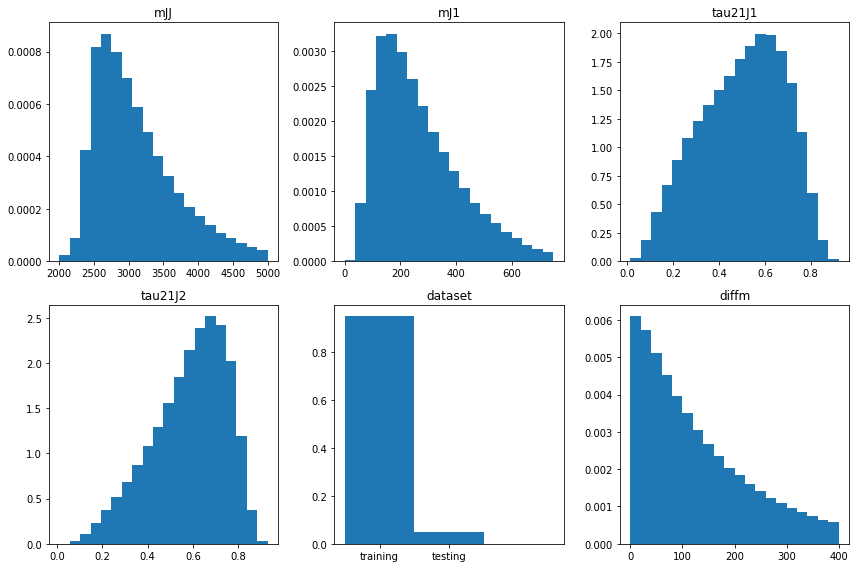

retrieved array of shape (588, 6)
           mJJ      mJ1   tau21J1   tau21J2   dataset     diffm
Event                                                          
16617  2328.29  502.652  0.059203  0.741238  training  382.3700
59906  2329.76  170.488  0.491438  0.196261  training   67.5050
17434  2438.02  539.559  0.206241  0.255750  training  439.0360
47859  2559.12  451.197  0.325897  0.584055  training  325.5760
98122  2755.21  416.224  0.174218  0.240144  training  322.4574


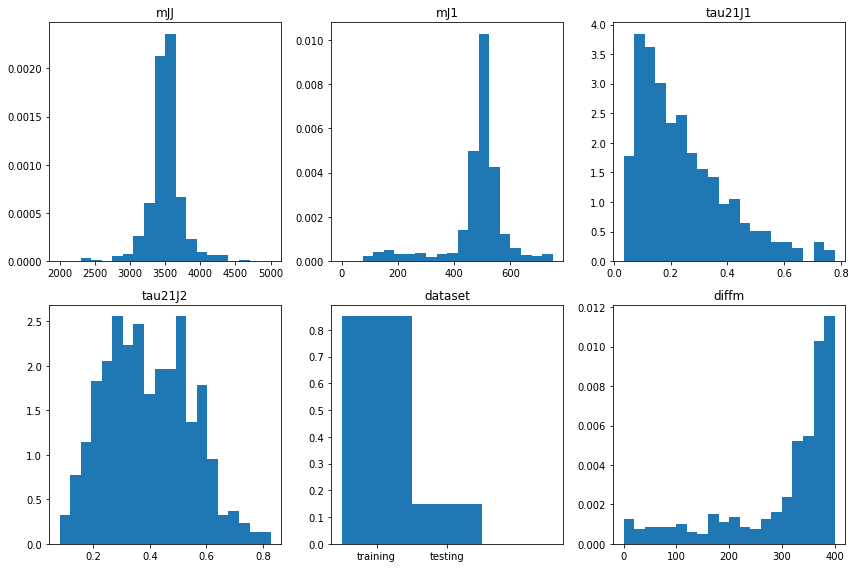

In [14]:
bkgname="rndbkgout.txt"
signame="rndsigout.txt"
bkglist=prepare_mother_list(bkgname, 500000, random_state=10, testratio=0.05)
siglist=prepare_mother_list(signame, 500, random_state=10, testratio=0.15)

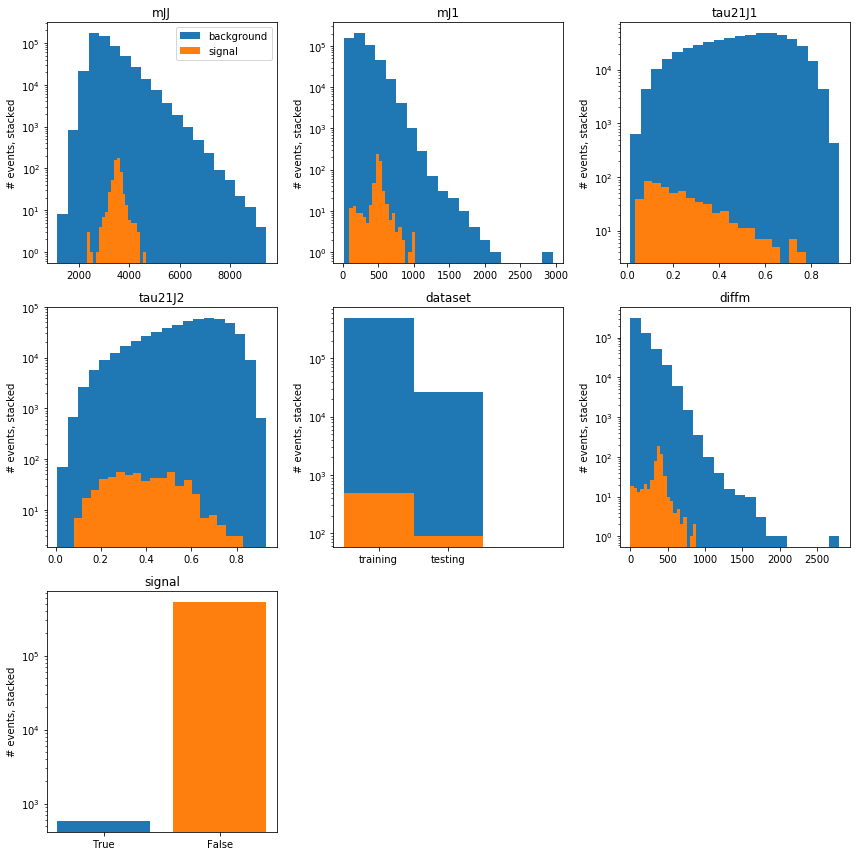

In [15]:
combined = combine_sig_bkg(siglist, bkglist)

In [16]:
Nsig_SR = combined.query('dataset == "training"').query('mJJ > 3300').query('mJJ < 3700').query('signal == 1').shape[0]
Nbkg_SR = combined.query('dataset == "training"').query('mJJ > 3300').query('mJJ < 3700').query('signal == 0').shape[0]
print('Nsig:', Nsig_SR)
print('Nbkg:', Nbkg_SR)
print('Nsig/Nbkg: {:.1e}'.format(Nsig_SR/Nbkg_SR))
print('Nsig/sqrt(Nbkg): {:.2f}'.format(Nsig_SR/np.sqrt(Nbkg_SR)))

Nsig: 376
Nbkg: 71330
Nsig/Nbkg: 5.3e-03
Nsig/sqrt(Nbkg): 1.41


### Train on signal region

In [17]:
data_bkg_train, data_sig_train, _ = prepare_data_train(3500,200, 
                                             combined.query('dataset=="training"').drop(columns='dataset'),
                                             ignore=['signal'])

efficiency in SR when cutting edges of hypercube: 0.45


efficiency in SR when cutting edges of hypercube: 0.45
32384 events available for training
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense (Dense)                (None, 64)                256       
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
____________________________________

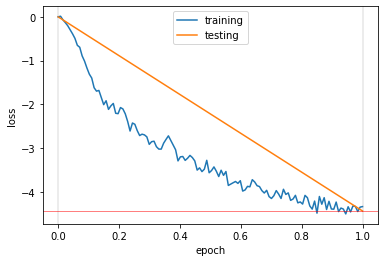

Batch:   0 Loss = -4.316125e+00,
Batch:  10 Loss = -4.520983e+00,
Batch:  20 Loss = -4.197550e+00,
Batch:  30 Loss = -4.337512e+00,
Batch:  40 Loss = -4.429931e+00,
Batch:  50 Loss = -4.318457e+00,
Batch:  60 Loss = -4.531311e+00,
Batch:  70 Loss = -4.607295e+00,
Batch:  80 Loss = -4.681219e+00,
Batch:  90 Loss = -4.741278e+00,
Batch: 100 Loss = -4.647225e+00,
Batch: 110 Loss = -4.899150e+00,
Batch: 120 Loss = -4.705914e+00,
Epoch:   1 Loss = -4.625007e+00, testing-loss = -4.766847e+00


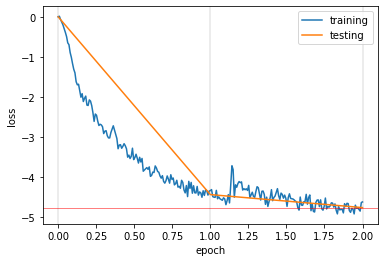

Batch:   0 Loss = -4.772285e+00,
Batch:  10 Loss = -4.928631e+00,
Batch:  20 Loss = -4.693505e+00,
Batch:  30 Loss = -4.757809e+00,
Batch:  40 Loss = -4.711771e+00,
Batch:  50 Loss = -4.899967e+00,
Batch:  60 Loss = -4.798545e+00,
Batch:  70 Loss = -4.862312e+00,
Batch:  80 Loss = -4.838099e+00,
Batch:  90 Loss = -4.767923e+00,
Batch: 100 Loss = -4.723341e+00,
Batch: 110 Loss = -4.715882e+00,
Batch: 120 Loss = -4.751541e+00,
Epoch:   2 Loss = -4.554717e+00, testing-loss = -4.730955e+00


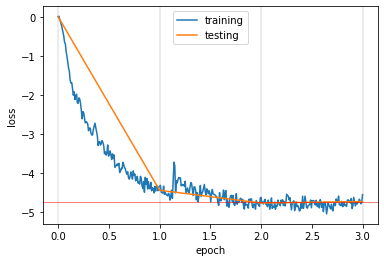

Batch:   0 Loss = -4.703941e+00,
Batch:  10 Loss = -4.804625e+00,
Batch:  20 Loss = -4.617631e+00,
Batch:  30 Loss = -4.697618e+00,
Batch:  40 Loss = -4.936941e+00,
Batch:  50 Loss = -4.916107e+00,
Batch:  60 Loss = -4.713200e+00,
Batch:  70 Loss = -4.954883e+00,
Batch:  80 Loss = -4.771455e+00,
Batch:  90 Loss = -4.934462e+00,
Batch: 100 Loss = -5.035282e+00,
Batch: 110 Loss = -4.814061e+00,
Batch: 120 Loss = -4.649255e+00,
Epoch:   3 Loss = -4.927017e+00, testing-loss = -4.734852e+00


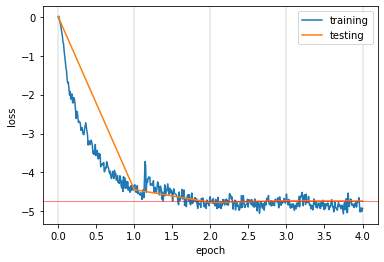

Batch:   0 Loss = -4.532514e+00,
Batch:  10 Loss = -4.851754e+00,
Batch:  20 Loss = -4.668774e+00,
Batch:  30 Loss = -4.900139e+00,
Batch:  40 Loss = -4.985265e+00,
Batch:  50 Loss = -4.930783e+00,
Batch:  60 Loss = -4.809709e+00,
Batch:  70 Loss = -4.958096e+00,
Batch:  80 Loss = -4.913727e+00,
Batch:  90 Loss = -4.694230e+00,
Batch: 100 Loss = -4.975057e+00,
Batch: 110 Loss = -4.877490e+00,
Batch: 120 Loss = -4.942344e+00,
Epoch:   4 Loss = -4.879641e+00, testing-loss = -4.894138e+00


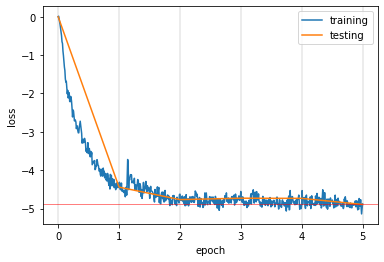

Batch:   0 Loss = -4.954969e+00,
Batch:  10 Loss = -4.911682e+00,
Batch:  20 Loss = -4.979118e+00,
Batch:  30 Loss = -4.775123e+00,
Batch:  40 Loss = -4.656497e+00,
Batch:  50 Loss = -4.743413e+00,
Batch:  60 Loss = -4.927654e+00,
Batch:  70 Loss = -4.864105e+00,
Batch:  80 Loss = -4.907573e+00,
Batch:  90 Loss = -4.816907e+00,
Batch: 100 Loss = -4.991538e+00,
Batch: 110 Loss = -4.761990e+00,
Batch: 120 Loss = -4.969525e+00,
Epoch:   5 Loss = -4.809572e+00, testing-loss = -4.898145e+00


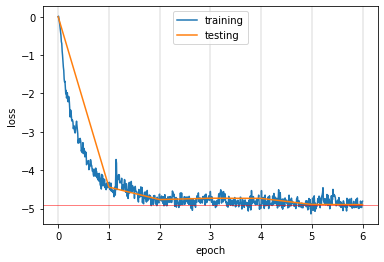

Batch:   0 Loss = -4.925022e+00,
Batch:  10 Loss = -4.669858e+00,
Batch:  20 Loss = -4.870866e+00,
Batch:  30 Loss = -4.807849e+00,
Batch:  40 Loss = -4.839394e+00,
Batch:  50 Loss = -4.875074e+00,
Batch:  60 Loss = -5.030566e+00,
Batch:  70 Loss = -4.996924e+00,
Batch:  80 Loss = -4.977700e+00,
Batch:  90 Loss = -4.963435e+00,
Batch: 100 Loss = -5.098208e+00,
Batch: 110 Loss = -4.983421e+00,
Batch: 120 Loss = -4.987943e+00,
Epoch:   6 Loss = -4.955732e+00, testing-loss = -4.824967e+00


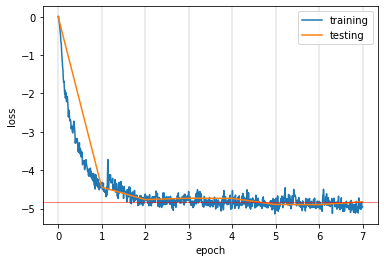

Batch:   0 Loss = -4.871480e+00,
Batch:  10 Loss = -4.498200e+00,
Batch:  20 Loss = -4.816286e+00,
Batch:  30 Loss = -4.866997e+00,
Batch:  40 Loss = -4.844760e+00,
Batch:  50 Loss = -4.965983e+00,
Batch:  60 Loss = -4.944901e+00,
Batch:  70 Loss = -4.945449e+00,
Batch:  80 Loss = -4.826292e+00,
Batch:  90 Loss = -4.829604e+00,
Batch: 100 Loss = -4.949325e+00,
Batch: 110 Loss = -5.029642e+00,
Batch: 120 Loss = -4.959102e+00,
Epoch:   7 Loss = -5.025606e+00, testing-loss = -4.896278e+00


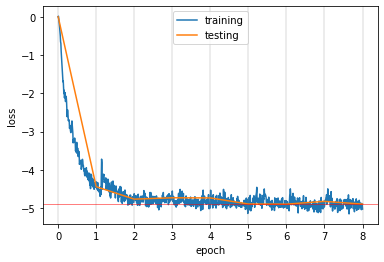

Batch:   0 Loss = -4.926860e+00,
Batch:  10 Loss = -4.954371e+00,
Batch:  20 Loss = -5.021433e+00,
Batch:  30 Loss = -4.811283e+00,
Batch:  40 Loss = -4.745182e+00,
Batch:  50 Loss = -4.996654e+00,
Batch:  60 Loss = -4.793838e+00,
Batch:  70 Loss = -4.828102e+00,
Batch:  80 Loss = -4.856569e+00,
Batch:  90 Loss = -4.804792e+00,
Batch: 100 Loss = -5.038336e+00,
Batch: 110 Loss = -4.967797e+00,
Batch: 120 Loss = -4.966133e+00,
Epoch:   8 Loss = -4.785103e+00, testing-loss = -4.893135e+00


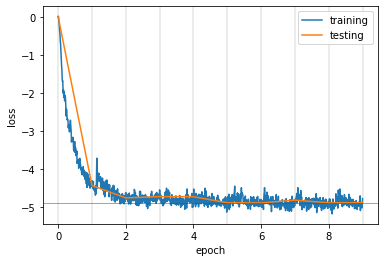

Batch:   0 Loss = -4.911927e+00,
Batch:  10 Loss = -5.002412e+00,
Batch:  20 Loss = -4.910045e+00,
Batch:  30 Loss = -4.883866e+00,
Batch:  40 Loss = -4.891967e+00,
Batch:  50 Loss = -5.021967e+00,
Batch:  60 Loss = -5.006420e+00,
Batch:  70 Loss = -4.916974e+00,
Batch:  80 Loss = -4.911870e+00,
Batch:  90 Loss = -4.833915e+00,
Batch: 100 Loss = -4.880428e+00,
Batch: 110 Loss = -4.907068e+00,
Batch: 120 Loss = -4.948829e+00,
Epoch:   9 Loss = -4.892302e+00, testing-loss = -4.842266e+00


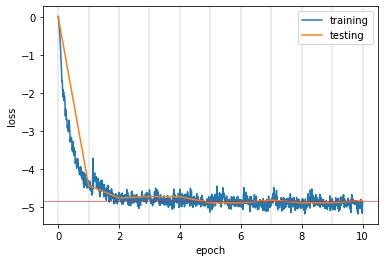

Batch:   0 Loss = -4.848129e+00,
Batch:  10 Loss = -4.938080e+00,
Batch:  20 Loss = -5.037445e+00,
Batch:  30 Loss = -4.880971e+00,
Batch:  40 Loss = -4.903953e+00,
Batch:  50 Loss = -4.726748e+00,
Batch:  60 Loss = -4.820331e+00,
Batch:  70 Loss = -4.906796e+00,
Batch:  80 Loss = -4.849056e+00,
Batch:  90 Loss = -5.164916e+00,
Batch: 100 Loss = -4.928056e+00,
Batch: 110 Loss = -4.740581e+00,
Batch: 120 Loss = -4.912424e+00,
Epoch:  10 Loss = -4.720121e+00, testing-loss = -4.931290e+00


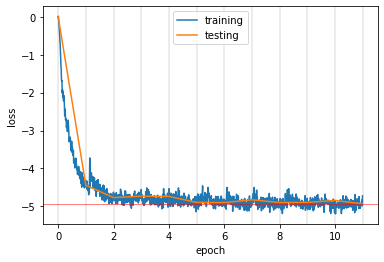

Batch:   0 Loss = -4.943591e+00,
Batch:  10 Loss = -4.928922e+00,
Batch:  20 Loss = -4.898318e+00,
Batch:  30 Loss = -4.905523e+00,
Batch:  40 Loss = -4.983870e+00,
Batch:  50 Loss = -4.925517e+00,
Batch:  60 Loss = -5.009341e+00,
Batch:  70 Loss = -4.869056e+00,
Batch:  80 Loss = -4.865910e+00,
Batch:  90 Loss = -5.022788e+00,
Batch: 100 Loss = -4.951137e+00,
Batch: 110 Loss = -5.027086e+00,
Batch: 120 Loss = -4.890416e+00,
Epoch:  11 Loss = -4.940101e+00, testing-loss = -4.908955e+00


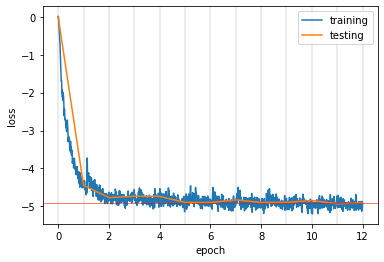

Batch:   0 Loss = -4.763725e+00,
Batch:  10 Loss = -4.901111e+00,
Batch:  20 Loss = -4.882809e+00,
Batch:  30 Loss = -5.060391e+00,
Batch:  40 Loss = -5.038344e+00,
Batch:  50 Loss = -4.886338e+00,
Batch:  60 Loss = -4.979454e+00,
Batch:  70 Loss = -4.890911e+00,
Batch:  80 Loss = -4.992998e+00,
Batch:  90 Loss = -4.925134e+00,
Batch: 100 Loss = -5.111447e+00,
Batch: 110 Loss = -4.971162e+00,
Batch: 120 Loss = -4.968911e+00,
Epoch:  12 Loss = -4.814310e+00, testing-loss = -4.939773e+00


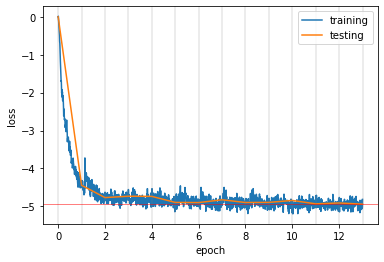

Batch:   0 Loss = -4.802695e+00,
Batch:  10 Loss = -4.874059e+00,
Batch:  20 Loss = -4.907299e+00,
Batch:  30 Loss = -5.005711e+00,
Batch:  40 Loss = -4.815530e+00,
Batch:  50 Loss = -4.844928e+00,
Batch:  60 Loss = -5.073353e+00,
Batch:  70 Loss = -5.054024e+00,
Batch:  80 Loss = -4.937948e+00,
Batch:  90 Loss = -5.007303e+00,
Batch: 100 Loss = -4.999177e+00,
Batch: 110 Loss = -4.794896e+00,
Batch: 120 Loss = -4.852686e+00,
Epoch:  13 Loss = -5.137799e+00, testing-loss = -4.906895e+00


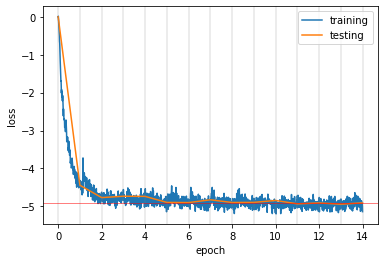

Batch:   0 Loss = -5.040796e+00,
Batch:  10 Loss = -5.025721e+00,
Batch:  20 Loss = -5.024225e+00,
Batch:  30 Loss = -4.962375e+00,
Batch:  40 Loss = -4.937837e+00,
Batch:  50 Loss = -4.967422e+00,
Batch:  60 Loss = -4.924415e+00,
Batch:  70 Loss = -4.999144e+00,
Batch:  80 Loss = -5.094827e+00,
Batch:  90 Loss = -5.010988e+00,
Batch: 100 Loss = -4.947639e+00,
Batch: 110 Loss = -4.728201e+00,
Batch: 120 Loss = -4.751425e+00,
Epoch:  14 Loss = -4.980574e+00, testing-loss = -4.841971e+00


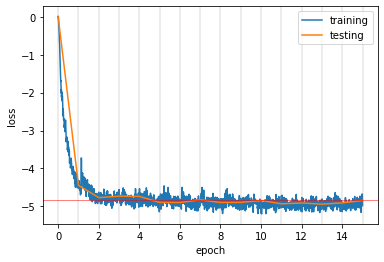

Batch:   0 Loss = -4.849173e+00,
Batch:  10 Loss = -4.787278e+00,
Batch:  20 Loss = -4.860766e+00,
Batch:  30 Loss = -4.904845e+00,
Batch:  40 Loss = -4.938373e+00,
Batch:  50 Loss = -4.986911e+00,
Batch:  60 Loss = -4.929103e+00,
Batch:  70 Loss = -4.823314e+00,
Batch:  80 Loss = -5.056873e+00,
Batch:  90 Loss = -5.143791e+00,
Batch: 100 Loss = -5.086346e+00,
Batch: 110 Loss = -4.843450e+00,
Batch: 120 Loss = -5.008783e+00,
Epoch:  15 Loss = -4.873899e+00, testing-loss = -4.942196e+00


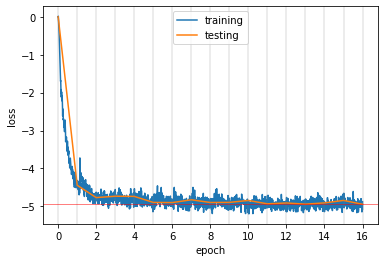

Batch:   0 Loss = -4.987606e+00,
Batch:  10 Loss = -4.851506e+00,
Batch:  20 Loss = -4.941824e+00,
Batch:  30 Loss = -5.065128e+00,
Batch:  40 Loss = -4.840902e+00,
Batch:  50 Loss = -5.011459e+00,
Batch:  60 Loss = -5.045241e+00,
Batch:  70 Loss = -5.119235e+00,
Batch:  80 Loss = -4.885955e+00,
Batch:  90 Loss = -4.584484e+00,
Batch: 100 Loss = -4.873175e+00,
Batch: 110 Loss = -4.950312e+00,
Batch: 120 Loss = -4.764240e+00,
Epoch:  16 Loss = -5.037680e+00, testing-loss = -4.944296e+00


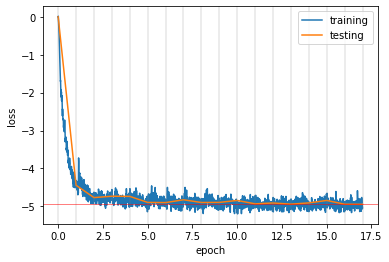

Batch:   0 Loss = -5.050898e+00,
Batch:  10 Loss = -4.946770e+00,
Batch:  20 Loss = -5.076207e+00,
Batch:  30 Loss = -5.057644e+00,
Batch:  40 Loss = -5.116497e+00,
Batch:  50 Loss = -4.948718e+00,
Batch:  60 Loss = -5.017471e+00,
Batch:  70 Loss = -4.938202e+00,
Batch:  80 Loss = -4.920891e+00,
Batch:  90 Loss = -4.964827e+00,
Batch: 100 Loss = -4.955899e+00,
Batch: 110 Loss = -4.852001e+00,
Batch: 120 Loss = -5.020354e+00,
Epoch:  17 Loss = -4.806901e+00, testing-loss = -4.908742e+00


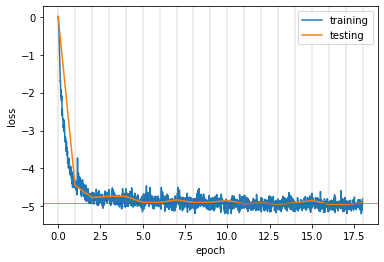

Batch:   0 Loss = -5.105894e+00,
Batch:  10 Loss = -4.784096e+00,
Batch:  20 Loss = -4.677281e+00,
Batch:  30 Loss = -5.024557e+00,
Batch:  40 Loss = -4.714085e+00,
Batch:  50 Loss = -4.943710e+00,
Batch:  60 Loss = -5.018277e+00,
Batch:  70 Loss = -4.909210e+00,
Batch:  80 Loss = -5.148254e+00,
Batch:  90 Loss = -5.065854e+00,
Batch: 100 Loss = -4.837180e+00,
Batch: 110 Loss = -4.871785e+00,
Batch: 120 Loss = -4.913963e+00,
Epoch:  18 Loss = -5.214190e+00, testing-loss = -4.954933e+00


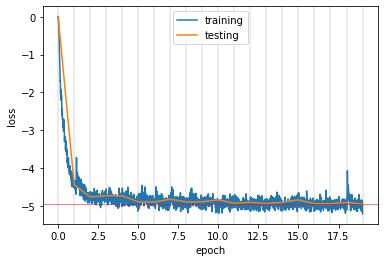

Batch:   0 Loss = -5.064845e+00,
Batch:  10 Loss = -5.007954e+00,
Batch:  20 Loss = -4.954225e+00,
Batch:  30 Loss = -5.034145e+00,
Batch:  40 Loss = -4.934660e+00,
Batch:  50 Loss = -5.039261e+00,
Batch:  60 Loss = -4.973368e+00,
Batch:  70 Loss = -4.820624e+00,
Batch:  80 Loss = -4.765506e+00,
Batch:  90 Loss = -4.799809e+00,
Batch: 100 Loss = -4.778533e+00,
Batch: 110 Loss = -4.869170e+00,
Batch: 120 Loss = -5.021154e+00,
Epoch:  19 Loss = -4.990937e+00, testing-loss = -4.945378e+00


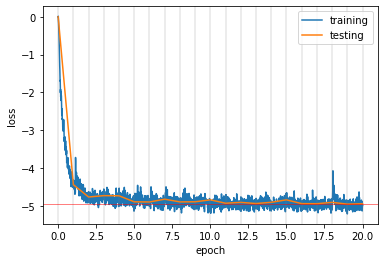

Batch:   0 Loss = -4.958484e+00,
Batch:  10 Loss = -4.928869e+00,
Batch:  20 Loss = -5.119512e+00,
Batch:  30 Loss = -4.964758e+00,
Batch:  40 Loss = -5.010729e+00,
Batch:  50 Loss = -4.987173e+00,
Batch:  60 Loss = -5.016349e+00,
Batch:  70 Loss = -5.071391e+00,
Batch:  80 Loss = -4.963765e+00,
Batch:  90 Loss = -5.030168e+00,
Batch: 100 Loss = -4.973864e+00,
Batch: 110 Loss = -4.941084e+00,
Batch: 120 Loss = -4.880625e+00,
Epoch:  20 Loss = -4.898593e+00, testing-loss = -4.936163e+00


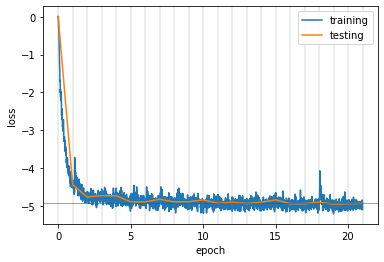

Batch:   0 Loss = -4.717886e+00,
Batch:  10 Loss = -5.029244e+00,
Batch:  20 Loss = -4.955150e+00,
Batch:  30 Loss = -5.003962e+00,
Batch:  40 Loss = -5.040007e+00,
Batch:  50 Loss = -4.886304e+00,
Batch:  60 Loss = -5.078569e+00,
Batch:  70 Loss = -4.929095e+00,
Batch:  80 Loss = -5.030221e+00,
Batch:  90 Loss = -5.033099e+00,
Batch: 100 Loss = -5.067094e+00,
Batch: 110 Loss = -4.900588e+00,
Batch: 120 Loss = -5.130604e+00,
Epoch:  21 Loss = -5.076229e+00, testing-loss = -4.894297e+00


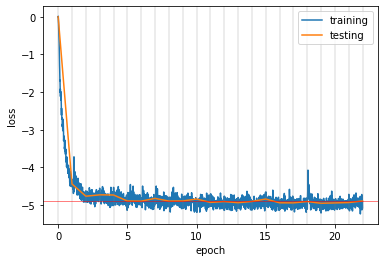

Batch:   0 Loss = -4.980321e+00,
Batch:  10 Loss = -4.939250e+00,
Batch:  20 Loss = -4.967765e+00,
Batch:  30 Loss = -4.924712e+00,
Batch:  40 Loss = -4.914205e+00,
Batch:  50 Loss = -4.916476e+00,
Batch:  60 Loss = -4.963348e+00,
Batch:  70 Loss = -4.973317e+00,
Batch:  80 Loss = -5.006963e+00,
Batch:  90 Loss = -5.152149e+00,
Batch: 100 Loss = -4.988503e+00,
Batch: 110 Loss = -4.971476e+00,
Batch: 120 Loss = -4.969178e+00,
Epoch:  22 Loss = -5.101542e+00, testing-loss = -4.952183e+00


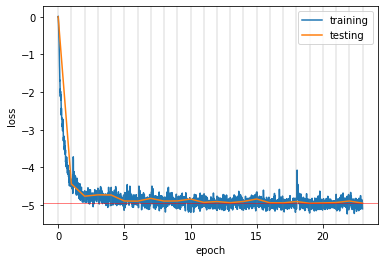

Batch:   0 Loss = -5.019203e+00,
Batch:  10 Loss = -4.998156e+00,
Batch:  20 Loss = -4.967093e+00,
Batch:  30 Loss = -4.943635e+00,
Batch:  40 Loss = -4.985827e+00,
Batch:  50 Loss = -4.995967e+00,
Batch:  60 Loss = -5.002189e+00,
Batch:  70 Loss = -5.106431e+00,
Batch:  80 Loss = -4.881043e+00,
Batch:  90 Loss = -5.031305e+00,
Batch: 100 Loss = -5.116574e+00,
Batch: 110 Loss = -4.947308e+00,
Batch: 120 Loss = -4.986931e+00,
Epoch:  23 Loss = -5.230266e+00, testing-loss = -4.930359e+00


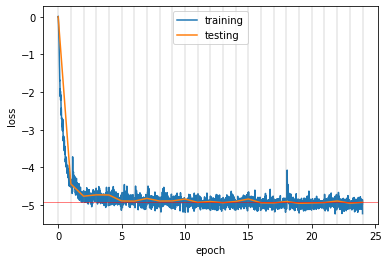

Batch:   0 Loss = -4.886068e+00,
Batch:  10 Loss = -4.978765e+00,
Batch:  20 Loss = -5.114368e+00,
Batch:  30 Loss = -5.032121e+00,
Batch:  40 Loss = -5.097617e+00,
Batch:  50 Loss = -4.985349e+00,
Batch:  60 Loss = -5.013905e+00,
Batch:  70 Loss = -4.890559e+00,
Batch:  80 Loss = -5.108557e+00,
Batch:  90 Loss = -4.906256e+00,
Batch: 100 Loss = -4.938342e+00,
Batch: 110 Loss = -4.893857e+00,
Batch: 120 Loss = -4.850022e+00,
Epoch:  24 Loss = -4.927126e+00, testing-loss = -4.968311e+00


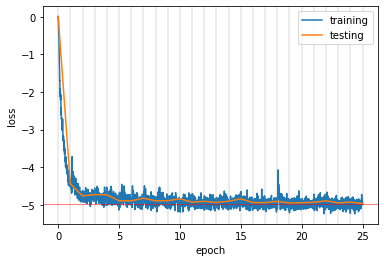

Batch:   0 Loss = -4.884366e+00,
Batch:  10 Loss = -5.072267e+00,
Batch:  20 Loss = -4.991518e+00,
Batch:  30 Loss = -4.951842e+00,
Batch:  40 Loss = -4.972709e+00,
Batch:  50 Loss = -4.902156e+00,
Batch:  60 Loss = -4.843894e+00,
Batch:  70 Loss = -4.871698e+00,
Batch:  80 Loss = -4.784402e+00,
Batch:  90 Loss = -5.013693e+00,
Batch: 100 Loss = -4.825900e+00,
Batch: 110 Loss = -4.918769e+00,
Batch: 120 Loss = -5.008427e+00,
Epoch:  25 Loss = -5.016399e+00, testing-loss = -4.956429e+00


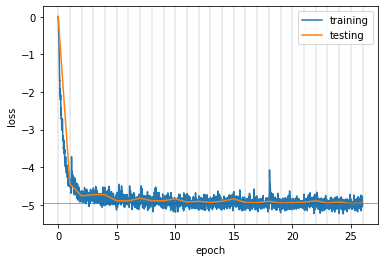

Batch:   0 Loss = -5.028465e+00,
Batch:  10 Loss = -5.219906e+00,
Batch:  20 Loss = -4.986910e+00,
Batch:  30 Loss = -4.883567e+00,
Batch:  40 Loss = -4.863890e+00,
Batch:  50 Loss = -5.172061e+00,
Batch:  60 Loss = -5.180914e+00,
Batch:  70 Loss = -4.851287e+00,
Batch:  80 Loss = -5.006600e+00,
Batch:  90 Loss = -4.823024e+00,
Batch: 100 Loss = -5.059706e+00,
Batch: 110 Loss = -4.923947e+00,
Batch: 120 Loss = -4.987658e+00,
Epoch:  26 Loss = -5.105628e+00, testing-loss = -4.936733e+00


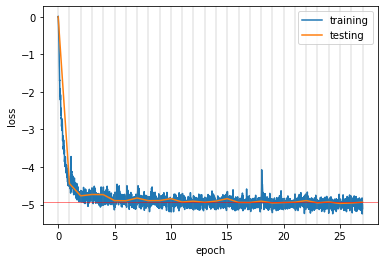

Batch:   0 Loss = -5.082156e+00,
Batch:  10 Loss = -4.971501e+00,
Batch:  20 Loss = -2.002082e+00,
Batch:  30 Loss = -2.850082e+00,
Batch:  40 Loss = -3.067138e+00,
Batch:  50 Loss = -3.590838e+00,
Batch:  60 Loss = -3.900853e+00,
Batch:  70 Loss = -4.153885e+00,
Batch:  80 Loss = -4.308101e+00,
Batch:  90 Loss = -4.289726e+00,
Batch: 100 Loss = -4.492001e+00,
Batch: 110 Loss = -4.727767e+00,
Batch: 120 Loss = -4.792375e+00,
Epoch:  27 Loss = -4.789949e+00, testing-loss = -4.635642e+00


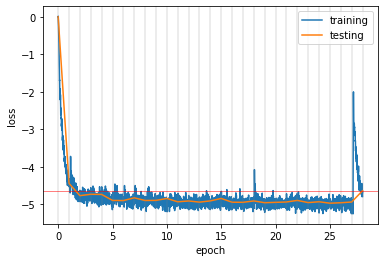

Batch:   0 Loss = -4.760603e+00,
Batch:  10 Loss = -4.812863e+00,
Batch:  20 Loss = -4.702139e+00,
Batch:  30 Loss = -4.827007e+00,
Batch:  40 Loss = -4.971517e+00,
Batch:  50 Loss = -4.628481e+00,
Batch:  60 Loss = -4.597186e+00,
Batch:  70 Loss = -4.715550e+00,
Batch:  80 Loss = -4.813535e+00,
Batch:  90 Loss = -4.787174e+00,
Batch: 100 Loss = -4.526008e+00,
Batch: 110 Loss = -4.769218e+00,
Batch: 120 Loss = -4.890460e+00,
Epoch:  28 Loss = -4.990790e+00, testing-loss = -4.787456e+00


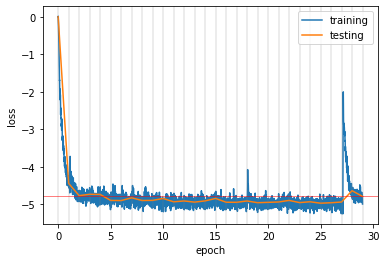

Batch:   0 Loss = -4.846854e+00,
Batch:  10 Loss = -4.944316e+00,
Batch:  20 Loss = -5.038365e+00,
Batch:  30 Loss = -4.952368e+00,
Batch:  40 Loss = -4.882554e+00,
Batch:  50 Loss = -4.951283e+00,
Batch:  60 Loss = -4.918576e+00,
Batch:  70 Loss = -4.890169e+00,
Batch:  80 Loss = -4.850131e+00,
Batch:  90 Loss = -4.974466e+00,
Batch: 100 Loss = -5.049009e+00,
Batch: 110 Loss = -4.834195e+00,
Batch: 120 Loss = -4.951750e+00,
Epoch:  29 Loss = -4.965811e+00, testing-loss = -4.877288e+00


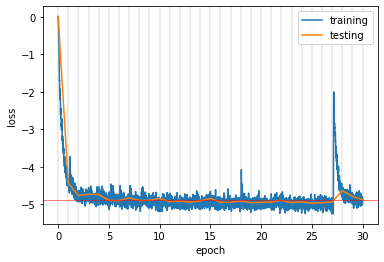

Batch:   0 Loss = -4.882950e+00,
Batch:  10 Loss = -4.923675e+00,
Batch:  20 Loss = -4.875101e+00,
Batch:  30 Loss = -5.024488e+00,
Batch:  40 Loss = -4.902402e+00,
Batch:  50 Loss = -4.947480e+00,
Batch:  60 Loss = -5.077694e+00,
Batch:  70 Loss = -4.927435e+00,
Batch:  80 Loss = -4.676085e+00,
Batch:  90 Loss = -4.856838e+00,
Batch: 100 Loss = -4.898400e+00,
Batch: 110 Loss = -4.850167e+00,
Batch: 120 Loss = -4.971301e+00,
Epoch:  30 Loss = -4.904600e+00, testing-loss = -4.877300e+00


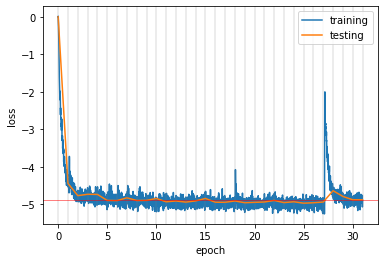

Batch:   0 Loss = -4.906829e+00,
Batch:  10 Loss = -4.824612e+00,
Batch:  20 Loss = -4.931228e+00,
Batch:  30 Loss = -4.895305e+00,
Batch:  40 Loss = -4.868531e+00,
Batch:  50 Loss = -5.008242e+00,
Batch:  60 Loss = -4.797189e+00,
Batch:  70 Loss = -4.880509e+00,
Batch:  80 Loss = -4.722782e+00,
Batch:  90 Loss = -4.952725e+00,
Batch: 100 Loss = -2.768429e+00,
Batch: 110 Loss = -3.854576e+00,
Batch: 120 Loss = -4.161276e+00,
Epoch:  31 Loss = -4.294631e+00, testing-loss = -4.413349e+00


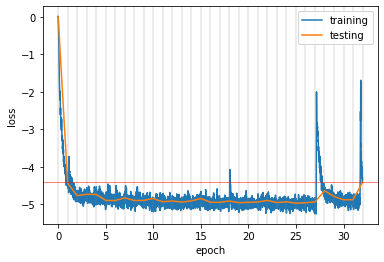

Batch:   0 Loss = -4.343680e+00,
Batch:  10 Loss = -4.685638e+00,
Batch:  20 Loss = -4.748508e+00,
Batch:  30 Loss = -4.808518e+00,
Batch:  40 Loss = -4.902077e+00,
Batch:  50 Loss = -4.825270e+00,
Batch:  60 Loss = -4.979478e+00,
Batch:  70 Loss = -4.893294e+00,
Batch:  80 Loss = -4.912935e+00,
Batch:  90 Loss = -4.751209e+00,
Batch: 100 Loss = -4.873674e+00,
Batch: 110 Loss = -4.892498e+00,
Batch: 120 Loss = -4.950603e+00,
Epoch:  32 Loss = -5.187007e+00, testing-loss = -4.893878e+00


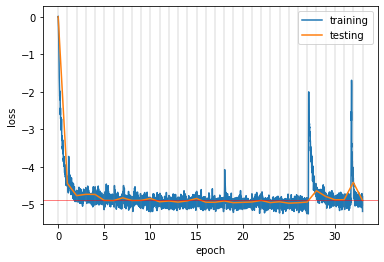

Batch:   0 Loss = -4.945664e+00,
Batch:  10 Loss = -4.948945e+00,
Batch:  20 Loss = -4.911844e+00,
Batch:  30 Loss = -5.076992e+00,
Batch:  40 Loss = -4.974115e+00,
Batch:  50 Loss = -5.005188e+00,
Batch:  60 Loss = -4.891437e+00,
Batch:  70 Loss = -4.954720e+00,
Batch:  80 Loss = -4.869422e+00,
Batch:  90 Loss = -4.760569e+00,
Batch: 100 Loss = -5.082424e+00,
Batch: 110 Loss = -4.867959e+00,
Batch: 120 Loss = -5.003948e+00,
Epoch:  33 Loss = -5.025308e+00, testing-loss = -4.903105e+00


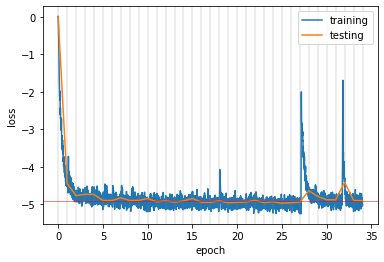

Batch:   0 Loss = -4.913759e+00,
Batch:  10 Loss = -4.896552e+00,
Batch:  20 Loss = -4.899449e+00,
Batch:  30 Loss = -4.789088e+00,
Batch:  40 Loss = -5.058828e+00,
Batch:  50 Loss = -4.854962e+00,
Batch:  60 Loss = -4.886169e+00,
Batch:  70 Loss = -4.934952e+00,
Batch:  80 Loss = -4.865235e+00,
Batch:  90 Loss = -4.971503e+00,
Batch: 100 Loss = -4.973654e+00,
Batch: 110 Loss = -4.882453e+00,
Batch: 120 Loss = -4.967073e+00,
Epoch:  34 Loss = -5.093829e+00, testing-loss = -4.904852e+00


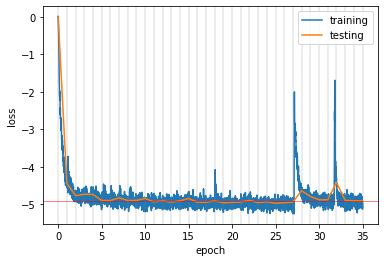

Batch:   0 Loss = -4.844482e+00,
Batch:  10 Loss = -4.903185e+00,
Batch:  20 Loss = -4.851711e+00,
Batch:  30 Loss = -4.864676e+00,
Batch:  40 Loss = -4.983877e+00,
Batch:  50 Loss = -5.087254e+00,
Batch:  60 Loss = -4.964785e+00,
Batch:  70 Loss = -4.909488e+00,
Batch:  80 Loss = -4.995073e+00,
Batch:  90 Loss = -4.944000e+00,
Batch: 100 Loss = -4.879435e+00,
Batch: 110 Loss = -4.960251e+00,
Batch: 120 Loss = -5.003558e+00,
Epoch:  35 Loss = -4.844442e+00, testing-loss = -4.880139e+00


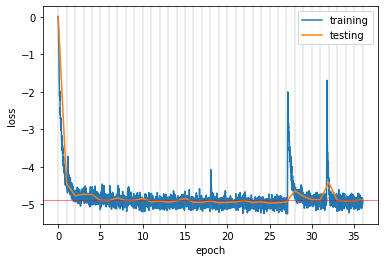

Batch:   0 Loss = -4.894980e+00,
Batch:  10 Loss = -5.037537e+00,
Batch:  20 Loss = -4.908380e+00,
Batch:  30 Loss = -5.036339e+00,
Batch:  40 Loss = -4.955937e+00,
Batch:  50 Loss = -4.775352e+00,
Batch:  60 Loss = -5.003038e+00,
Batch:  70 Loss = -4.938610e+00,
Batch:  80 Loss = -4.965393e+00,
Batch:  90 Loss = -4.766511e+00,
Batch: 100 Loss = -5.074480e+00,
Batch: 110 Loss = -5.052604e+00,
Batch: 120 Loss = -4.881982e+00,
Epoch:  36 Loss = -5.011815e+00, testing-loss = -4.920548e+00


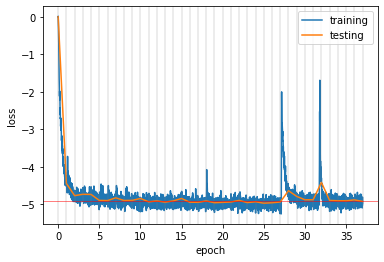

Batch:   0 Loss = -5.090533e+00,
Batch:  10 Loss = -4.852876e+00,
Batch:  20 Loss = -4.900831e+00,
Batch:  30 Loss = -4.973138e+00,
Batch:  40 Loss = -4.869659e+00,
Batch:  50 Loss = -5.152000e+00,
Batch:  60 Loss = -4.975084e+00,
Batch:  70 Loss = -5.084421e+00,
Batch:  80 Loss = -4.915605e+00,
Batch:  90 Loss = -4.908379e+00,
Batch: 100 Loss = -4.896117e+00,
Batch: 110 Loss = -4.993508e+00,
Batch: 120 Loss = -5.009926e+00,
Epoch:  37 Loss = -4.887348e+00, testing-loss = -4.932776e+00


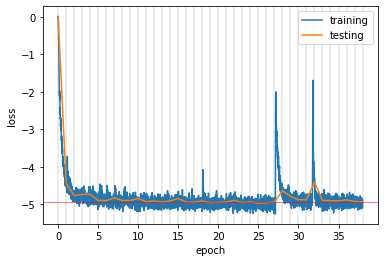

Batch:   0 Loss = -4.667591e+00,
Batch:  10 Loss = -4.986467e+00,
Batch:  20 Loss = -5.006481e+00,
Batch:  30 Loss = -4.992914e+00,
Batch:  40 Loss = -4.955674e+00,
Batch:  50 Loss = -4.825608e+00,
Batch:  60 Loss = -5.017193e+00,
Batch:  70 Loss = -4.972629e+00,
Batch:  80 Loss = -4.827186e+00,
Batch:  90 Loss = -4.959018e+00,
Batch: 100 Loss = -4.911420e+00,
Batch: 110 Loss = -4.896743e+00,
Batch: 120 Loss = -4.987966e+00,
Epoch:  38 Loss = -4.957648e+00, testing-loss = -4.937627e+00


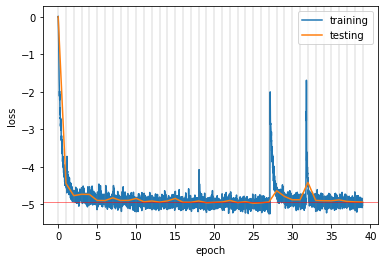

Batch:   0 Loss = -4.974555e+00,
Batch:  10 Loss = -4.838609e+00,
Batch:  20 Loss = -4.940905e+00,
Batch:  30 Loss = -5.045395e+00,
Batch:  40 Loss = -4.872637e+00,
Batch:  50 Loss = -4.948062e+00,
Batch:  60 Loss = -5.006441e+00,
Batch:  70 Loss = -4.898667e+00,
Batch:  80 Loss = -5.012314e+00,
Batch:  90 Loss = -4.898636e+00,
Batch: 100 Loss = -4.980199e+00,
Batch: 110 Loss = -4.967390e+00,
Batch: 120 Loss = -4.997068e+00,
Epoch:  39 Loss = -5.158766e+00, testing-loss = -4.912762e+00


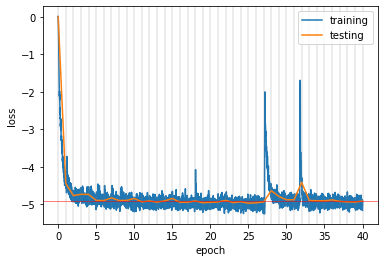

Batch:   0 Loss = -4.883710e+00,
Batch:  10 Loss = -4.988055e+00,
Batch:  20 Loss = -4.799167e+00,
Batch:  30 Loss = -4.993853e+00,
Batch:  40 Loss = -4.971222e+00,
Batch:  50 Loss = -4.970634e+00,
Batch:  60 Loss = -4.970654e+00,
Batch:  70 Loss = -4.933367e+00,
Batch:  80 Loss = -5.082702e+00,
Batch:  90 Loss = -5.154378e+00,
Batch: 100 Loss = -4.976546e+00,
Batch: 110 Loss = -4.985381e+00,
Batch: 120 Loss = -5.089232e+00,
Epoch:  40 Loss = -5.094359e+00, testing-loss = -4.933085e+00


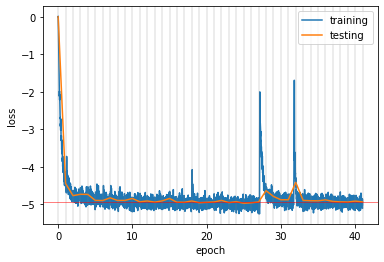

Batch:   0 Loss = -5.024664e+00,
Batch:  10 Loss = -5.052859e+00,
Batch:  20 Loss = -5.105389e+00,
Batch:  30 Loss = -4.857924e+00,
Batch:  40 Loss = -4.840151e+00,
Batch:  50 Loss = -4.948643e+00,
Batch:  60 Loss = -4.953663e+00,
Batch:  70 Loss = -4.988438e+00,
Batch:  80 Loss = -4.855616e+00,
Batch:  90 Loss = -4.777225e+00,
Batch: 100 Loss = -4.992574e+00,
Batch: 110 Loss = -4.931548e+00,
Batch: 120 Loss = -5.009552e+00,
Epoch:  41 Loss = -4.663688e+00, testing-loss = -4.929096e+00


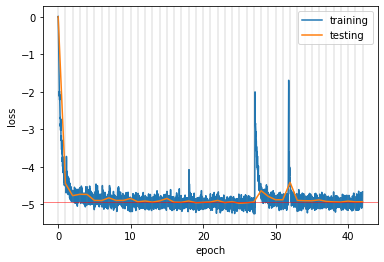

Batch:   0 Loss = -4.868403e+00,
Batch:  10 Loss = -4.897394e+00,
Batch:  20 Loss = -5.030934e+00,
Batch:  30 Loss = -5.064267e+00,
Batch:  40 Loss = -4.890672e+00,
Batch:  50 Loss = -4.955603e+00,
Batch:  60 Loss = -4.865941e+00,
Batch:  70 Loss = -4.968167e+00,
Batch:  80 Loss = -5.027388e+00,
Batch:  90 Loss = -5.028758e+00,
Batch: 100 Loss = -4.953814e+00,
Batch: 110 Loss = -4.914136e+00,
Batch: 120 Loss = -5.001799e+00,
Epoch:  42 Loss = -4.964386e+00, testing-loss = -4.929160e+00


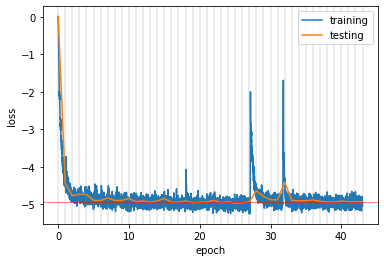

Batch:   0 Loss = -5.006447e+00,
Batch:  10 Loss = -5.164431e+00,
Batch:  20 Loss = -5.052785e+00,
Batch:  30 Loss = -5.038281e+00,
Batch:  40 Loss = -5.197955e+00,
Batch:  50 Loss = -4.884064e+00,
Batch:  60 Loss = -4.904884e+00,
Batch:  70 Loss = -5.004183e+00,
Batch:  80 Loss = -4.881331e+00,
Batch:  90 Loss = -5.081834e+00,
Batch: 100 Loss = -5.065239e+00,
Batch: 110 Loss = -4.867563e+00,
Batch: 120 Loss = -4.914703e+00,
Epoch:  43 Loss = -4.767378e+00, testing-loss = -4.934940e+00


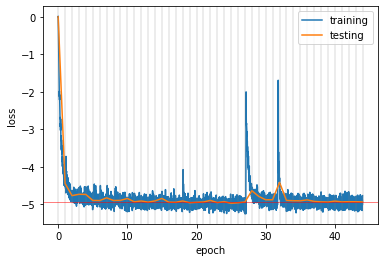

Batch:   0 Loss = -4.955531e+00,
Batch:  10 Loss = -5.155010e+00,
Batch:  20 Loss = -4.918615e+00,
Batch:  30 Loss = -4.959351e+00,
Batch:  40 Loss = -4.927818e+00,
Batch:  50 Loss = -4.977475e+00,
Batch:  60 Loss = -5.001634e+00,
Batch:  70 Loss = -5.112164e+00,
Batch:  80 Loss = -5.049886e+00,
Batch:  90 Loss = -5.115768e+00,
Batch: 100 Loss = -5.035935e+00,
Batch: 110 Loss = -4.961802e+00,
Batch: 120 Loss = -4.814698e+00,
Epoch:  44 Loss = -4.839957e+00, testing-loss = -4.937700e+00


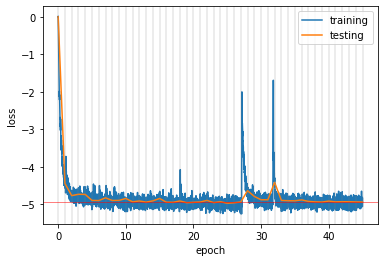

Batch:   0 Loss = -4.935870e+00,
Batch:  10 Loss = -4.913735e+00,
Batch:  20 Loss = -4.920530e+00,
Batch:  30 Loss = -5.128073e+00,
Batch:  40 Loss = -4.852530e+00,
Batch:  50 Loss = -4.882846e+00,
Batch:  60 Loss = -4.975927e+00,
Batch:  70 Loss = -5.009192e+00,
Batch:  80 Loss = -4.935323e+00,
Batch:  90 Loss = -4.869629e+00,
Batch: 100 Loss = -5.018253e+00,
Batch: 110 Loss = -4.944382e+00,
Batch: 120 Loss = -4.981631e+00,
Epoch:  45 Loss = -4.977963e+00, testing-loss = -4.943636e+00


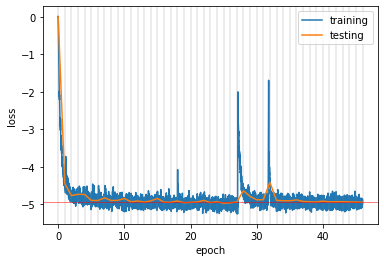

Batch:   0 Loss = -4.908418e+00,
Batch:  10 Loss = -4.989927e+00,
Batch:  20 Loss = -5.050121e+00,
Batch:  30 Loss = -4.655819e+00,
Batch:  40 Loss = -4.873327e+00,
Batch:  50 Loss = -4.840376e+00,
Batch:  60 Loss = -4.848633e+00,
Batch:  70 Loss = -5.132566e+00,
Batch:  80 Loss = -4.914186e+00,
Batch:  90 Loss = -5.093294e+00,
Batch: 100 Loss = -4.850372e+00,
Batch: 110 Loss = -4.925418e+00,
Batch: 120 Loss = -4.991856e+00,
Epoch:  46 Loss = -4.887848e+00, testing-loss = -4.938755e+00


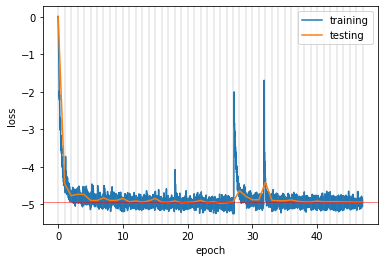

Batch:   0 Loss = -5.039279e+00,
Batch:  10 Loss = -4.873256e+00,
Batch:  20 Loss = -5.034782e+00,
Batch:  30 Loss = -5.084968e+00,
Batch:  40 Loss = -4.934949e+00,
Batch:  50 Loss = -4.890970e+00,
Batch:  60 Loss = -4.975952e+00,
Batch:  70 Loss = -4.857011e+00,
Batch:  80 Loss = -5.011966e+00,
Batch:  90 Loss = -4.914029e+00,
Batch: 100 Loss = -4.923332e+00,
Batch: 110 Loss = -4.942346e+00,
Batch: 120 Loss = -5.068361e+00,
Epoch:  47 Loss = -4.960775e+00, testing-loss = -4.930744e+00


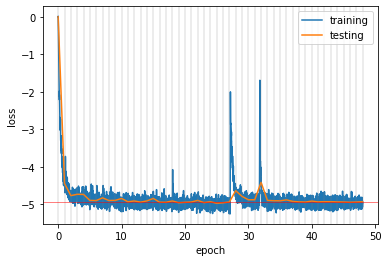

Batch:   0 Loss = -4.733946e+00,
Batch:  10 Loss = -4.877800e+00,
Batch:  20 Loss = -5.181477e+00,
Batch:  30 Loss = -4.973963e+00,
Batch:  40 Loss = -4.894572e+00,
Batch:  50 Loss = -5.033882e+00,
Batch:  60 Loss = -4.917252e+00,
Batch:  70 Loss = -4.914147e+00,
Batch:  80 Loss = -5.014264e+00,
Batch:  90 Loss = -4.939446e+00,
Batch: 100 Loss = -5.084497e+00,
Batch: 110 Loss = -4.965568e+00,
Batch: 120 Loss = -4.911351e+00,
Epoch:  48 Loss = -4.936538e+00, testing-loss = -4.902516e+00


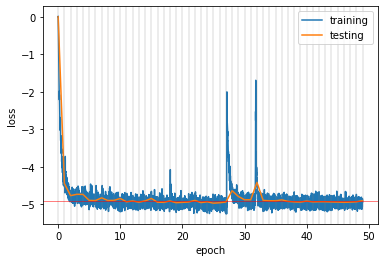

Batch:   0 Loss = -4.993904e+00,
Batch:  10 Loss = -5.054727e+00,
Batch:  20 Loss = -4.897615e+00,
Batch:  30 Loss = -4.956637e+00,
Batch:  40 Loss = -4.884611e+00,
Batch:  50 Loss = -4.834285e+00,
Batch:  60 Loss = -4.703056e+00,
Batch:  70 Loss = -4.827389e+00,
Batch:  80 Loss = -4.836718e+00,
Batch:  90 Loss = -4.862448e+00,
Batch: 100 Loss = -4.890667e+00,
Batch: 110 Loss = -4.966007e+00,
Batch: 120 Loss = -4.929382e+00,
Epoch:  49 Loss = -4.873491e+00, testing-loss = -4.884745e+00


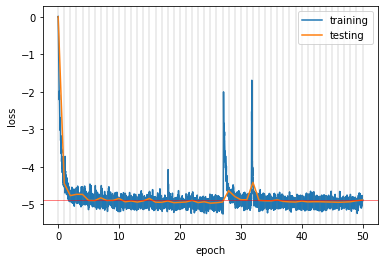

In [18]:
sig_epochs = 50
sigdist, losses, test_losses =train_iflow(combined.drop(columns='signal') ,M=3500, deltaM=200,
                                         issig=True, batchsize=256, lr=1e-3, epochs=sig_epochs,
                                         weight_decay=1e-4)

Model loaded successfully
Model loaded successfully
Model loaded successfully
Model loaded successfully
Model loaded successfully
Model loaded successfully
Model loaded successfully
Model loaded successfully
Model loaded successfully
Model loaded successfully


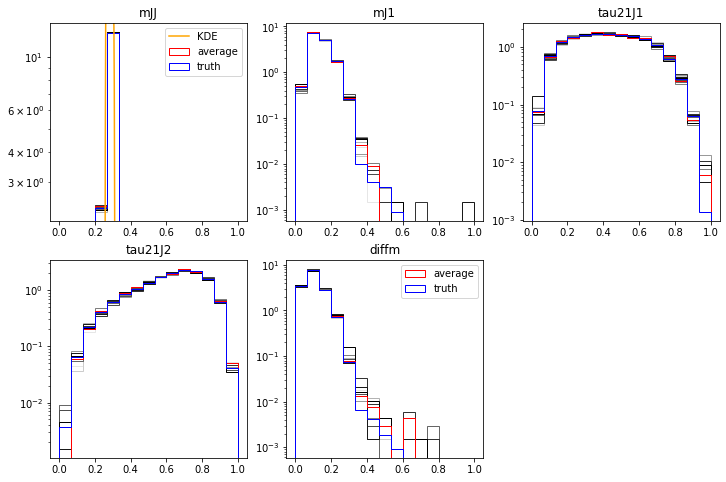

In [19]:
last_epochs = np.arange(sig_epochs-10, sig_epochs)
last_epochs = last_epochs[last_epochs >= 0]
plot_learned_distributions(sigdist, last_epochs, 'sig_', 10000,
                           truth=data_sig_train.drop(columns='signal'), special_dim=0)

### Train on side band

efficiency in SR when cutting edges of hypercube: 0.45
167876 events available for training
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)                256       
_________________________________________________________________
batch_normalization_16 (Batc (None, 64)                256       
_________________________________________________________________
dense_25 (Dense)             (None, 128)               8320      
_________________________________________________________________
batch_normalization_17 (Batc (None, 128)               512       
_________________________________________________________________
dense_26 (Dense)             (None, 128)               16512     
_________________________________

Batch: 260 Loss = -4.544819e+00,
Batch: 270 Loss = -4.673498e+00,
Batch: 280 Loss = -4.955272e+00,
Batch: 290 Loss = -4.896644e+00,
Batch: 300 Loss = -4.991806e+00,
Batch: 310 Loss = -4.953867e+00,
Batch: 320 Loss = -4.951286e+00,
Batch: 330 Loss = -5.015326e+00,
Batch: 340 Loss = -4.967883e+00,
Batch: 350 Loss = -5.246065e+00,
Batch: 360 Loss = -4.846066e+00,
Batch: 370 Loss = -4.789161e+00,
Batch: 380 Loss = -5.043410e+00,
Batch: 390 Loss = -4.963381e+00,
Batch: 400 Loss = -4.932748e+00,
Batch: 410 Loss = -5.036416e+00,
Batch: 420 Loss = -5.243113e+00,
Batch: 430 Loss = -5.075736e+00,
Batch: 440 Loss = -5.208000e+00,
Batch: 450 Loss = -5.135000e+00,
Batch: 460 Loss = -5.264794e+00,
Batch: 470 Loss = -5.214123e+00,
Batch: 480 Loss = -5.120772e+00,
Batch: 490 Loss = -5.182710e+00,
Batch: 500 Loss = -4.980716e+00,
Batch: 510 Loss = -4.994113e+00,
Batch: 520 Loss = -5.086878e+00,
Batch: 530 Loss = -5.154095e+00,
Batch: 540 Loss = -5.078962e+00,
Batch: 550 Loss = -5.099487e+00,
Batch: 560

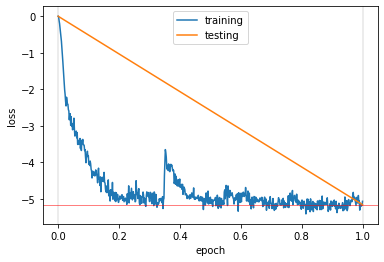

Batch:   0 Loss = -5.027340e+00,
Batch:  10 Loss = -5.046773e+00,
Batch:  20 Loss = -5.231041e+00,
Batch:  30 Loss = -5.116221e+00,
Batch:  40 Loss = -5.244434e+00,
Batch:  50 Loss = -5.065717e+00,
Batch:  60 Loss = -4.809282e+00,
Batch:  70 Loss = -4.951533e+00,
Batch:  80 Loss = -5.208061e+00,
Batch:  90 Loss = -4.862763e+00,
Batch: 100 Loss = -5.202063e+00,
Batch: 110 Loss = -5.145492e+00,
Batch: 120 Loss = -5.278908e+00,
Batch: 130 Loss = -5.198677e+00,
Batch: 140 Loss = -5.084058e+00,
Batch: 150 Loss = -4.909079e+00,
Batch: 160 Loss = -5.129031e+00,
Batch: 170 Loss = -5.078238e+00,
Batch: 180 Loss = -4.998728e+00,
Batch: 190 Loss = -5.134187e+00,
Batch: 200 Loss = -5.337953e+00,
Batch: 210 Loss = -5.156283e+00,
Batch: 220 Loss = -5.046993e+00,
Batch: 230 Loss = -5.227113e+00,
Batch: 240 Loss = -5.295069e+00,
Batch: 250 Loss = -5.112678e+00,
Batch: 260 Loss = -5.310922e+00,
Batch: 270 Loss = -5.103387e+00,
Batch: 280 Loss = -5.177056e+00,
Batch: 290 Loss = -5.221080e+00,
Batch: 300

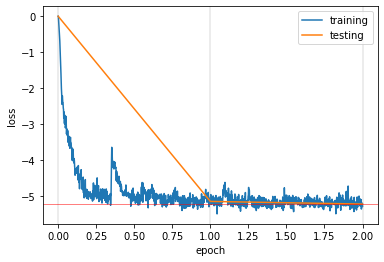

Batch:   0 Loss = -5.204409e+00,
Batch:  10 Loss = -5.295546e+00,
Batch:  20 Loss = -5.230708e+00,
Batch:  30 Loss = -5.145861e+00,
Batch:  40 Loss = -5.316343e+00,
Batch:  50 Loss = -5.276588e+00,
Batch:  60 Loss = -5.160693e+00,
Batch:  70 Loss = -5.036934e+00,
Batch:  80 Loss = -5.263035e+00,
Batch:  90 Loss = -5.143473e+00,
Batch: 100 Loss = -5.304980e+00,
Batch: 110 Loss = -5.099107e+00,
Batch: 120 Loss = -5.366683e+00,
Batch: 130 Loss = -5.249575e+00,
Batch: 140 Loss = -5.260849e+00,
Batch: 150 Loss = -5.335667e+00,
Batch: 160 Loss = -5.159538e+00,
Batch: 170 Loss = -5.154343e+00,
Batch: 180 Loss = -5.040077e+00,
Batch: 190 Loss = -5.263221e+00,
Batch: 200 Loss = -5.306171e+00,
Batch: 210 Loss = -5.251028e+00,
Batch: 220 Loss = -5.065995e+00,
Batch: 230 Loss = -5.357087e+00,
Batch: 240 Loss = -5.006329e+00,
Batch: 250 Loss = -5.195341e+00,
Batch: 260 Loss = -5.250164e+00,
Batch: 270 Loss = -5.244422e+00,
Batch: 280 Loss = -5.338590e+00,
Batch: 290 Loss = -5.283075e+00,
Batch: 300

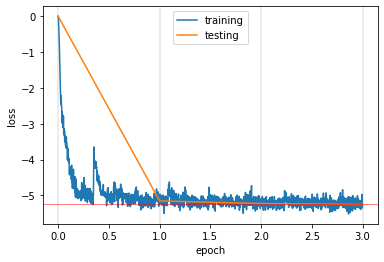

Batch:   0 Loss = -5.356888e+00,
Batch:  10 Loss = -5.014862e+00,
Batch:  20 Loss = -5.264171e+00,
Batch:  30 Loss = -5.326212e+00,
Batch:  40 Loss = -5.300512e+00,
Batch:  50 Loss = -5.130791e+00,
Batch:  60 Loss = -5.252528e+00,
Batch:  70 Loss = -5.217624e+00,
Batch:  80 Loss = -5.267923e+00,
Batch:  90 Loss = -5.092842e+00,
Batch: 100 Loss = -5.246461e+00,
Batch: 110 Loss = -5.061083e+00,
Batch: 120 Loss = -5.153344e+00,
Batch: 130 Loss = -5.374457e+00,
Batch: 140 Loss = -5.124546e+00,
Batch: 150 Loss = -5.230675e+00,
Batch: 160 Loss = -5.003319e+00,
Batch: 170 Loss = -4.944630e+00,
Batch: 180 Loss = -5.191957e+00,
Batch: 190 Loss = -5.127747e+00,
Batch: 200 Loss = -5.307959e+00,
Batch: 210 Loss = -5.222843e+00,
Batch: 220 Loss = -5.236969e+00,
Batch: 230 Loss = -5.262006e+00,
Batch: 240 Loss = -5.164884e+00,
Batch: 250 Loss = -5.258627e+00,
Batch: 260 Loss = -5.183560e+00,
Batch: 270 Loss = -5.257890e+00,
Batch: 280 Loss = -5.189226e+00,
Batch: 290 Loss = -5.207787e+00,
Batch: 300

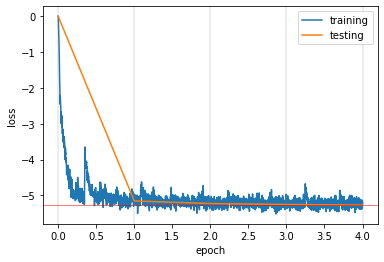

Batch:   0 Loss = -5.410083e+00,
Batch:  10 Loss = -5.055253e+00,
Batch:  20 Loss = -5.130648e+00,
Batch:  30 Loss = -5.263250e+00,
Batch:  40 Loss = -5.310960e+00,
Batch:  50 Loss = -5.138547e+00,
Batch:  60 Loss = -5.369248e+00,
Batch:  70 Loss = -5.054878e+00,
Batch:  80 Loss = -5.184982e+00,
Batch:  90 Loss = -5.209098e+00,
Batch: 100 Loss = -5.190751e+00,
Batch: 110 Loss = -5.391904e+00,
Batch: 120 Loss = -5.204951e+00,
Batch: 130 Loss = -5.086478e+00,
Batch: 140 Loss = -5.371943e+00,
Batch: 150 Loss = -5.019518e+00,
Batch: 160 Loss = -4.955851e+00,
Batch: 170 Loss = -4.977113e+00,
Batch: 180 Loss = -5.043193e+00,
Batch: 190 Loss = -5.095485e+00,
Batch: 200 Loss = -5.126900e+00,
Batch: 210 Loss = -5.027584e+00,
Batch: 220 Loss = -5.249342e+00,
Batch: 230 Loss = -5.285574e+00,
Batch: 240 Loss = -5.090082e+00,
Batch: 250 Loss = -5.092137e+00,
Batch: 260 Loss = -5.230806e+00,
Batch: 270 Loss = -5.150561e+00,
Batch: 280 Loss = -5.357736e+00,
Batch: 290 Loss = -5.197795e+00,
Batch: 300

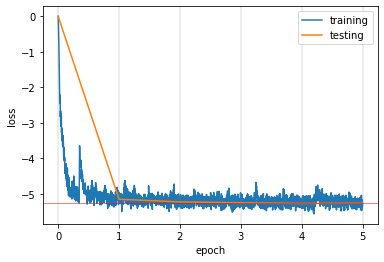

Batch:   0 Loss = -5.217599e+00,
Batch:  10 Loss = -5.250812e+00,
Batch:  20 Loss = -5.222638e+00,
Batch:  30 Loss = -5.091544e+00,
Batch:  40 Loss = -5.289448e+00,
Batch:  50 Loss = -5.415025e+00,
Batch:  60 Loss = -5.257513e+00,
Batch:  70 Loss = -5.212546e+00,
Batch:  80 Loss = -5.313772e+00,
Batch:  90 Loss = -5.274456e+00,
Batch: 100 Loss = -5.386317e+00,
Batch: 110 Loss = -5.263003e+00,
Batch: 120 Loss = -5.362136e+00,
Batch: 130 Loss = -5.223985e+00,
Batch: 140 Loss = -5.210555e+00,
Batch: 150 Loss = -5.225748e+00,
Batch: 160 Loss = -5.354335e+00,
Batch: 170 Loss = -5.176053e+00,
Batch: 180 Loss = -5.133873e+00,
Batch: 190 Loss = -5.437074e+00,
Batch: 200 Loss = -5.322021e+00,
Batch: 210 Loss = -5.412770e+00,
Batch: 220 Loss = -5.267451e+00,
Batch: 230 Loss = -5.004591e+00,
Batch: 240 Loss = -5.398094e+00,
Batch: 250 Loss = -5.405151e+00,
Batch: 260 Loss = -5.043103e+00,
Batch: 270 Loss = -5.250007e+00,
Batch: 280 Loss = -5.329754e+00,
Batch: 290 Loss = -5.405606e+00,
Batch: 300

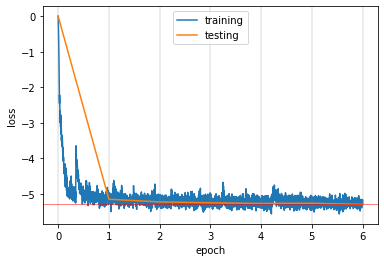

Batch:   0 Loss = -5.228011e+00,
Batch:  10 Loss = -5.186318e+00,
Batch:  20 Loss = -5.224314e+00,
Batch:  30 Loss = -5.294168e+00,
Batch:  40 Loss = -5.393205e+00,
Batch:  50 Loss = -5.207289e+00,
Batch:  60 Loss = -5.408702e+00,
Batch:  70 Loss = -5.340270e+00,
Batch:  80 Loss = -5.176521e+00,
Batch:  90 Loss = -5.349250e+00,
Batch: 100 Loss = -5.257694e+00,
Batch: 110 Loss = -5.218315e+00,
Batch: 120 Loss = -5.241104e+00,
Batch: 130 Loss = -5.299677e+00,
Batch: 140 Loss = -5.192902e+00,
Batch: 150 Loss = -5.243791e+00,
Batch: 160 Loss = -5.202398e+00,
Batch: 170 Loss = -5.260135e+00,
Batch: 180 Loss = -5.208569e+00,
Batch: 190 Loss = -5.124333e+00,
Batch: 200 Loss = -5.373564e+00,
Batch: 210 Loss = -5.244131e+00,
Batch: 220 Loss = -5.155632e+00,
Batch: 230 Loss = -5.336789e+00,
Batch: 240 Loss = -5.334282e+00,
Batch: 250 Loss = -5.095745e+00,
Batch: 260 Loss = -5.284842e+00,
Batch: 270 Loss = -5.268779e+00,
Batch: 280 Loss = -5.235993e+00,
Batch: 290 Loss = -5.209277e+00,
Batch: 300

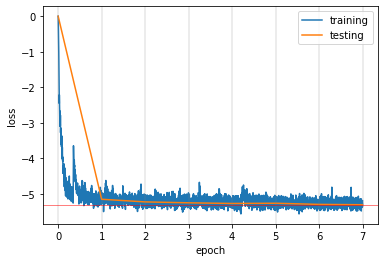

Batch:   0 Loss = -5.115307e+00,
Batch:  10 Loss = -5.356394e+00,
Batch:  20 Loss = -5.221937e+00,
Batch:  30 Loss = -5.093138e+00,
Batch:  40 Loss = -5.276452e+00,
Batch:  50 Loss = -5.312704e+00,
Batch:  60 Loss = -5.062476e+00,
Batch:  70 Loss = -5.445437e+00,
Batch:  80 Loss = -5.304990e+00,
Batch:  90 Loss = -5.418781e+00,
Batch: 100 Loss = -5.339494e+00,
Batch: 110 Loss = -5.283974e+00,
Batch: 120 Loss = -5.191623e+00,
Batch: 130 Loss = -5.357855e+00,
Batch: 140 Loss = -5.269700e+00,
Batch: 150 Loss = -5.251730e+00,
Batch: 160 Loss = -5.255986e+00,
Batch: 170 Loss = -5.291380e+00,
Batch: 180 Loss = -5.299731e+00,
Batch: 190 Loss = -5.248817e+00,
Batch: 200 Loss = -5.201373e+00,
Batch: 210 Loss = -5.344946e+00,
Batch: 220 Loss = -5.231998e+00,
Batch: 230 Loss = -5.375528e+00,
Batch: 240 Loss = -5.202939e+00,
Batch: 250 Loss = -5.272732e+00,
Batch: 260 Loss = -5.438994e+00,
Batch: 270 Loss = -5.235519e+00,
Batch: 280 Loss = -5.225190e+00,
Batch: 290 Loss = -5.386622e+00,
Batch: 300

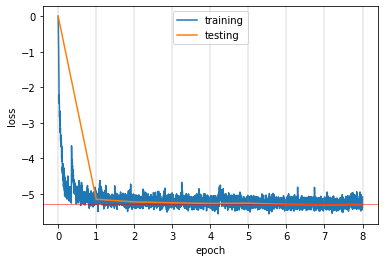

Batch:   0 Loss = -5.229434e+00,
Batch:  10 Loss = -5.460713e+00,
Batch:  20 Loss = -5.468220e+00,
Batch:  30 Loss = -5.214556e+00,
Batch:  40 Loss = -5.486441e+00,
Batch:  50 Loss = -5.598518e+00,
Batch:  60 Loss = -5.259614e+00,
Batch:  70 Loss = -5.285343e+00,
Batch:  80 Loss = -5.191083e+00,
Batch:  90 Loss = -5.178922e+00,
Batch: 100 Loss = -5.222207e+00,
Batch: 110 Loss = -5.324320e+00,
Batch: 120 Loss = -5.177659e+00,
Batch: 130 Loss = -5.390949e+00,
Batch: 140 Loss = -5.461597e+00,
Batch: 150 Loss = -5.354123e+00,
Batch: 160 Loss = -5.343501e+00,
Batch: 170 Loss = -5.128177e+00,
Batch: 180 Loss = -5.267792e+00,
Batch: 190 Loss = -5.370584e+00,
Batch: 200 Loss = -5.353135e+00,
Batch: 210 Loss = -5.270381e+00,
Batch: 220 Loss = -5.247076e+00,
Batch: 230 Loss = -5.241797e+00,
Batch: 240 Loss = -5.208254e+00,
Batch: 250 Loss = -5.273093e+00,
Batch: 260 Loss = -5.354717e+00,
Batch: 270 Loss = -5.354298e+00,
Batch: 280 Loss = -5.294833e+00,
Batch: 290 Loss = -5.229370e+00,
Batch: 300

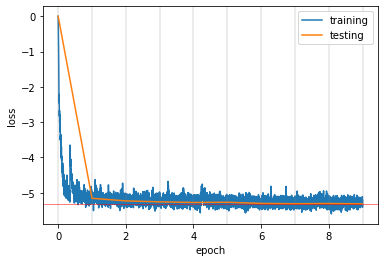

Batch:   0 Loss = -5.296439e+00,
Batch:  10 Loss = -5.401690e+00,
Batch:  20 Loss = -5.312151e+00,
Batch:  30 Loss = -5.348124e+00,
Batch:  40 Loss = -5.307314e+00,
Batch:  50 Loss = -5.485515e+00,
Batch:  60 Loss = -5.259579e+00,
Batch:  70 Loss = -5.232120e+00,
Batch:  80 Loss = -5.125820e+00,
Batch:  90 Loss = -5.373530e+00,
Batch: 100 Loss = -5.294287e+00,
Batch: 110 Loss = -5.425664e+00,
Batch: 120 Loss = -5.271821e+00,
Batch: 130 Loss = -5.255102e+00,
Batch: 140 Loss = -5.317316e+00,
Batch: 150 Loss = -5.377451e+00,
Batch: 160 Loss = -5.159927e+00,
Batch: 170 Loss = -5.421516e+00,
Batch: 180 Loss = -5.086716e+00,
Batch: 190 Loss = -5.084436e+00,
Batch: 200 Loss = -5.241729e+00,
Batch: 210 Loss = -5.469236e+00,
Batch: 220 Loss = -5.133872e+00,
Batch: 230 Loss = -5.191902e+00,
Batch: 240 Loss = -5.351156e+00,
Batch: 250 Loss = -5.308420e+00,
Batch: 260 Loss = -5.234343e+00,
Batch: 270 Loss = -5.255618e+00,
Batch: 280 Loss = -5.374666e+00,
Batch: 290 Loss = -5.178017e+00,
Batch: 300

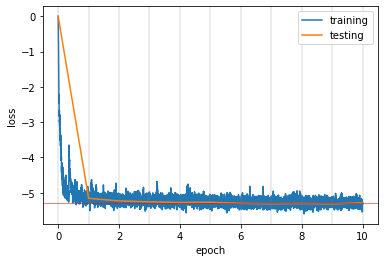

Batch:   0 Loss = -5.348419e+00,
Batch:  10 Loss = -5.422878e+00,
Batch:  20 Loss = -5.199311e+00,
Batch:  30 Loss = -5.358479e+00,
Batch:  40 Loss = -5.306916e+00,
Batch:  50 Loss = -5.224930e+00,
Batch:  60 Loss = -5.336398e+00,
Batch:  70 Loss = -5.489593e+00,
Batch:  80 Loss = -5.398576e+00,
Batch:  90 Loss = -5.242752e+00,
Batch: 100 Loss = -5.195038e+00,
Batch: 110 Loss = -5.242754e+00,
Batch: 120 Loss = -5.162132e+00,
Batch: 130 Loss = -5.255474e+00,
Batch: 140 Loss = -5.211115e+00,
Batch: 150 Loss = -5.253201e+00,
Batch: 160 Loss = -5.258658e+00,
Batch: 170 Loss = -5.221439e+00,
Batch: 180 Loss = -5.330888e+00,
Batch: 190 Loss = -5.366061e+00,
Batch: 200 Loss = -5.433925e+00,
Batch: 210 Loss = -5.336040e+00,
Batch: 220 Loss = -5.284969e+00,
Batch: 230 Loss = -5.412809e+00,
Batch: 240 Loss = -5.226284e+00,
Batch: 250 Loss = -5.374077e+00,
Batch: 260 Loss = -5.283454e+00,
Batch: 270 Loss = -5.198121e+00,
Batch: 280 Loss = -5.264927e+00,
Batch: 290 Loss = -5.209311e+00,
Batch: 300

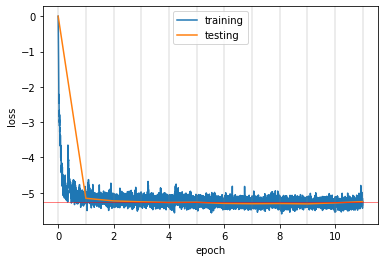

Batch:   0 Loss = -5.289910e+00,
Batch:  10 Loss = -5.482515e+00,
Batch:  20 Loss = -5.567607e+00,
Batch:  30 Loss = -5.104764e+00,
Batch:  40 Loss = -5.472200e+00,
Batch:  50 Loss = -5.344787e+00,
Batch:  60 Loss = -5.260890e+00,
Batch:  70 Loss = -5.260947e+00,
Batch:  80 Loss = -5.373071e+00,
Batch:  90 Loss = -5.431470e+00,
Batch: 100 Loss = -5.413968e+00,
Batch: 110 Loss = -5.422877e+00,
Batch: 120 Loss = -5.256016e+00,
Batch: 130 Loss = -5.195159e+00,
Batch: 140 Loss = -5.396982e+00,
Batch: 150 Loss = -5.414675e+00,
Batch: 160 Loss = -5.179970e+00,
Batch: 170 Loss = -5.376839e+00,
Batch: 180 Loss = -5.352540e+00,
Batch: 190 Loss = -5.362003e+00,
Batch: 200 Loss = -5.374700e+00,
Batch: 210 Loss = -5.299169e+00,
Batch: 220 Loss = -5.386126e+00,
Batch: 230 Loss = -5.295719e+00,
Batch: 240 Loss = -5.296595e+00,
Batch: 250 Loss = -5.214958e+00,
Batch: 260 Loss = -5.299583e+00,
Batch: 270 Loss = -5.304828e+00,
Batch: 280 Loss = -5.218565e+00,
Batch: 290 Loss = -5.356275e+00,
Batch: 300

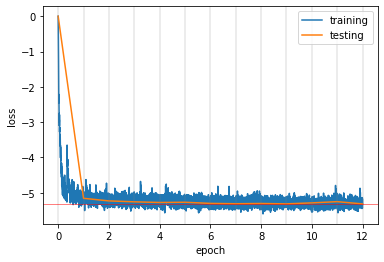

Batch:   0 Loss = -5.383564e+00,
Batch:  10 Loss = -5.181503e+00,
Batch:  20 Loss = -5.317980e+00,
Batch:  30 Loss = -5.382019e+00,
Batch:  40 Loss = -5.426770e+00,
Batch:  50 Loss = -5.365579e+00,
Batch:  60 Loss = -5.265483e+00,
Batch:  70 Loss = -5.187740e+00,
Batch:  80 Loss = -5.459515e+00,
Batch:  90 Loss = -5.272630e+00,
Batch: 100 Loss = -5.474329e+00,
Batch: 110 Loss = -5.235446e+00,
Batch: 120 Loss = -5.295404e+00,
Batch: 130 Loss = -5.174270e+00,
Batch: 140 Loss = -5.258721e+00,
Batch: 150 Loss = -5.237826e+00,
Batch: 160 Loss = -5.214715e+00,
Batch: 170 Loss = -5.393765e+00,
Batch: 180 Loss = -5.266659e+00,
Batch: 190 Loss = -5.347524e+00,
Batch: 200 Loss = -5.323186e+00,
Batch: 210 Loss = -5.286256e+00,
Batch: 220 Loss = -5.436317e+00,
Batch: 230 Loss = -5.279772e+00,
Batch: 240 Loss = -5.258922e+00,
Batch: 250 Loss = -5.392387e+00,
Batch: 260 Loss = -5.331975e+00,
Batch: 270 Loss = -5.455033e+00,
Batch: 280 Loss = -5.221889e+00,
Batch: 290 Loss = -5.075155e+00,
Batch: 300

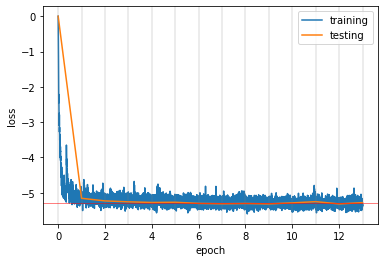

Batch:   0 Loss = -5.405912e+00,
Batch:  10 Loss = -5.357083e+00,
Batch:  20 Loss = -5.431436e+00,
Batch:  30 Loss = -5.356266e+00,
Batch:  40 Loss = -5.302560e+00,
Batch:  50 Loss = -5.368282e+00,
Batch:  60 Loss = -5.309441e+00,
Batch:  70 Loss = -5.230653e+00,
Batch:  80 Loss = -5.245057e+00,
Batch:  90 Loss = -5.217696e+00,
Batch: 100 Loss = -5.225438e+00,
Batch: 110 Loss = -5.338066e+00,
Batch: 120 Loss = -5.216455e+00,
Batch: 130 Loss = -5.110890e+00,
Batch: 140 Loss = -5.296763e+00,
Batch: 150 Loss = -5.372997e+00,
Batch: 160 Loss = -5.331052e+00,
Batch: 170 Loss = -5.441023e+00,
Batch: 180 Loss = -5.184585e+00,
Batch: 190 Loss = -5.224185e+00,
Batch: 200 Loss = -5.389037e+00,
Batch: 210 Loss = -5.146858e+00,
Batch: 220 Loss = -5.335746e+00,
Batch: 230 Loss = -5.335080e+00,
Batch: 240 Loss = -5.404793e+00,
Batch: 250 Loss = -5.356436e+00,
Batch: 260 Loss = -5.296914e+00,
Batch: 270 Loss = -5.466334e+00,
Batch: 280 Loss = -5.461015e+00,
Batch: 290 Loss = -5.048759e+00,
Batch: 300

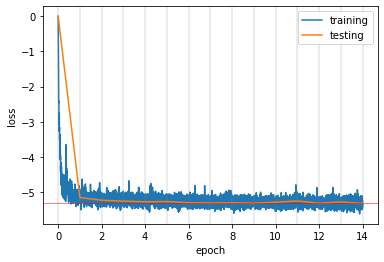

Batch:   0 Loss = -5.356014e+00,
Batch:  10 Loss = -5.454226e+00,
Batch:  20 Loss = -5.449803e+00,
Batch:  30 Loss = -5.303351e+00,
Batch:  40 Loss = -5.343105e+00,
Batch:  50 Loss = -5.249569e+00,
Batch:  60 Loss = -5.368303e+00,
Batch:  70 Loss = -5.302740e+00,
Batch:  80 Loss = -5.224039e+00,
Batch:  90 Loss = -5.169322e+00,
Batch: 100 Loss = -5.295578e+00,
Batch: 110 Loss = -5.240077e+00,
Batch: 120 Loss = -5.322112e+00,
Batch: 130 Loss = -5.379485e+00,
Batch: 140 Loss = -5.329855e+00,
Batch: 150 Loss = -5.182211e+00,
Batch: 160 Loss = -5.329220e+00,
Batch: 170 Loss = -5.435410e+00,
Batch: 180 Loss = -5.247906e+00,
Batch: 190 Loss = -5.279566e+00,
Batch: 200 Loss = -5.416707e+00,
Batch: 210 Loss = -5.381450e+00,
Batch: 220 Loss = -5.323102e+00,
Batch: 230 Loss = -5.270882e+00,
Batch: 240 Loss = -5.420824e+00,
Batch: 250 Loss = -5.081391e+00,
Batch: 260 Loss = -5.284934e+00,
Batch: 270 Loss = -5.245543e+00,
Batch: 280 Loss = -5.364963e+00,
Batch: 290 Loss = -5.415068e+00,
Batch: 300

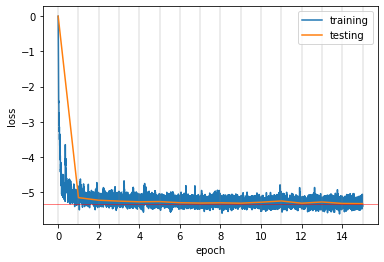

Batch:   0 Loss = -5.420077e+00,
Batch:  10 Loss = -5.276830e+00,
Batch:  20 Loss = -5.153942e+00,
Batch:  30 Loss = -5.345973e+00,
Batch:  40 Loss = -5.237426e+00,
Batch:  50 Loss = -5.223013e+00,
Batch:  60 Loss = -5.076137e+00,
Batch:  70 Loss = -5.243726e+00,
Batch:  80 Loss = -5.099623e+00,
Batch:  90 Loss = -5.165674e+00,
Batch: 100 Loss = -5.213571e+00,
Batch: 110 Loss = -5.258138e+00,
Batch: 120 Loss = -5.123394e+00,
Batch: 130 Loss = -5.234234e+00,
Batch: 140 Loss = -5.144531e+00,
Batch: 150 Loss = -5.400119e+00,
Batch: 160 Loss = -5.173964e+00,
Batch: 170 Loss = -5.199158e+00,
Batch: 180 Loss = -5.103147e+00,
Batch: 190 Loss = -5.198593e+00,
Batch: 200 Loss = -5.065577e+00,
Batch: 210 Loss = -5.374126e+00,
Batch: 220 Loss = -5.335514e+00,
Batch: 230 Loss = -5.400119e+00,
Batch: 240 Loss = -5.350193e+00,
Batch: 250 Loss = -5.227755e+00,
Batch: 260 Loss = -5.337631e+00,
Batch: 270 Loss = -5.346486e+00,
Batch: 280 Loss = -5.288146e+00,
Batch: 290 Loss = -5.295089e+00,
Batch: 300

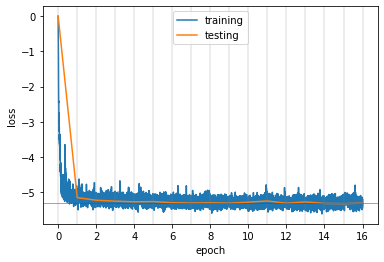

Batch:   0 Loss = -5.230654e+00,
Batch:  10 Loss = -5.292327e+00,
Batch:  20 Loss = -5.297278e+00,
Batch:  30 Loss = -5.430876e+00,
Batch:  40 Loss = -5.369505e+00,
Batch:  50 Loss = -5.337483e+00,
Batch:  60 Loss = -5.396184e+00,
Batch:  70 Loss = -5.447668e+00,
Batch:  80 Loss = -5.331689e+00,
Batch:  90 Loss = -5.263756e+00,
Batch: 100 Loss = -5.361061e+00,
Batch: 110 Loss = -5.344949e+00,
Batch: 120 Loss = -5.339692e+00,
Batch: 130 Loss = -5.411818e+00,
Batch: 140 Loss = -5.126889e+00,
Batch: 150 Loss = -5.420383e+00,
Batch: 160 Loss = -5.160321e+00,
Batch: 170 Loss = -5.290230e+00,
Batch: 180 Loss = -5.313832e+00,
Batch: 190 Loss = -5.118831e+00,
Batch: 200 Loss = -5.324383e+00,
Batch: 210 Loss = -5.218311e+00,
Batch: 220 Loss = -5.335853e+00,
Batch: 230 Loss = -5.359222e+00,
Batch: 240 Loss = -5.204974e+00,
Batch: 250 Loss = -5.380467e+00,
Batch: 260 Loss = -5.183708e+00,
Batch: 270 Loss = -5.265312e+00,
Batch: 280 Loss = -5.245019e+00,
Batch: 290 Loss = -5.363343e+00,
Batch: 300

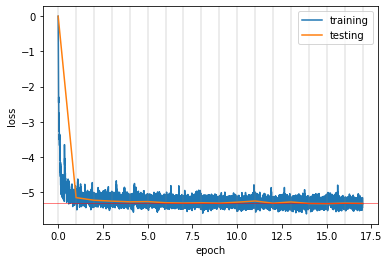

Batch:   0 Loss = -5.376063e+00,
Batch:  10 Loss = -5.287393e+00,
Batch:  20 Loss = -5.210699e+00,
Batch:  30 Loss = -5.302026e+00,
Batch:  40 Loss = -5.239129e+00,
Batch:  50 Loss = -5.261422e+00,
Batch:  60 Loss = -5.332289e+00,
Batch:  70 Loss = -5.217860e+00,
Batch:  80 Loss = -5.245506e+00,
Batch:  90 Loss = -5.266014e+00,
Batch: 100 Loss = -5.330651e+00,
Batch: 110 Loss = -5.113392e+00,
Batch: 120 Loss = -5.397038e+00,
Batch: 130 Loss = -5.384490e+00,
Batch: 140 Loss = -5.362908e+00,
Batch: 150 Loss = -5.422466e+00,
Batch: 160 Loss = -5.252060e+00,
Batch: 170 Loss = -5.292576e+00,
Batch: 180 Loss = -5.281926e+00,
Batch: 190 Loss = -5.338931e+00,
Batch: 200 Loss = -5.276034e+00,
Batch: 210 Loss = -5.371810e+00,
Batch: 220 Loss = -5.280375e+00,
Batch: 230 Loss = -5.289068e+00,
Batch: 240 Loss = -5.442379e+00,
Batch: 250 Loss = -5.388197e+00,
Batch: 260 Loss = -5.449874e+00,
Batch: 270 Loss = -5.407178e+00,
Batch: 280 Loss = -5.280582e+00,
Batch: 290 Loss = -5.355538e+00,
Batch: 300

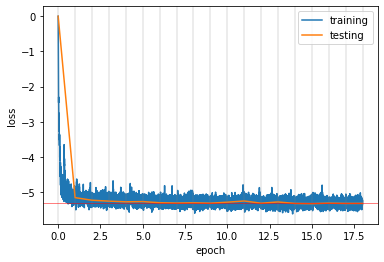

Batch:   0 Loss = -5.304356e+00,
Batch:  10 Loss = -5.470330e+00,
Batch:  20 Loss = -5.127329e+00,
Batch:  30 Loss = -5.160094e+00,
Batch:  40 Loss = -5.181417e+00,
Batch:  50 Loss = -5.240948e+00,
Batch:  60 Loss = -5.206384e+00,
Batch:  70 Loss = -5.415749e+00,
Batch:  80 Loss = -5.248377e+00,
Batch:  90 Loss = -5.301759e+00,
Batch: 100 Loss = -5.152638e+00,
Batch: 110 Loss = -5.302558e+00,
Batch: 120 Loss = -5.401626e+00,
Batch: 130 Loss = -5.236558e+00,
Batch: 140 Loss = -5.330334e+00,
Batch: 150 Loss = -5.245057e+00,
Batch: 160 Loss = -5.221148e+00,
Batch: 170 Loss = -5.305260e+00,
Batch: 180 Loss = -5.170619e+00,
Batch: 190 Loss = -5.190349e+00,
Batch: 200 Loss = -5.249221e+00,
Batch: 210 Loss = -5.307418e+00,
Batch: 220 Loss = -5.342899e+00,
Batch: 230 Loss = -5.248691e+00,
Batch: 240 Loss = -5.291465e+00,
Batch: 250 Loss = -5.298376e+00,
Batch: 260 Loss = -5.133844e+00,
Batch: 270 Loss = -5.210734e+00,
Batch: 280 Loss = -5.196777e+00,
Batch: 290 Loss = -5.421682e+00,
Batch: 300

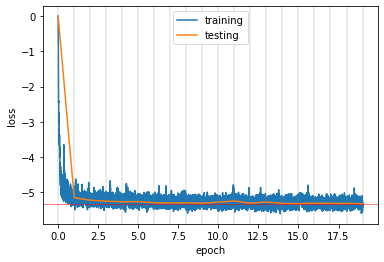

Batch:   0 Loss = -5.225813e+00,
Batch:  10 Loss = -5.263180e+00,
Batch:  20 Loss = -5.355298e+00,
Batch:  30 Loss = -5.352081e+00,
Batch:  40 Loss = -5.314003e+00,
Batch:  50 Loss = -5.371849e+00,
Batch:  60 Loss = -5.326599e+00,
Batch:  70 Loss = -5.295993e+00,
Batch:  80 Loss = -5.268469e+00,
Batch:  90 Loss = -5.110380e+00,
Batch: 100 Loss = -5.324355e+00,
Batch: 110 Loss = -5.197945e+00,
Batch: 120 Loss = -5.149692e+00,
Batch: 130 Loss = -5.007618e+00,
Batch: 140 Loss = -5.273489e+00,
Batch: 150 Loss = -5.300436e+00,
Batch: 160 Loss = -5.295558e+00,
Batch: 170 Loss = -5.328014e+00,
Batch: 180 Loss = -5.257856e+00,
Batch: 190 Loss = -5.220892e+00,
Batch: 200 Loss = -5.238916e+00,
Batch: 210 Loss = -5.012468e+00,
Batch: 220 Loss = -5.179915e+00,
Batch: 230 Loss = -5.242843e+00,
Batch: 240 Loss = -5.322908e+00,
Batch: 250 Loss = -5.350142e+00,
Batch: 260 Loss = -5.195367e+00,
Batch: 270 Loss = -5.244520e+00,
Batch: 280 Loss = -5.364797e+00,
Batch: 290 Loss = -5.471067e+00,
Batch: 300

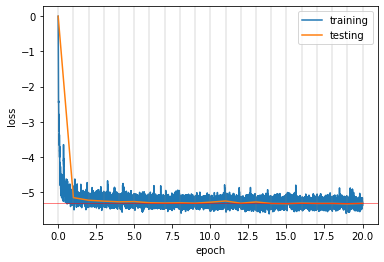

Batch:   0 Loss = -5.274358e+00,
Batch:  10 Loss = -5.207129e+00,
Batch:  20 Loss = -5.301122e+00,
Batch:  30 Loss = -5.297060e+00,
Batch:  40 Loss = -5.309980e+00,
Batch:  50 Loss = -5.230955e+00,
Batch:  60 Loss = -5.206916e+00,
Batch:  70 Loss = -5.243622e+00,
Batch:  80 Loss = -5.308983e+00,
Batch:  90 Loss = -5.264174e+00,
Batch: 100 Loss = -5.524350e+00,
Batch: 110 Loss = -5.323870e+00,
Batch: 120 Loss = -5.245957e+00,
Batch: 130 Loss = -5.309185e+00,
Batch: 140 Loss = -5.266332e+00,
Batch: 150 Loss = -5.339574e+00,
Batch: 160 Loss = -5.206319e+00,
Batch: 170 Loss = -4.886735e+00,
Batch: 180 Loss = -5.133734e+00,
Batch: 190 Loss = -4.964716e+00,
Batch: 200 Loss = -5.067360e+00,
Batch: 210 Loss = -5.032282e+00,
Batch: 220 Loss = -5.068436e+00,
Batch: 230 Loss = -5.153885e+00,
Batch: 240 Loss = -5.258958e+00,
Batch: 250 Loss = -5.051496e+00,
Batch: 260 Loss = -5.301962e+00,
Batch: 270 Loss = -5.306235e+00,
Batch: 280 Loss = -5.016334e+00,
Batch: 290 Loss = -5.297025e+00,
Batch: 300

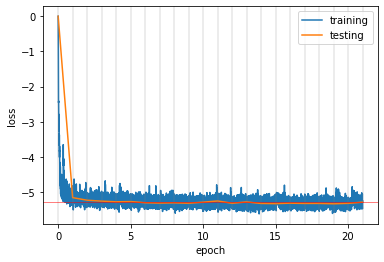

Batch:   0 Loss = -5.223472e+00,
Batch:  10 Loss = -5.243645e+00,
Batch:  20 Loss = -5.315589e+00,
Batch:  30 Loss = -5.304379e+00,
Batch:  40 Loss = -5.312868e+00,
Batch:  50 Loss = -5.404395e+00,
Batch:  60 Loss = -5.293290e+00,
Batch:  70 Loss = -5.104336e+00,
Batch:  80 Loss = -5.332393e+00,
Batch:  90 Loss = -5.382750e+00,
Batch: 100 Loss = -5.361487e+00,
Batch: 110 Loss = -5.286701e+00,
Batch: 120 Loss = -5.342228e+00,
Batch: 130 Loss = -5.347321e+00,
Batch: 140 Loss = -5.319054e+00,
Batch: 150 Loss = -5.362030e+00,
Batch: 160 Loss = -5.279484e+00,
Batch: 170 Loss = -5.474872e+00,
Batch: 180 Loss = -5.254940e+00,
Batch: 190 Loss = -5.242193e+00,
Batch: 200 Loss = -5.374414e+00,
Batch: 210 Loss = -5.454023e+00,
Batch: 220 Loss = -5.345709e+00,
Batch: 230 Loss = -5.336007e+00,
Batch: 240 Loss = -5.337039e+00,
Batch: 250 Loss = -5.310882e+00,
Batch: 260 Loss = -5.223895e+00,
Batch: 270 Loss = -5.413276e+00,
Batch: 280 Loss = -5.261304e+00,
Batch: 290 Loss = -5.189606e+00,
Batch: 300

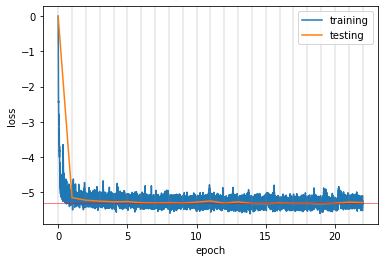

Batch:   0 Loss = -5.271863e+00,
Batch:  10 Loss = -5.295622e+00,
Batch:  20 Loss = -5.150990e+00,
Batch:  30 Loss = -5.303632e+00,
Batch:  40 Loss = -5.340927e+00,
Batch:  50 Loss = -5.296115e+00,
Batch:  60 Loss = -5.308102e+00,
Batch:  70 Loss = -5.370901e+00,
Batch:  80 Loss = -5.098958e+00,
Batch:  90 Loss = -5.206344e+00,
Batch: 100 Loss = -5.265307e+00,
Batch: 110 Loss = -5.494458e+00,
Batch: 120 Loss = -5.292139e+00,
Batch: 130 Loss = -5.122294e+00,
Batch: 140 Loss = -5.219799e+00,
Batch: 150 Loss = -5.304178e+00,
Batch: 160 Loss = -5.334404e+00,
Batch: 170 Loss = -5.352927e+00,
Batch: 180 Loss = -5.243948e+00,
Batch: 190 Loss = -5.121834e+00,
Batch: 200 Loss = -5.301194e+00,
Batch: 210 Loss = -5.356098e+00,
Batch: 220 Loss = -5.114980e+00,
Batch: 230 Loss = -5.356871e+00,
Batch: 240 Loss = -5.243101e+00,
Batch: 250 Loss = -5.304523e+00,
Batch: 260 Loss = -5.242707e+00,
Batch: 270 Loss = -5.462892e+00,
Batch: 280 Loss = -5.301737e+00,
Batch: 290 Loss = -5.181474e+00,
Batch: 300

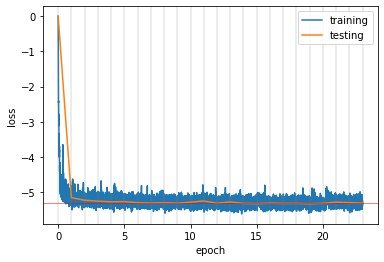

Batch:   0 Loss = -5.197576e+00,
Batch:  10 Loss = -5.271157e+00,
Batch:  20 Loss = -5.195906e+00,
Batch:  30 Loss = -5.373679e+00,
Batch:  40 Loss = -5.178367e+00,
Batch:  50 Loss = -5.370758e+00,
Batch:  60 Loss = -5.144620e+00,
Batch:  70 Loss = -5.181807e+00,
Batch:  80 Loss = -5.337903e+00,
Batch:  90 Loss = -5.407437e+00,
Batch: 100 Loss = -5.461719e+00,
Batch: 110 Loss = -5.421208e+00,
Batch: 120 Loss = -5.345285e+00,
Batch: 130 Loss = -5.387664e+00,
Batch: 140 Loss = -5.450252e+00,
Batch: 150 Loss = -5.567898e+00,
Batch: 160 Loss = -5.366111e+00,
Batch: 170 Loss = -5.270404e+00,
Batch: 180 Loss = -5.275621e+00,
Batch: 190 Loss = -5.353049e+00,
Batch: 200 Loss = -5.206044e+00,
Batch: 210 Loss = -5.349166e+00,
Batch: 220 Loss = -5.249726e+00,
Batch: 230 Loss = -5.240696e+00,
Batch: 240 Loss = -5.273086e+00,
Batch: 250 Loss = -5.448931e+00,
Batch: 260 Loss = -5.323746e+00,
Batch: 270 Loss = -5.316387e+00,
Batch: 280 Loss = -5.348139e+00,
Batch: 290 Loss = -5.308474e+00,
Batch: 300

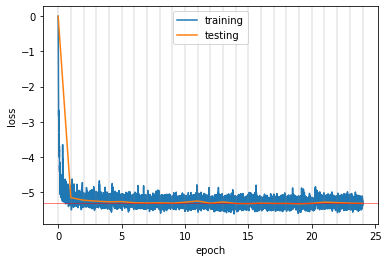

Batch:   0 Loss = -5.446105e+00,
Batch:  10 Loss = -5.240495e+00,
Batch:  20 Loss = -5.255687e+00,
Batch:  30 Loss = -5.387294e+00,
Batch:  40 Loss = -5.366286e+00,
Batch:  50 Loss = -5.366411e+00,
Batch:  60 Loss = -5.241408e+00,
Batch:  70 Loss = -5.249868e+00,
Batch:  80 Loss = -5.468552e+00,
Batch:  90 Loss = -5.304383e+00,
Batch: 100 Loss = -5.313682e+00,
Batch: 110 Loss = -5.283679e+00,
Batch: 120 Loss = -5.325970e+00,
Batch: 130 Loss = -5.240677e+00,
Batch: 140 Loss = -5.261052e+00,
Batch: 150 Loss = -5.245098e+00,
Batch: 160 Loss = -5.026400e+00,
Batch: 170 Loss = -5.367307e+00,
Batch: 180 Loss = -5.305996e+00,
Batch: 190 Loss = -5.298695e+00,
Batch: 200 Loss = -5.412097e+00,
Batch: 210 Loss = -5.259391e+00,
Batch: 220 Loss = -5.352220e+00,
Batch: 230 Loss = -5.419289e+00,
Batch: 240 Loss = -5.358053e+00,
Batch: 250 Loss = -5.301996e+00,
Batch: 260 Loss = -5.158542e+00,
Batch: 270 Loss = -5.406034e+00,
Batch: 280 Loss = -5.283316e+00,
Batch: 290 Loss = -5.372533e+00,
Batch: 300

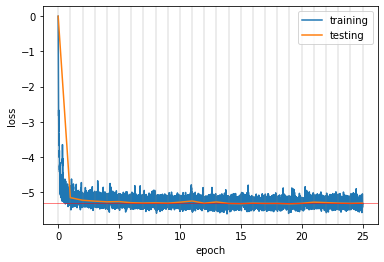

Batch:   0 Loss = -5.265120e+00,
Batch:  10 Loss = -5.283591e+00,
Batch:  20 Loss = -5.426165e+00,
Batch:  30 Loss = -5.320273e+00,
Batch:  40 Loss = -5.363337e+00,
Batch:  50 Loss = -5.414942e+00,
Batch:  60 Loss = -5.367274e+00,
Batch:  70 Loss = -5.208026e+00,
Batch:  80 Loss = -5.436675e+00,
Batch:  90 Loss = -5.448948e+00,
Batch: 100 Loss = -5.323071e+00,
Batch: 110 Loss = -5.326473e+00,
Batch: 120 Loss = -5.417842e+00,
Batch: 130 Loss = -5.194202e+00,
Batch: 140 Loss = -5.315678e+00,
Batch: 150 Loss = -5.157215e+00,
Batch: 160 Loss = -5.320642e+00,
Batch: 170 Loss = -5.379308e+00,
Batch: 180 Loss = -5.217417e+00,
Batch: 190 Loss = -5.400342e+00,
Batch: 200 Loss = -5.468223e+00,
Batch: 210 Loss = -5.360138e+00,
Batch: 220 Loss = -5.321566e+00,
Batch: 230 Loss = -5.436008e+00,
Batch: 240 Loss = -5.318962e+00,
Batch: 250 Loss = -5.296368e+00,
Batch: 260 Loss = -5.160575e+00,
Batch: 270 Loss = -5.424116e+00,
Batch: 280 Loss = -5.310572e+00,
Batch: 290 Loss = -5.239780e+00,
Batch: 300

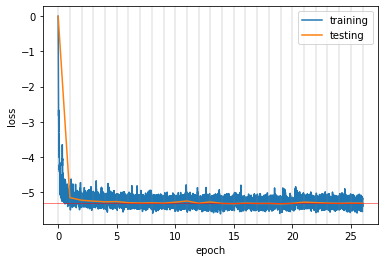

Batch:   0 Loss = -5.180918e+00,
Batch:  10 Loss = -5.395077e+00,
Batch:  20 Loss = -5.261601e+00,
Batch:  30 Loss = -5.315223e+00,
Batch:  40 Loss = -5.435796e+00,
Batch:  50 Loss = -5.399275e+00,
Batch:  60 Loss = -5.222857e+00,
Batch:  70 Loss = -5.400776e+00,
Batch:  80 Loss = -5.301675e+00,
Batch:  90 Loss = -5.247568e+00,
Batch: 100 Loss = -5.411774e+00,
Batch: 110 Loss = -5.396277e+00,
Batch: 120 Loss = -5.269476e+00,
Batch: 130 Loss = -5.123494e+00,
Batch: 140 Loss = -5.246098e+00,
Batch: 150 Loss = -5.348270e+00,
Batch: 160 Loss = -5.395530e+00,
Batch: 170 Loss = -5.213324e+00,
Batch: 180 Loss = -5.262925e+00,
Batch: 190 Loss = -5.175920e+00,
Batch: 200 Loss = -5.292415e+00,
Batch: 210 Loss = -5.215579e+00,
Batch: 220 Loss = -5.314463e+00,
Batch: 230 Loss = -5.187252e+00,
Batch: 240 Loss = -5.270691e+00,
Batch: 250 Loss = -5.203666e+00,
Batch: 260 Loss = -5.375513e+00,
Batch: 270 Loss = -5.229565e+00,
Batch: 280 Loss = -5.271705e+00,
Batch: 290 Loss = -5.213222e+00,
Batch: 300

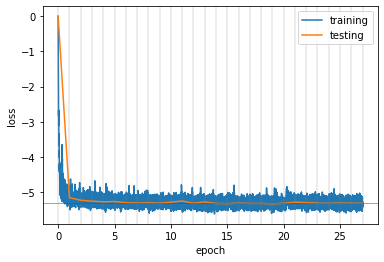

Batch:   0 Loss = -5.243409e+00,
Batch:  10 Loss = -5.351065e+00,
Batch:  20 Loss = -5.392261e+00,
Batch:  30 Loss = -5.310165e+00,
Batch:  40 Loss = -5.326090e+00,
Batch:  50 Loss = -5.253625e+00,
Batch:  60 Loss = -5.186487e+00,
Batch:  70 Loss = -5.454546e+00,
Batch:  80 Loss = -5.089945e+00,
Batch:  90 Loss = -5.344908e+00,
Batch: 100 Loss = -5.440021e+00,
Batch: 110 Loss = -5.279639e+00,
Batch: 120 Loss = -5.372702e+00,
Batch: 130 Loss = -5.312592e+00,
Batch: 140 Loss = -5.367144e+00,
Batch: 150 Loss = -5.306901e+00,
Batch: 160 Loss = -5.394314e+00,
Batch: 170 Loss = -5.366581e+00,
Batch: 180 Loss = -5.338201e+00,
Batch: 190 Loss = -5.469399e+00,
Batch: 200 Loss = -5.306928e+00,
Batch: 210 Loss = -5.408207e+00,
Batch: 220 Loss = -5.201930e+00,
Batch: 230 Loss = -5.352983e+00,
Batch: 240 Loss = -5.312510e+00,
Batch: 250 Loss = -5.313934e+00,
Batch: 260 Loss = -5.406978e+00,
Batch: 270 Loss = -5.328042e+00,
Batch: 280 Loss = -5.274403e+00,
Batch: 290 Loss = -5.339532e+00,
Batch: 300

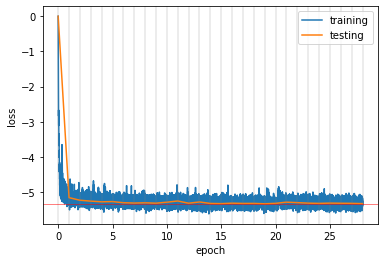

Batch:   0 Loss = -5.310284e+00,
Batch:  10 Loss = -5.319117e+00,
Batch:  20 Loss = -5.227192e+00,
Batch:  30 Loss = -5.264598e+00,
Batch:  40 Loss = -5.348081e+00,
Batch:  50 Loss = -5.345491e+00,
Batch:  60 Loss = -5.316990e+00,
Batch:  70 Loss = -5.405034e+00,
Batch:  80 Loss = -5.322940e+00,
Batch:  90 Loss = -5.357707e+00,
Batch: 100 Loss = -5.236146e+00,
Batch: 110 Loss = -5.323933e+00,
Batch: 120 Loss = -5.381521e+00,
Batch: 130 Loss = -5.531636e+00,
Batch: 140 Loss = -5.485015e+00,
Batch: 150 Loss = -5.286287e+00,
Batch: 160 Loss = -5.209222e+00,
Batch: 170 Loss = -5.256793e+00,
Batch: 180 Loss = -5.347274e+00,
Batch: 190 Loss = -5.277572e+00,
Batch: 200 Loss = -5.242657e+00,
Batch: 210 Loss = -5.081517e+00,
Batch: 220 Loss = -5.289884e+00,
Batch: 230 Loss = -5.279128e+00,
Batch: 240 Loss = -5.206060e+00,
Batch: 250 Loss = -5.371528e+00,
Batch: 260 Loss = -5.391773e+00,
Batch: 270 Loss = -5.400931e+00,
Batch: 280 Loss = -5.273434e+00,
Batch: 290 Loss = -5.329003e+00,
Batch: 300

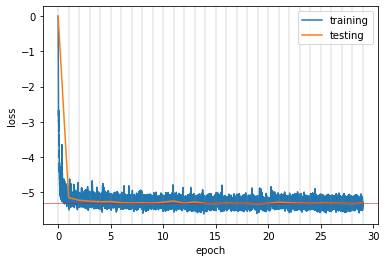

Batch:   0 Loss = -5.281406e+00,
Batch:  10 Loss = -5.202771e+00,
Batch:  20 Loss = -5.179893e+00,
Batch:  30 Loss = -5.174481e+00,
Batch:  40 Loss = -5.317965e+00,
Batch:  50 Loss = -5.400410e+00,
Batch:  60 Loss = -5.392232e+00,
Batch:  70 Loss = -5.381424e+00,
Batch:  80 Loss = -5.356589e+00,
Batch:  90 Loss = -5.313570e+00,
Batch: 100 Loss = -5.126013e+00,
Batch: 110 Loss = -5.360723e+00,
Batch: 120 Loss = -5.306399e+00,
Batch: 130 Loss = -5.401837e+00,
Batch: 140 Loss = -5.467292e+00,
Batch: 150 Loss = -5.290939e+00,
Batch: 160 Loss = -5.292667e+00,
Batch: 170 Loss = -5.263212e+00,
Batch: 180 Loss = -5.354652e+00,
Batch: 190 Loss = -5.246100e+00,
Batch: 200 Loss = -5.304894e+00,
Batch: 210 Loss = -5.323437e+00,
Batch: 220 Loss = -5.359731e+00,
Batch: 230 Loss = -5.368494e+00,
Batch: 240 Loss = -5.223982e+00,
Batch: 250 Loss = -5.284382e+00,
Batch: 260 Loss = -5.370283e+00,
Batch: 270 Loss = -5.412267e+00,
Batch: 280 Loss = -5.236100e+00,
Batch: 290 Loss = -5.212811e+00,
Batch: 300

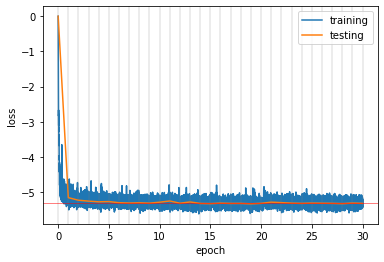

Batch:   0 Loss = -5.239799e+00,
Batch:  10 Loss = -5.333647e+00,
Batch:  20 Loss = -5.349621e+00,
Batch:  30 Loss = -5.275448e+00,
Batch:  40 Loss = -5.271226e+00,
Batch:  50 Loss = -5.197845e+00,
Batch:  60 Loss = -5.236109e+00,
Batch:  70 Loss = -5.368577e+00,
Batch:  80 Loss = -5.200225e+00,
Batch:  90 Loss = -5.155894e+00,
Batch: 100 Loss = -5.257567e+00,
Batch: 110 Loss = -5.151186e+00,
Batch: 120 Loss = -5.212557e+00,
Batch: 130 Loss = -5.140886e+00,
Batch: 140 Loss = -5.402907e+00,
Batch: 150 Loss = -5.258617e+00,
Batch: 160 Loss = -5.333405e+00,
Batch: 170 Loss = -5.243593e+00,
Batch: 180 Loss = -5.182227e+00,
Batch: 190 Loss = -5.252796e+00,
Batch: 200 Loss = -5.448810e+00,
Batch: 210 Loss = -5.276568e+00,
Batch: 220 Loss = -5.271359e+00,
Batch: 230 Loss = -5.320238e+00,
Batch: 240 Loss = -5.090891e+00,
Batch: 250 Loss = -5.256107e+00,
Batch: 260 Loss = -5.459483e+00,
Batch: 270 Loss = -5.229155e+00,
Batch: 280 Loss = -5.246742e+00,
Batch: 290 Loss = -5.343482e+00,
Batch: 300

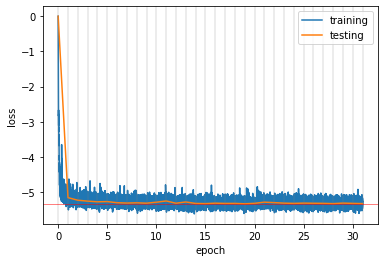

Batch:   0 Loss = -5.335172e+00,
Batch:  10 Loss = -5.431299e+00,
Batch:  20 Loss = -5.243903e+00,
Batch:  30 Loss = -5.243982e+00,
Batch:  40 Loss = -5.243628e+00,
Batch:  50 Loss = -5.271001e+00,
Batch:  60 Loss = -5.282450e+00,
Batch:  70 Loss = -5.303491e+00,
Batch:  80 Loss = -5.320325e+00,
Batch:  90 Loss = -5.213377e+00,
Batch: 100 Loss = -5.257309e+00,
Batch: 110 Loss = -5.381211e+00,
Batch: 120 Loss = -5.407396e+00,
Batch: 130 Loss = -5.354599e+00,
Batch: 140 Loss = -5.290142e+00,
Batch: 150 Loss = -5.423764e+00,
Batch: 160 Loss = -5.332828e+00,
Batch: 170 Loss = -5.482912e+00,
Batch: 180 Loss = -5.272411e+00,
Batch: 190 Loss = -5.271678e+00,
Batch: 200 Loss = -5.207518e+00,
Batch: 210 Loss = -5.354357e+00,
Batch: 220 Loss = -5.296294e+00,
Batch: 230 Loss = -5.333267e+00,
Batch: 240 Loss = -5.375376e+00,
Batch: 250 Loss = -5.326858e+00,
Batch: 260 Loss = -5.471345e+00,
Batch: 270 Loss = -5.342323e+00,
Batch: 280 Loss = -5.361831e+00,
Batch: 290 Loss = -5.121491e+00,
Batch: 300

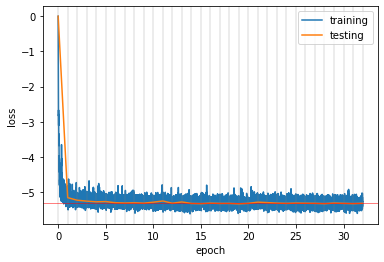

Batch:   0 Loss = -5.252996e+00,
Batch:  10 Loss = -5.403033e+00,
Batch:  20 Loss = -5.273470e+00,
Batch:  30 Loss = -5.398476e+00,
Batch:  40 Loss = -5.414178e+00,
Batch:  50 Loss = -5.231124e+00,
Batch:  60 Loss = -5.279140e+00,
Batch:  70 Loss = -5.190623e+00,
Batch:  80 Loss = -5.380372e+00,
Batch:  90 Loss = -5.181296e+00,
Batch: 100 Loss = -5.351869e+00,
Batch: 110 Loss = -5.417462e+00,
Batch: 120 Loss = -5.295303e+00,
Batch: 130 Loss = -5.268972e+00,
Batch: 140 Loss = -5.267053e+00,
Batch: 150 Loss = -5.430211e+00,
Batch: 160 Loss = -5.210155e+00,
Batch: 170 Loss = -5.302507e+00,
Batch: 180 Loss = -5.364082e+00,
Batch: 190 Loss = -5.450077e+00,
Batch: 200 Loss = -5.249664e+00,
Batch: 210 Loss = -5.359752e+00,
Batch: 220 Loss = -5.245093e+00,
Batch: 230 Loss = -5.460058e+00,
Batch: 240 Loss = -5.314357e+00,
Batch: 250 Loss = -5.356578e+00,
Batch: 260 Loss = -5.299648e+00,
Batch: 270 Loss = -5.477580e+00,
Batch: 280 Loss = -5.267710e+00,
Batch: 290 Loss = -5.236954e+00,
Batch: 300

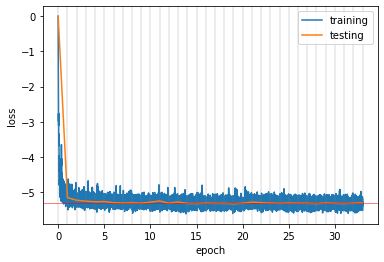

Batch:   0 Loss = -5.068975e+00,
Batch:  10 Loss = -5.213122e+00,
Batch:  20 Loss = -5.361321e+00,
Batch:  30 Loss = -5.285227e+00,
Batch:  40 Loss = -5.317699e+00,
Batch:  50 Loss = -5.374555e+00,
Batch:  60 Loss = -5.300118e+00,
Batch:  70 Loss = -5.350398e+00,
Batch:  80 Loss = -5.360553e+00,
Batch:  90 Loss = -5.336920e+00,
Batch: 100 Loss = -5.337644e+00,
Batch: 110 Loss = -5.432385e+00,
Batch: 120 Loss = -5.203702e+00,
Batch: 130 Loss = -5.293882e+00,
Batch: 140 Loss = -5.289835e+00,
Batch: 150 Loss = -5.433193e+00,
Batch: 160 Loss = -5.085983e+00,
Batch: 170 Loss = -5.272405e+00,
Batch: 180 Loss = -5.302701e+00,
Batch: 190 Loss = -5.274067e+00,
Batch: 200 Loss = -5.112076e+00,
Batch: 210 Loss = -5.394124e+00,
Batch: 220 Loss = -5.287979e+00,
Batch: 230 Loss = -5.341251e+00,
Batch: 240 Loss = -5.326215e+00,
Batch: 250 Loss = -5.351768e+00,
Batch: 260 Loss = -5.302904e+00,
Batch: 270 Loss = -5.342594e+00,
Batch: 280 Loss = -5.180557e+00,
Batch: 290 Loss = -5.204477e+00,
Batch: 300

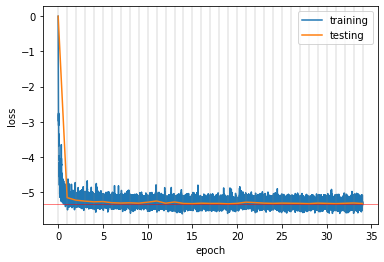

Batch:   0 Loss = -5.354931e+00,
Batch:  10 Loss = -5.454670e+00,
Batch:  20 Loss = -5.338966e+00,
Batch:  30 Loss = -5.304842e+00,
Batch:  40 Loss = -5.356936e+00,
Batch:  50 Loss = -5.489088e+00,
Batch:  60 Loss = -5.429622e+00,
Batch:  70 Loss = -5.459894e+00,
Batch:  80 Loss = -5.427745e+00,
Batch:  90 Loss = -5.411903e+00,
Batch: 100 Loss = -5.445063e+00,
Batch: 110 Loss = -5.407304e+00,
Batch: 120 Loss = -5.302352e+00,
Batch: 130 Loss = -5.325341e+00,
Batch: 140 Loss = -5.244048e+00,
Batch: 150 Loss = -5.367153e+00,
Batch: 160 Loss = -5.270396e+00,
Batch: 170 Loss = -5.177493e+00,
Batch: 180 Loss = -5.236795e+00,
Batch: 190 Loss = -5.250337e+00,
Batch: 200 Loss = -5.163419e+00,
Batch: 210 Loss = -5.254759e+00,
Batch: 220 Loss = -5.298057e+00,
Batch: 230 Loss = -5.250855e+00,
Batch: 240 Loss = -5.206637e+00,
Batch: 250 Loss = -5.440334e+00,
Batch: 260 Loss = -5.362701e+00,
Batch: 270 Loss = -5.318034e+00,
Batch: 280 Loss = -5.298240e+00,
Batch: 290 Loss = -5.373431e+00,
Batch: 300

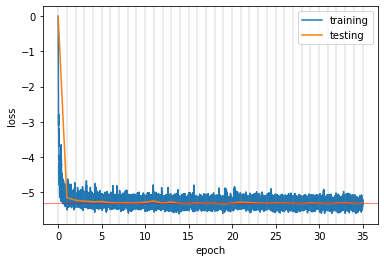

Batch:   0 Loss = -5.216072e+00,
Batch:  10 Loss = -5.206521e+00,
Batch:  20 Loss = -5.278288e+00,
Batch:  30 Loss = -5.209067e+00,
Batch:  40 Loss = -5.157020e+00,
Batch:  50 Loss = -5.373869e+00,
Batch:  60 Loss = -5.480595e+00,
Batch:  70 Loss = -5.463520e+00,
Batch:  80 Loss = -5.339791e+00,
Batch:  90 Loss = -5.269167e+00,
Batch: 100 Loss = -5.252605e+00,
Batch: 110 Loss = -5.345791e+00,
Batch: 120 Loss = -5.365417e+00,
Batch: 130 Loss = -5.431608e+00,
Batch: 140 Loss = -5.195493e+00,
Batch: 150 Loss = -5.344134e+00,
Batch: 160 Loss = -5.460212e+00,
Batch: 170 Loss = -5.141265e+00,
Batch: 180 Loss = -5.382787e+00,
Batch: 190 Loss = -5.251021e+00,
Batch: 200 Loss = -5.175698e+00,
Batch: 210 Loss = -5.363987e+00,
Batch: 220 Loss = -5.481724e+00,
Batch: 230 Loss = -5.366715e+00,
Batch: 240 Loss = -5.247147e+00,
Batch: 250 Loss = -5.200152e+00,
Batch: 260 Loss = -5.230452e+00,
Batch: 270 Loss = -5.249224e+00,
Batch: 280 Loss = -5.432095e+00,
Batch: 290 Loss = -5.333943e+00,
Batch: 300

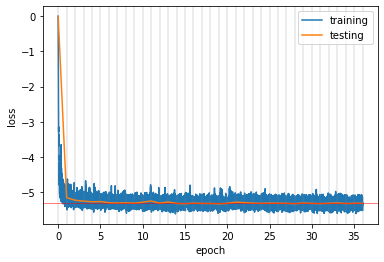

Batch:   0 Loss = -5.266959e+00,
Batch:  10 Loss = -5.380845e+00,
Batch:  20 Loss = -5.431506e+00,
Batch:  30 Loss = -5.333460e+00,
Batch:  40 Loss = -5.373365e+00,
Batch:  50 Loss = -5.435529e+00,
Batch:  60 Loss = -5.343657e+00,
Batch:  70 Loss = -5.187994e+00,
Batch:  80 Loss = -5.359767e+00,
Batch:  90 Loss = -5.200237e+00,
Batch: 100 Loss = -5.330120e+00,
Batch: 110 Loss = -5.259699e+00,
Batch: 120 Loss = -5.431509e+00,
Batch: 130 Loss = -5.361534e+00,
Batch: 140 Loss = -5.338136e+00,
Batch: 150 Loss = -5.254329e+00,
Batch: 160 Loss = -5.335573e+00,
Batch: 170 Loss = -5.262921e+00,
Batch: 180 Loss = -5.301733e+00,
Batch: 190 Loss = -5.427740e+00,
Batch: 200 Loss = -5.267109e+00,
Batch: 210 Loss = -5.321496e+00,
Batch: 220 Loss = -5.292351e+00,
Batch: 230 Loss = -5.380931e+00,
Batch: 240 Loss = -5.299009e+00,
Batch: 250 Loss = -5.346154e+00,
Batch: 260 Loss = -5.303555e+00,
Batch: 270 Loss = -5.218563e+00,
Batch: 280 Loss = -5.411398e+00,
Batch: 290 Loss = -5.341672e+00,
Batch: 300

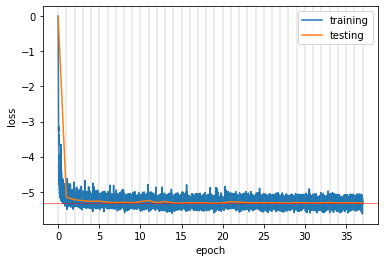

Batch:   0 Loss = -5.205992e+00,
Batch:  10 Loss = -5.239501e+00,
Batch:  20 Loss = -5.367231e+00,
Batch:  30 Loss = -5.411251e+00,
Batch:  40 Loss = -5.335654e+00,
Batch:  50 Loss = -5.343308e+00,
Batch:  60 Loss = -5.304055e+00,
Batch:  70 Loss = -5.456963e+00,
Batch:  80 Loss = -5.214665e+00,
Batch:  90 Loss = -5.318489e+00,
Batch: 100 Loss = -5.147792e+00,
Batch: 110 Loss = -5.308643e+00,
Batch: 120 Loss = -5.333427e+00,
Batch: 130 Loss = -5.267360e+00,
Batch: 140 Loss = -5.318987e+00,
Batch: 150 Loss = -5.368125e+00,
Batch: 160 Loss = -5.283171e+00,
Batch: 170 Loss = -5.365225e+00,
Batch: 180 Loss = -5.284972e+00,
Batch: 190 Loss = -5.346361e+00,
Batch: 200 Loss = -5.435329e+00,
Batch: 210 Loss = -5.475309e+00,
Batch: 220 Loss = -5.324801e+00,
Batch: 230 Loss = -5.360398e+00,
Batch: 240 Loss = -5.288028e+00,
Batch: 250 Loss = -5.171036e+00,
Batch: 260 Loss = -5.199533e+00,
Batch: 270 Loss = -5.277575e+00,
Batch: 280 Loss = -5.388747e+00,
Batch: 290 Loss = -5.141662e+00,
Batch: 300

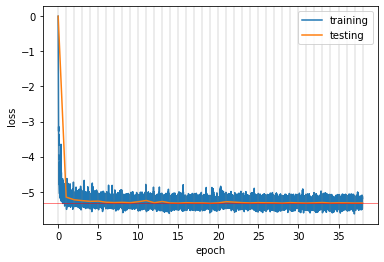

Batch:   0 Loss = -5.404455e+00,
Batch:  10 Loss = -5.508132e+00,
Batch:  20 Loss = -5.289518e+00,
Batch:  30 Loss = -5.270707e+00,
Batch:  40 Loss = -5.462222e+00,
Batch:  50 Loss = -5.444717e+00,
Batch:  60 Loss = -5.505016e+00,
Batch:  70 Loss = -5.361355e+00,
Batch:  80 Loss = -5.328381e+00,
Batch:  90 Loss = -5.129959e+00,
Batch: 100 Loss = -5.285380e+00,
Batch: 110 Loss = -5.379054e+00,
Batch: 120 Loss = -5.230189e+00,
Batch: 130 Loss = -5.484274e+00,
Batch: 140 Loss = -5.461015e+00,
Batch: 150 Loss = -5.418833e+00,
Batch: 160 Loss = -5.381631e+00,
Batch: 170 Loss = -5.392090e+00,
Batch: 180 Loss = -5.386972e+00,
Batch: 190 Loss = -5.357633e+00,
Batch: 200 Loss = -5.351764e+00,
Batch: 210 Loss = -5.167908e+00,
Batch: 220 Loss = -5.372278e+00,
Batch: 230 Loss = -5.381974e+00,
Batch: 240 Loss = -5.419265e+00,
Batch: 250 Loss = -5.304055e+00,
Batch: 260 Loss = -5.230507e+00,
Batch: 270 Loss = -5.195292e+00,
Batch: 280 Loss = -5.285645e+00,
Batch: 290 Loss = -5.246451e+00,
Batch: 300

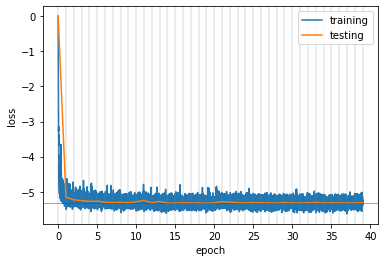

Batch:   0 Loss = -5.386165e+00,
Batch:  10 Loss = -5.307573e+00,
Batch:  20 Loss = -5.321871e+00,
Batch:  30 Loss = -5.305675e+00,
Batch:  40 Loss = -5.240233e+00,
Batch:  50 Loss = -5.175026e+00,
Batch:  60 Loss = -5.252097e+00,
Batch:  70 Loss = -5.458554e+00,
Batch:  80 Loss = -5.216044e+00,
Batch:  90 Loss = -5.257397e+00,
Batch: 100 Loss = -5.210026e+00,
Batch: 110 Loss = -5.272370e+00,
Batch: 120 Loss = -5.259197e+00,
Batch: 130 Loss = -5.222363e+00,
Batch: 140 Loss = -5.243058e+00,
Batch: 150 Loss = -5.330259e+00,
Batch: 160 Loss = -5.344122e+00,
Batch: 170 Loss = -5.374185e+00,
Batch: 180 Loss = -5.329143e+00,
Batch: 190 Loss = -5.210989e+00,
Batch: 200 Loss = -5.223337e+00,
Batch: 210 Loss = -5.183795e+00,
Batch: 220 Loss = -5.314997e+00,
Batch: 230 Loss = -5.427862e+00,
Batch: 240 Loss = -5.289464e+00,
Batch: 250 Loss = -5.480659e+00,
Batch: 260 Loss = -5.396366e+00,
Batch: 270 Loss = -5.495228e+00,
Batch: 280 Loss = -5.390077e+00,
Batch: 290 Loss = -5.502395e+00,
Batch: 300

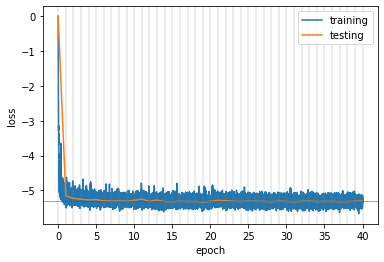

Batch:   0 Loss = -5.214602e+00,
Batch:  10 Loss = -5.416424e+00,
Batch:  20 Loss = -5.334537e+00,
Batch:  30 Loss = -5.491466e+00,
Batch:  40 Loss = -5.444333e+00,
Batch:  50 Loss = -5.226220e+00,
Batch:  60 Loss = -5.445520e+00,
Batch:  70 Loss = -5.436673e+00,
Batch:  80 Loss = -5.266925e+00,
Batch:  90 Loss = -5.109648e+00,
Batch: 100 Loss = -5.341157e+00,
Batch: 110 Loss = -5.446634e+00,
Batch: 120 Loss = -5.181999e+00,
Batch: 130 Loss = -5.263992e+00,
Batch: 140 Loss = -5.456759e+00,
Batch: 150 Loss = -5.448006e+00,
Batch: 160 Loss = -5.335199e+00,
Batch: 170 Loss = -5.400092e+00,
Batch: 180 Loss = -5.200656e+00,
Batch: 190 Loss = -5.283061e+00,
Batch: 200 Loss = -5.443956e+00,
Batch: 210 Loss = -5.214648e+00,
Batch: 220 Loss = -5.290295e+00,
Batch: 230 Loss = -5.443372e+00,
Batch: 240 Loss = -5.127161e+00,
Batch: 250 Loss = -5.262947e+00,
Batch: 260 Loss = -5.309544e+00,
Batch: 270 Loss = -5.256975e+00,
Batch: 280 Loss = -5.317057e+00,
Batch: 290 Loss = -5.274802e+00,
Batch: 300

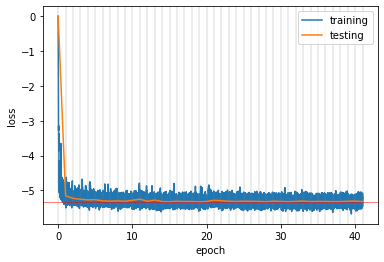

Batch:   0 Loss = -5.227943e+00,
Batch:  10 Loss = -5.328989e+00,
Batch:  20 Loss = -5.421132e+00,
Batch:  30 Loss = -5.377463e+00,
Batch:  40 Loss = -5.152877e+00,
Batch:  50 Loss = -5.320635e+00,
Batch:  60 Loss = -5.288870e+00,
Batch:  70 Loss = -5.320964e+00,
Batch:  80 Loss = -5.239154e+00,
Batch:  90 Loss = -5.291752e+00,
Batch: 100 Loss = -5.395512e+00,
Batch: 110 Loss = -5.223755e+00,
Batch: 120 Loss = -5.229718e+00,
Batch: 130 Loss = -5.372178e+00,
Batch: 140 Loss = -5.445547e+00,
Batch: 150 Loss = -5.372394e+00,
Batch: 160 Loss = -5.194091e+00,
Batch: 170 Loss = -5.262926e+00,
Batch: 180 Loss = -5.243143e+00,
Batch: 190 Loss = -5.378538e+00,
Batch: 200 Loss = -5.316392e+00,
Batch: 210 Loss = -5.344251e+00,
Batch: 220 Loss = -5.352691e+00,
Batch: 230 Loss = -5.304277e+00,
Batch: 240 Loss = -5.148593e+00,
Batch: 250 Loss = -5.304786e+00,
Batch: 260 Loss = -5.337084e+00,
Batch: 270 Loss = -5.326040e+00,
Batch: 280 Loss = -5.426219e+00,
Batch: 290 Loss = -5.218384e+00,
Batch: 300

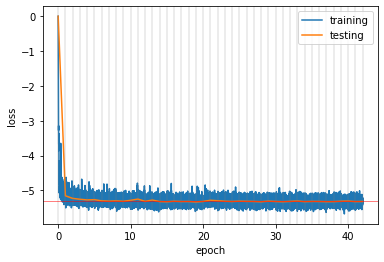

Batch:   0 Loss = -5.322391e+00,
Batch:  10 Loss = -5.380225e+00,
Batch:  20 Loss = -5.245174e+00,
Batch:  30 Loss = -5.116944e+00,
Batch:  40 Loss = -5.296390e+00,
Batch:  50 Loss = -5.311018e+00,
Batch:  60 Loss = -5.330912e+00,
Batch:  70 Loss = -5.352269e+00,
Batch:  80 Loss = -5.360596e+00,
Batch:  90 Loss = -5.160226e+00,
Batch: 100 Loss = -5.472148e+00,
Batch: 110 Loss = -5.341447e+00,
Batch: 120 Loss = -5.377959e+00,
Batch: 130 Loss = -5.224422e+00,
Batch: 140 Loss = -5.240113e+00,
Batch: 150 Loss = -5.358091e+00,
Batch: 160 Loss = -5.428688e+00,
Batch: 170 Loss = -5.426085e+00,
Batch: 180 Loss = -5.385486e+00,
Batch: 190 Loss = -5.240399e+00,
Batch: 200 Loss = -5.239020e+00,
Batch: 210 Loss = -5.249180e+00,
Batch: 220 Loss = -5.323048e+00,
Batch: 230 Loss = -5.418190e+00,
Batch: 240 Loss = -5.374477e+00,
Batch: 250 Loss = -5.300130e+00,
Batch: 260 Loss = -5.358935e+00,
Batch: 270 Loss = -5.330120e+00,
Batch: 280 Loss = -5.414970e+00,
Batch: 290 Loss = -5.357368e+00,
Batch: 300

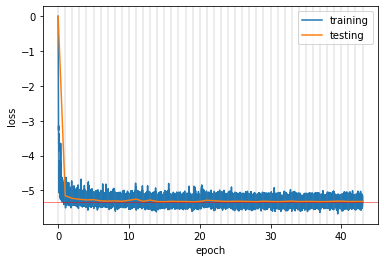

Batch:   0 Loss = -5.144118e+00,
Batch:  10 Loss = -5.291577e+00,
Batch:  20 Loss = -5.298929e+00,
Batch:  30 Loss = -5.387235e+00,
Batch:  40 Loss = -5.366822e+00,
Batch:  50 Loss = -5.245096e+00,
Batch:  60 Loss = -5.347063e+00,
Batch:  70 Loss = -5.257373e+00,
Batch:  80 Loss = -5.315625e+00,
Batch:  90 Loss = -5.310926e+00,
Batch: 100 Loss = -5.368357e+00,
Batch: 110 Loss = -5.336588e+00,
Batch: 120 Loss = -5.357356e+00,
Batch: 130 Loss = -5.255323e+00,
Batch: 140 Loss = -5.291556e+00,
Batch: 150 Loss = -5.247713e+00,
Batch: 160 Loss = -5.293692e+00,
Batch: 170 Loss = -5.394457e+00,
Batch: 180 Loss = -5.548644e+00,
Batch: 190 Loss = -5.465714e+00,
Batch: 200 Loss = -5.299269e+00,
Batch: 210 Loss = -5.241104e+00,
Batch: 220 Loss = -5.231122e+00,
Batch: 230 Loss = -5.220684e+00,
Batch: 240 Loss = -5.254244e+00,
Batch: 250 Loss = -5.355466e+00,
Batch: 260 Loss = -5.340641e+00,
Batch: 270 Loss = -5.312340e+00,
Batch: 280 Loss = -5.224133e+00,
Batch: 290 Loss = -5.427647e+00,
Batch: 300

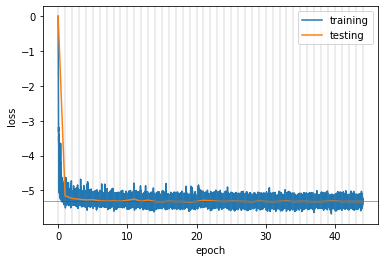

Batch:   0 Loss = -5.219009e+00,
Batch:  10 Loss = -5.305330e+00,
Batch:  20 Loss = -5.350368e+00,
Batch:  30 Loss = -5.308374e+00,
Batch:  40 Loss = -5.367255e+00,
Batch:  50 Loss = -5.453739e+00,
Batch:  60 Loss = -5.432833e+00,
Batch:  70 Loss = -5.107657e+00,
Batch:  80 Loss = -5.307583e+00,
Batch:  90 Loss = -5.323800e+00,
Batch: 100 Loss = -5.299885e+00,
Batch: 110 Loss = -5.457228e+00,
Batch: 120 Loss = -5.362428e+00,
Batch: 130 Loss = -5.237550e+00,
Batch: 140 Loss = -5.202296e+00,
Batch: 150 Loss = -5.336507e+00,
Batch: 160 Loss = -5.393547e+00,
Batch: 170 Loss = -5.343024e+00,
Batch: 180 Loss = -5.280425e+00,
Batch: 190 Loss = -5.337495e+00,
Batch: 200 Loss = -5.398655e+00,
Batch: 210 Loss = -5.362490e+00,
Batch: 220 Loss = -5.321075e+00,
Batch: 230 Loss = -5.243202e+00,
Batch: 240 Loss = -5.422686e+00,
Batch: 250 Loss = -5.331598e+00,
Batch: 260 Loss = -5.270165e+00,
Batch: 270 Loss = -5.341196e+00,
Batch: 280 Loss = -5.338097e+00,
Batch: 290 Loss = -5.475231e+00,
Batch: 300

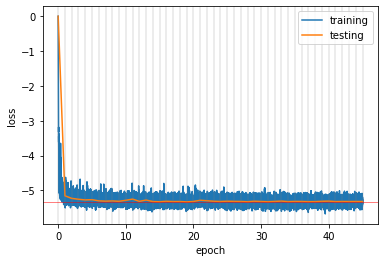

Batch:   0 Loss = -5.150118e+00,
Batch:  10 Loss = -5.353547e+00,
Batch:  20 Loss = -5.182632e+00,
Batch:  30 Loss = -5.447779e+00,
Batch:  40 Loss = -5.435597e+00,
Batch:  50 Loss = -5.336152e+00,
Batch:  60 Loss = -5.330347e+00,
Batch:  70 Loss = -5.354521e+00,
Batch:  80 Loss = -5.119353e+00,
Batch:  90 Loss = -5.301657e+00,
Batch: 100 Loss = -5.350911e+00,
Batch: 110 Loss = -5.259207e+00,
Batch: 120 Loss = -5.233257e+00,
Batch: 130 Loss = -5.204740e+00,
Batch: 140 Loss = -5.348227e+00,
Batch: 150 Loss = -5.245821e+00,
Batch: 160 Loss = -5.200208e+00,
Batch: 170 Loss = -5.201191e+00,
Batch: 180 Loss = -5.391855e+00,
Batch: 190 Loss = -5.290763e+00,
Batch: 200 Loss = -5.393217e+00,
Batch: 210 Loss = -5.448478e+00,
Batch: 220 Loss = -5.169460e+00,
Batch: 230 Loss = -5.299962e+00,
Batch: 240 Loss = -5.283359e+00,
Batch: 250 Loss = -5.358930e+00,
Batch: 260 Loss = -5.378162e+00,
Batch: 270 Loss = -5.182884e+00,
Batch: 280 Loss = -5.272985e+00,
Batch: 290 Loss = -5.224945e+00,
Batch: 300

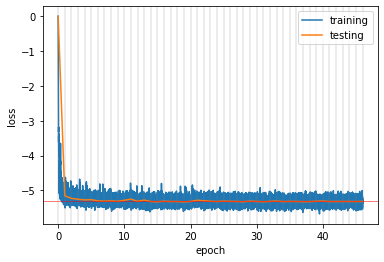

Batch:   0 Loss = -5.393082e+00,
Batch:  10 Loss = -5.273261e+00,
Batch:  20 Loss = -5.147550e+00,
Batch:  30 Loss = -5.608511e+00,
Batch:  40 Loss = -5.410383e+00,
Batch:  50 Loss = -5.335351e+00,
Batch:  60 Loss = -5.335410e+00,
Batch:  70 Loss = -5.215469e+00,
Batch:  80 Loss = -5.356802e+00,
Batch:  90 Loss = -5.402681e+00,
Batch: 100 Loss = -5.174557e+00,
Batch: 110 Loss = -5.392231e+00,
Batch: 120 Loss = -5.453348e+00,
Batch: 130 Loss = -5.246842e+00,
Batch: 140 Loss = -5.219928e+00,
Batch: 150 Loss = -5.217623e+00,
Batch: 160 Loss = -5.427142e+00,
Batch: 170 Loss = -5.252150e+00,
Batch: 180 Loss = -5.293650e+00,
Batch: 190 Loss = -5.333273e+00,
Batch: 200 Loss = -5.404094e+00,
Batch: 210 Loss = -5.314076e+00,
Batch: 220 Loss = -5.180387e+00,
Batch: 230 Loss = -5.194647e+00,
Batch: 240 Loss = -5.268995e+00,
Batch: 250 Loss = -5.384384e+00,
Batch: 260 Loss = -5.242870e+00,
Batch: 270 Loss = -5.210036e+00,
Batch: 280 Loss = -5.418039e+00,
Batch: 290 Loss = -5.452691e+00,
Batch: 300

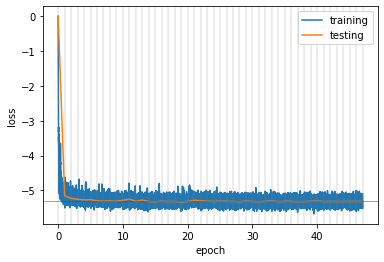

Batch:   0 Loss = -5.378853e+00,
Batch:  10 Loss = -5.312029e+00,
Batch:  20 Loss = -5.273003e+00,
Batch:  30 Loss = -5.383746e+00,
Batch:  40 Loss = -5.194519e+00,
Batch:  50 Loss = -5.389917e+00,
Batch:  60 Loss = -5.228864e+00,
Batch:  70 Loss = -5.495444e+00,
Batch:  80 Loss = -5.365276e+00,
Batch:  90 Loss = -5.410128e+00,
Batch: 100 Loss = -5.337737e+00,
Batch: 110 Loss = -5.278639e+00,
Batch: 120 Loss = -5.302193e+00,
Batch: 130 Loss = -5.533389e+00,
Batch: 140 Loss = -5.170301e+00,
Batch: 150 Loss = -5.247388e+00,
Batch: 160 Loss = -5.338495e+00,
Batch: 170 Loss = -5.251709e+00,
Batch: 180 Loss = -5.403940e+00,
Batch: 190 Loss = -5.328604e+00,
Batch: 200 Loss = -5.192428e+00,
Batch: 210 Loss = -5.279612e+00,
Batch: 220 Loss = -5.361290e+00,
Batch: 230 Loss = -5.424280e+00,
Batch: 240 Loss = -5.194108e+00,
Batch: 250 Loss = -5.478743e+00,
Batch: 260 Loss = -5.025672e+00,
Batch: 270 Loss = -5.275894e+00,
Batch: 280 Loss = -5.123271e+00,
Batch: 290 Loss = -5.216201e+00,
Batch: 300

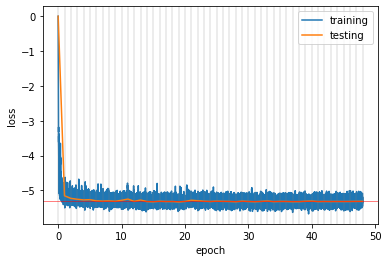

Batch:   0 Loss = -5.259041e+00,
Batch:  10 Loss = -5.302513e+00,
Batch:  20 Loss = -5.389032e+00,
Batch:  30 Loss = -5.331612e+00,
Batch:  40 Loss = -5.327164e+00,
Batch:  50 Loss = -5.240157e+00,
Batch:  60 Loss = -5.257859e+00,
Batch:  70 Loss = -5.314069e+00,
Batch:  80 Loss = -5.356976e+00,
Batch:  90 Loss = -5.330909e+00,
Batch: 100 Loss = -5.184465e+00,
Batch: 110 Loss = -5.337598e+00,
Batch: 120 Loss = -5.413394e+00,
Batch: 130 Loss = -5.238257e+00,
Batch: 140 Loss = -5.340115e+00,
Batch: 150 Loss = -5.430129e+00,
Batch: 160 Loss = -5.337370e+00,
Batch: 170 Loss = -5.254963e+00,
Batch: 180 Loss = -5.290354e+00,
Batch: 190 Loss = -5.263273e+00,
Batch: 200 Loss = -5.189534e+00,
Batch: 210 Loss = -5.337361e+00,
Batch: 220 Loss = -5.313011e+00,
Batch: 230 Loss = -5.284849e+00,
Batch: 240 Loss = -5.310762e+00,
Batch: 250 Loss = -5.215137e+00,
Batch: 260 Loss = -5.273636e+00,
Batch: 270 Loss = -5.361887e+00,
Batch: 280 Loss = -5.488085e+00,
Batch: 290 Loss = -5.422808e+00,
Batch: 300

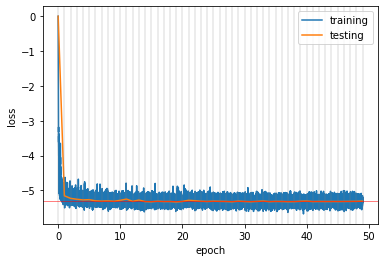

Batch:   0 Loss = -5.381657e+00,
Batch:  10 Loss = -5.366986e+00,
Batch:  20 Loss = -5.331785e+00,
Batch:  30 Loss = -5.274682e+00,
Batch:  40 Loss = -5.282752e+00,
Batch:  50 Loss = -5.395053e+00,
Batch:  60 Loss = -5.218232e+00,
Batch:  70 Loss = -5.331049e+00,
Batch:  80 Loss = -5.338780e+00,
Batch:  90 Loss = -5.107031e+00,
Batch: 100 Loss = -5.269234e+00,
Batch: 110 Loss = -5.094419e+00,
Batch: 120 Loss = -5.229361e+00,
Batch: 130 Loss = -5.345356e+00,
Batch: 140 Loss = -5.165121e+00,
Batch: 150 Loss = -5.298315e+00,
Batch: 160 Loss = -5.416655e+00,
Batch: 170 Loss = -5.466130e+00,
Batch: 180 Loss = -5.278941e+00,
Batch: 190 Loss = -5.353294e+00,
Batch: 200 Loss = -5.464218e+00,
Batch: 210 Loss = -5.379752e+00,
Batch: 220 Loss = -5.341876e+00,
Batch: 230 Loss = -5.471835e+00,
Batch: 240 Loss = -5.375824e+00,
Batch: 250 Loss = -5.226336e+00,
Batch: 260 Loss = -5.466151e+00,
Batch: 270 Loss = -5.155577e+00,
Batch: 280 Loss = -5.422379e+00,
Batch: 290 Loss = -5.414986e+00,
Batch: 300

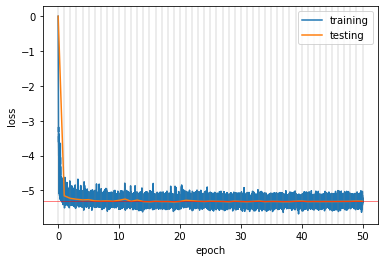

Batch:   0 Loss = -5.357172e+00,
Batch:  10 Loss = -5.374944e+00,
Batch:  20 Loss = -5.368155e+00,
Batch:  30 Loss = -5.346809e+00,
Batch:  40 Loss = -5.214820e+00,
Batch:  50 Loss = -5.301841e+00,
Batch:  60 Loss = -5.153326e+00,
Batch:  70 Loss = -5.341516e+00,
Batch:  80 Loss = -5.254074e+00,
Batch:  90 Loss = -5.286008e+00,
Batch: 100 Loss = -5.484106e+00,
Batch: 110 Loss = -5.111926e+00,
Batch: 120 Loss = -5.415557e+00,
Batch: 130 Loss = -5.366550e+00,
Batch: 140 Loss = -5.412390e+00,
Batch: 150 Loss = -5.488696e+00,
Batch: 160 Loss = -5.301201e+00,
Batch: 170 Loss = -5.131795e+00,
Batch: 180 Loss = -5.225988e+00,
Batch: 190 Loss = -5.504061e+00,
Batch: 200 Loss = -5.294543e+00,
Batch: 210 Loss = -5.215387e+00,
Batch: 220 Loss = -5.370713e+00,
Batch: 230 Loss = -5.327630e+00,
Batch: 240 Loss = -5.362249e+00,
Batch: 250 Loss = -5.378982e+00,
Batch: 260 Loss = -5.246549e+00,
Batch: 270 Loss = -5.278890e+00,
Batch: 280 Loss = -5.170097e+00,
Batch: 290 Loss = -5.289734e+00,
Batch: 300

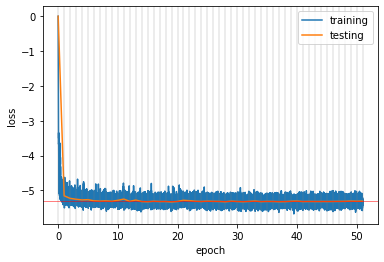

Batch:   0 Loss = -5.292343e+00,
Batch:  10 Loss = -5.516881e+00,
Batch:  20 Loss = -5.268722e+00,
Batch:  30 Loss = -5.241481e+00,
Batch:  40 Loss = -5.228981e+00,
Batch:  50 Loss = -5.576272e+00,
Batch:  60 Loss = -5.263066e+00,
Batch:  70 Loss = -5.152909e+00,
Batch:  80 Loss = -5.110754e+00,
Batch:  90 Loss = -5.278088e+00,
Batch: 100 Loss = -5.267698e+00,
Batch: 110 Loss = -5.292914e+00,
Batch: 120 Loss = -5.153236e+00,
Batch: 130 Loss = -5.431911e+00,
Batch: 140 Loss = -5.196972e+00,
Batch: 150 Loss = -5.341151e+00,
Batch: 160 Loss = -5.341483e+00,
Batch: 170 Loss = -5.344215e+00,
Batch: 180 Loss = -5.431251e+00,
Batch: 190 Loss = -5.223775e+00,
Batch: 200 Loss = -5.305498e+00,
Batch: 210 Loss = -5.398548e+00,
Batch: 220 Loss = -5.398822e+00,
Batch: 230 Loss = -5.195655e+00,
Batch: 240 Loss = -5.256737e+00,
Batch: 250 Loss = -5.264374e+00,
Batch: 260 Loss = -5.321216e+00,
Batch: 270 Loss = -5.253742e+00,
Batch: 280 Loss = -5.324596e+00,
Batch: 290 Loss = -5.339893e+00,
Batch: 300

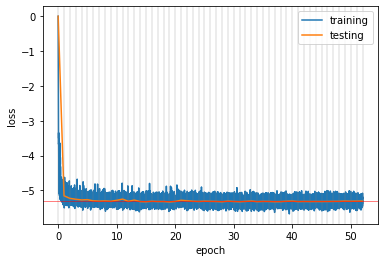

Batch:   0 Loss = -5.316240e+00,
Batch:  10 Loss = -5.435171e+00,
Batch:  20 Loss = -5.411615e+00,
Batch:  30 Loss = -5.256180e+00,
Batch:  40 Loss = -5.200600e+00,
Batch:  50 Loss = -5.310886e+00,
Batch:  60 Loss = -5.239581e+00,
Batch:  70 Loss = -5.360277e+00,
Batch:  80 Loss = -5.395362e+00,
Batch:  90 Loss = -5.363843e+00,
Batch: 100 Loss = -5.604218e+00,
Batch: 110 Loss = -5.097496e+00,
Batch: 120 Loss = -5.355271e+00,
Batch: 130 Loss = -5.378933e+00,
Batch: 140 Loss = -5.341357e+00,
Batch: 150 Loss = -5.404768e+00,
Batch: 160 Loss = -5.383017e+00,
Batch: 170 Loss = -5.407847e+00,
Batch: 180 Loss = -5.366741e+00,
Batch: 190 Loss = -5.253435e+00,
Batch: 200 Loss = -5.273114e+00,
Batch: 210 Loss = -5.356800e+00,
Batch: 220 Loss = -5.216567e+00,
Batch: 230 Loss = -5.211425e+00,
Batch: 240 Loss = -5.391031e+00,
Batch: 250 Loss = -5.386527e+00,
Batch: 260 Loss = -5.271873e+00,
Batch: 270 Loss = -5.326002e+00,
Batch: 280 Loss = -5.379049e+00,
Batch: 290 Loss = -5.317702e+00,
Batch: 300

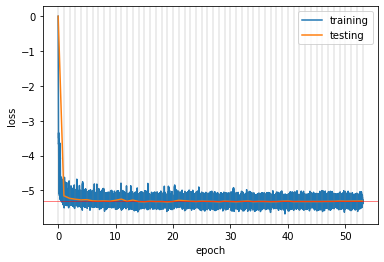

Batch:   0 Loss = -5.450150e+00,
Batch:  10 Loss = -5.329388e+00,
Batch:  20 Loss = -5.402040e+00,
Batch:  30 Loss = -5.338464e+00,
Batch:  40 Loss = -5.244431e+00,
Batch:  50 Loss = -5.341803e+00,
Batch:  60 Loss = -5.390004e+00,
Batch:  70 Loss = -5.293799e+00,
Batch:  80 Loss = -5.364816e+00,
Batch:  90 Loss = -5.217542e+00,
Batch: 100 Loss = -5.445717e+00,
Batch: 110 Loss = -5.263241e+00,
Batch: 120 Loss = -5.311680e+00,
Batch: 130 Loss = -5.452287e+00,
Batch: 140 Loss = -5.237383e+00,
Batch: 150 Loss = -5.374696e+00,
Batch: 160 Loss = -5.147963e+00,
Batch: 170 Loss = -5.312024e+00,
Batch: 180 Loss = -5.170830e+00,
Batch: 190 Loss = -5.137227e+00,
Batch: 200 Loss = -5.312588e+00,
Batch: 210 Loss = -5.368095e+00,
Batch: 220 Loss = -5.338069e+00,
Batch: 230 Loss = -5.345339e+00,
Batch: 240 Loss = -5.318544e+00,
Batch: 250 Loss = -5.108346e+00,
Batch: 260 Loss = -5.356787e+00,
Batch: 270 Loss = -5.389699e+00,
Batch: 280 Loss = -5.481039e+00,
Batch: 290 Loss = -5.170654e+00,
Batch: 300

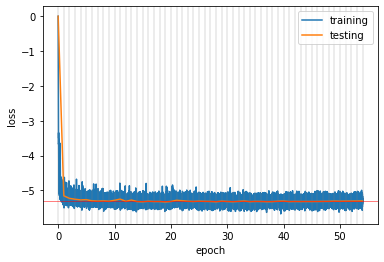

Batch:   0 Loss = -5.296523e+00,
Batch:  10 Loss = -5.278634e+00,
Batch:  20 Loss = -5.287054e+00,
Batch:  30 Loss = -5.065551e+00,
Batch:  40 Loss = -5.158028e+00,
Batch:  50 Loss = -5.285191e+00,
Batch:  60 Loss = -5.345818e+00,
Batch:  70 Loss = -5.402113e+00,
Batch:  80 Loss = -5.289093e+00,
Batch:  90 Loss = -5.224696e+00,
Batch: 100 Loss = -5.237046e+00,
Batch: 110 Loss = -5.373096e+00,
Batch: 120 Loss = -5.290477e+00,
Batch: 130 Loss = -5.277555e+00,
Batch: 140 Loss = -5.247856e+00,
Batch: 150 Loss = -5.229112e+00,
Batch: 160 Loss = -5.417437e+00,
Batch: 170 Loss = -5.371578e+00,
Batch: 180 Loss = -5.312542e+00,
Batch: 190 Loss = -5.250872e+00,
Batch: 200 Loss = -5.345108e+00,
Batch: 210 Loss = -5.204143e+00,
Batch: 220 Loss = -5.392082e+00,
Batch: 230 Loss = -5.251329e+00,
Batch: 240 Loss = -5.300204e+00,
Batch: 250 Loss = -5.097032e+00,
Batch: 260 Loss = -5.320634e+00,
Batch: 270 Loss = -5.362720e+00,
Batch: 280 Loss = -5.222516e+00,
Batch: 290 Loss = -5.312283e+00,
Batch: 300

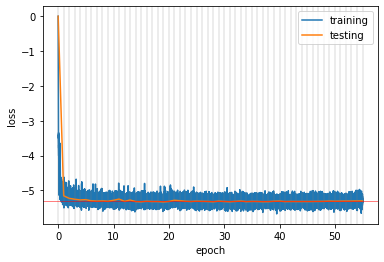

Batch:   0 Loss = -5.237870e+00,
Batch:  10 Loss = -5.190603e+00,
Batch:  20 Loss = -5.201250e+00,
Batch:  30 Loss = -5.401679e+00,
Batch:  40 Loss = -5.314558e+00,
Batch:  50 Loss = -5.211813e+00,
Batch:  60 Loss = -5.314622e+00,
Batch:  70 Loss = -5.259164e+00,
Batch:  80 Loss = -5.241716e+00,
Batch:  90 Loss = -5.309550e+00,
Batch: 100 Loss = -5.291647e+00,
Batch: 110 Loss = -5.400119e+00,
Batch: 120 Loss = -5.175369e+00,
Batch: 130 Loss = -5.280717e+00,
Batch: 140 Loss = -5.218573e+00,
Batch: 150 Loss = -5.177519e+00,
Batch: 160 Loss = -5.273184e+00,
Batch: 170 Loss = -5.276491e+00,
Batch: 180 Loss = -5.387803e+00,
Batch: 190 Loss = -5.218191e+00,
Batch: 200 Loss = -5.458248e+00,
Batch: 210 Loss = -5.246139e+00,
Batch: 220 Loss = -5.418845e+00,
Batch: 230 Loss = -5.385936e+00,
Batch: 240 Loss = -5.251804e+00,
Batch: 250 Loss = -5.241887e+00,
Batch: 260 Loss = -5.364812e+00,
Batch: 270 Loss = -5.201708e+00,
Batch: 280 Loss = -5.307849e+00,
Batch: 290 Loss = -5.500641e+00,
Batch: 300

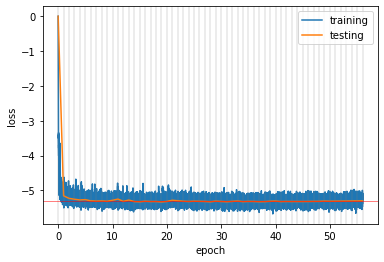

Batch:   0 Loss = -5.299196e+00,
Batch:  10 Loss = -5.330423e+00,
Batch:  20 Loss = -5.284974e+00,
Batch:  30 Loss = -5.162224e+00,
Batch:  40 Loss = -5.258754e+00,
Batch:  50 Loss = -5.080025e+00,
Batch:  60 Loss = -5.183898e+00,
Batch:  70 Loss = -5.124123e+00,
Batch:  80 Loss = -5.246204e+00,
Batch:  90 Loss = -5.162353e+00,
Batch: 100 Loss = -5.331321e+00,
Batch: 110 Loss = -5.266004e+00,
Batch: 120 Loss = -5.251474e+00,
Batch: 130 Loss = -5.390783e+00,
Batch: 140 Loss = -5.360555e+00,
Batch: 150 Loss = -5.338347e+00,
Batch: 160 Loss = -5.326537e+00,
Batch: 170 Loss = -5.385640e+00,
Batch: 180 Loss = -5.342233e+00,
Batch: 190 Loss = -5.331429e+00,
Batch: 200 Loss = -5.220034e+00,
Batch: 210 Loss = -5.337052e+00,
Batch: 220 Loss = -5.244242e+00,
Batch: 230 Loss = -5.191807e+00,
Batch: 240 Loss = -5.352580e+00,
Batch: 250 Loss = -5.196250e+00,
Batch: 260 Loss = -5.229360e+00,
Batch: 270 Loss = -5.296664e+00,
Batch: 280 Loss = -5.228350e+00,
Batch: 290 Loss = -5.192770e+00,
Batch: 300

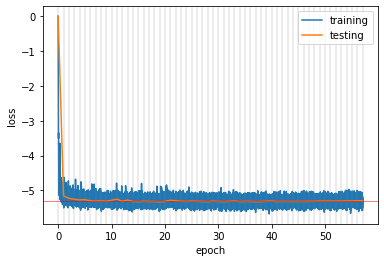

Batch:   0 Loss = -5.304859e+00,
Batch:  10 Loss = -5.359023e+00,
Batch:  20 Loss = -5.377884e+00,
Batch:  30 Loss = -5.263625e+00,
Batch:  40 Loss = -5.402670e+00,
Batch:  50 Loss = -5.348437e+00,
Batch:  60 Loss = -5.197811e+00,
Batch:  70 Loss = -5.262475e+00,
Batch:  80 Loss = -5.357447e+00,
Batch:  90 Loss = -5.376215e+00,
Batch: 100 Loss = -5.350537e+00,
Batch: 110 Loss = -5.243920e+00,
Batch: 120 Loss = -5.240791e+00,
Batch: 130 Loss = -5.388406e+00,
Batch: 140 Loss = -5.133775e+00,
Batch: 150 Loss = -5.181049e+00,
Batch: 160 Loss = -5.122254e+00,
Batch: 170 Loss = -5.310193e+00,
Batch: 180 Loss = -5.338315e+00,
Batch: 190 Loss = -5.222626e+00,
Batch: 200 Loss = -5.305507e+00,
Batch: 210 Loss = -5.251935e+00,
Batch: 220 Loss = -5.326580e+00,
Batch: 230 Loss = -5.153334e+00,
Batch: 240 Loss = -5.367943e+00,
Batch: 250 Loss = -5.342326e+00,
Batch: 260 Loss = -5.197070e+00,
Batch: 270 Loss = -5.374925e+00,
Batch: 280 Loss = -5.289819e+00,
Batch: 290 Loss = -5.261451e+00,
Batch: 300

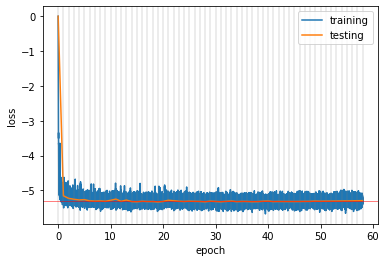

Batch:   0 Loss = -5.428212e+00,
Batch:  10 Loss = -5.335878e+00,
Batch:  20 Loss = -5.417547e+00,
Batch:  30 Loss = -5.336181e+00,
Batch:  40 Loss = -5.310846e+00,
Batch:  50 Loss = -5.372461e+00,
Batch:  60 Loss = -5.162935e+00,
Batch:  70 Loss = -5.280361e+00,
Batch:  80 Loss = -5.402386e+00,
Batch:  90 Loss = -5.286412e+00,
Batch: 100 Loss = -5.300591e+00,
Batch: 110 Loss = -5.365233e+00,
Batch: 120 Loss = -5.280687e+00,
Batch: 130 Loss = -5.231405e+00,
Batch: 140 Loss = -5.159637e+00,
Batch: 150 Loss = -5.194408e+00,
Batch: 160 Loss = -5.176935e+00,
Batch: 170 Loss = -5.364107e+00,
Batch: 180 Loss = -5.137769e+00,
Batch: 190 Loss = -5.104826e+00,
Batch: 200 Loss = -5.168422e+00,
Batch: 210 Loss = -5.241383e+00,
Batch: 220 Loss = -5.363018e+00,
Batch: 230 Loss = -5.353187e+00,
Batch: 240 Loss = -5.131512e+00,
Batch: 250 Loss = -5.137671e+00,
Batch: 260 Loss = -5.169748e+00,
Batch: 270 Loss = -5.310999e+00,
Batch: 280 Loss = -5.170562e+00,
Batch: 290 Loss = -5.199082e+00,
Batch: 300

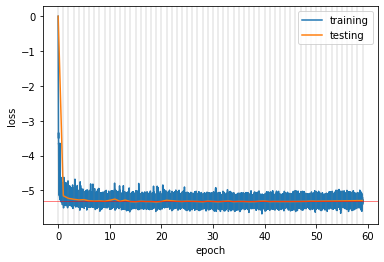

Batch:   0 Loss = -5.358889e+00,
Batch:  10 Loss = -5.448085e+00,
Batch:  20 Loss = -5.014946e+00,
Batch:  30 Loss = -5.410588e+00,
Batch:  40 Loss = -5.323116e+00,
Batch:  50 Loss = -5.412637e+00,
Batch:  60 Loss = -5.203209e+00,
Batch:  70 Loss = -5.160219e+00,
Batch:  80 Loss = -5.348882e+00,
Batch:  90 Loss = -5.398551e+00,
Batch: 100 Loss = -5.222790e+00,
Batch: 110 Loss = -5.318141e+00,
Batch: 120 Loss = -5.186800e+00,
Batch: 130 Loss = -5.264090e+00,
Batch: 140 Loss = -5.393571e+00,
Batch: 150 Loss = -5.221514e+00,
Batch: 160 Loss = -5.290254e+00,
Batch: 170 Loss = -5.294986e+00,
Batch: 180 Loss = -5.196591e+00,
Batch: 190 Loss = -5.299798e+00,
Batch: 200 Loss = -5.162993e+00,
Batch: 210 Loss = -5.260952e+00,
Batch: 220 Loss = -5.274810e+00,
Batch: 230 Loss = -5.235080e+00,
Batch: 240 Loss = -5.453341e+00,
Batch: 250 Loss = -5.381863e+00,
Batch: 260 Loss = -5.282200e+00,
Batch: 270 Loss = -5.266732e+00,
Batch: 280 Loss = -5.391068e+00,
Batch: 290 Loss = -5.264805e+00,
Batch: 300

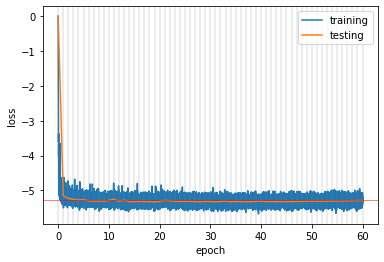

Batch:   0 Loss = -5.461883e+00,
Batch:  10 Loss = -5.273022e+00,
Batch:  20 Loss = -5.360014e+00,
Batch:  30 Loss = -5.379462e+00,
Batch:  40 Loss = -5.382329e+00,
Batch:  50 Loss = -5.315371e+00,
Batch:  60 Loss = -5.365586e+00,
Batch:  70 Loss = -5.427768e+00,
Batch:  80 Loss = -5.541490e+00,
Batch:  90 Loss = -5.492004e+00,
Batch: 100 Loss = -5.197807e+00,
Batch: 110 Loss = -5.337146e+00,
Batch: 120 Loss = -5.278339e+00,
Batch: 130 Loss = -5.362319e+00,
Batch: 140 Loss = -5.294028e+00,
Batch: 150 Loss = -5.282868e+00,
Batch: 160 Loss = -5.355883e+00,
Batch: 170 Loss = -5.346557e+00,
Batch: 180 Loss = -5.059574e+00,
Batch: 190 Loss = -5.286446e+00,
Batch: 200 Loss = -5.142009e+00,
Batch: 210 Loss = -5.308558e+00,
Batch: 220 Loss = -5.382916e+00,
Batch: 230 Loss = -5.275177e+00,
Batch: 240 Loss = -5.255858e+00,
Batch: 250 Loss = -5.243101e+00,
Batch: 260 Loss = -5.250865e+00,
Batch: 270 Loss = -5.391076e+00,
Batch: 280 Loss = -5.292586e+00,
Batch: 290 Loss = -5.159946e+00,
Batch: 300

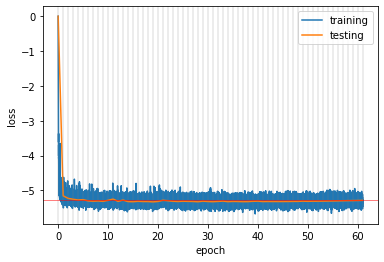

Batch:   0 Loss = -5.235298e+00,
Batch:  10 Loss = -5.446842e+00,
Batch:  20 Loss = -5.243031e+00,
Batch:  30 Loss = -5.164710e+00,
Batch:  40 Loss = -5.480318e+00,
Batch:  50 Loss = -5.154642e+00,
Batch:  60 Loss = -5.364597e+00,
Batch:  70 Loss = -5.252459e+00,
Batch:  80 Loss = -5.219529e+00,
Batch:  90 Loss = -5.251689e+00,
Batch: 100 Loss = -5.315907e+00,
Batch: 110 Loss = -5.207873e+00,
Batch: 120 Loss = -5.266695e+00,
Batch: 130 Loss = -5.380668e+00,
Batch: 140 Loss = -5.336115e+00,
Batch: 150 Loss = -5.221736e+00,
Batch: 160 Loss = -5.229688e+00,
Batch: 170 Loss = -5.367893e+00,
Batch: 180 Loss = -5.117979e+00,
Batch: 190 Loss = -5.561226e+00,
Batch: 200 Loss = -5.264417e+00,
Batch: 210 Loss = -5.176830e+00,
Batch: 220 Loss = -5.204823e+00,
Batch: 230 Loss = -5.399378e+00,
Batch: 240 Loss = -5.228489e+00,
Batch: 250 Loss = -5.196462e+00,
Batch: 260 Loss = -5.259742e+00,
Batch: 270 Loss = -5.264165e+00,
Batch: 280 Loss = -5.277671e+00,
Batch: 290 Loss = -5.406286e+00,
Batch: 300

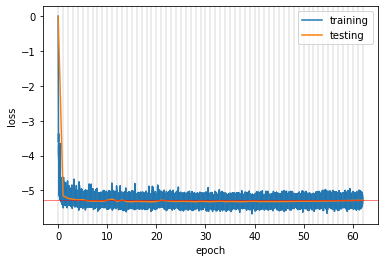

Batch:   0 Loss = -5.376625e+00,
Batch:  10 Loss = -5.338254e+00,
Batch:  20 Loss = -5.503399e+00,
Batch:  30 Loss = -5.358023e+00,
Batch:  40 Loss = -5.360991e+00,
Batch:  50 Loss = -5.284847e+00,
Batch:  60 Loss = -5.263187e+00,
Batch:  70 Loss = -5.243144e+00,
Batch:  80 Loss = -5.304712e+00,
Batch:  90 Loss = -5.232038e+00,
Batch: 100 Loss = -5.334170e+00,
Batch: 110 Loss = -5.259339e+00,
Batch: 120 Loss = -5.251144e+00,
Batch: 130 Loss = -5.229156e+00,
Batch: 140 Loss = -5.291100e+00,
Batch: 150 Loss = -5.276123e+00,
Batch: 160 Loss = -5.261810e+00,
Batch: 170 Loss = -5.331142e+00,
Batch: 180 Loss = -5.225714e+00,
Batch: 190 Loss = -5.334030e+00,
Batch: 200 Loss = -5.299164e+00,
Batch: 210 Loss = -5.342647e+00,
Batch: 220 Loss = -5.408436e+00,
Batch: 230 Loss = -5.422055e+00,
Batch: 240 Loss = -5.306125e+00,
Batch: 250 Loss = -5.407457e+00,
Batch: 260 Loss = -5.367613e+00,
Batch: 270 Loss = -5.253154e+00,
Batch: 280 Loss = -5.319583e+00,
Batch: 290 Loss = -5.447881e+00,
Batch: 300

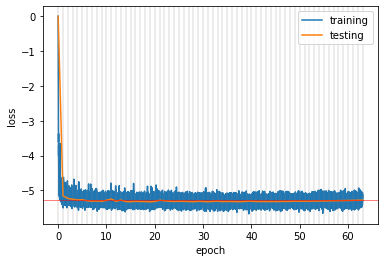

Batch:   0 Loss = -5.221381e+00,
Batch:  10 Loss = -5.374420e+00,
Batch:  20 Loss = -5.283738e+00,
Batch:  30 Loss = -5.442061e+00,
Batch:  40 Loss = -5.209973e+00,
Batch:  50 Loss = -5.340655e+00,
Batch:  60 Loss = -5.220971e+00,
Batch:  70 Loss = -5.193433e+00,
Batch:  80 Loss = -5.195975e+00,
Batch:  90 Loss = -5.340370e+00,
Batch: 100 Loss = -5.390449e+00,
Batch: 110 Loss = -5.076264e+00,
Batch: 120 Loss = -5.248915e+00,
Batch: 130 Loss = -5.337671e+00,
Batch: 140 Loss = -5.292749e+00,
Batch: 150 Loss = -5.363316e+00,
Batch: 160 Loss = -5.391460e+00,
Batch: 170 Loss = -5.278012e+00,
Batch: 180 Loss = -5.543690e+00,
Batch: 190 Loss = -5.220063e+00,
Batch: 200 Loss = -5.499653e+00,
Batch: 210 Loss = -5.233537e+00,
Batch: 220 Loss = -5.258522e+00,
Batch: 230 Loss = -5.449119e+00,
Batch: 240 Loss = -5.336529e+00,
Batch: 250 Loss = -5.147944e+00,
Batch: 260 Loss = -5.424276e+00,
Batch: 270 Loss = -5.199856e+00,
Batch: 280 Loss = -5.415552e+00,
Batch: 290 Loss = -5.303657e+00,
Batch: 300

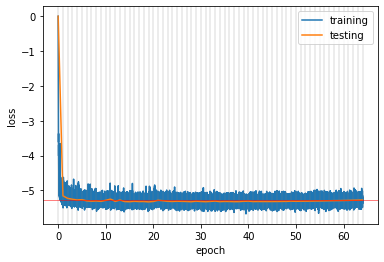

Batch:   0 Loss = -5.200466e+00,
Batch:  10 Loss = -5.189217e+00,
Batch:  20 Loss = -5.155308e+00,
Batch:  30 Loss = -5.347933e+00,
Batch:  40 Loss = -5.455191e+00,
Batch:  50 Loss = -5.299927e+00,
Batch:  60 Loss = -5.253318e+00,
Batch:  70 Loss = -5.251886e+00,
Batch:  80 Loss = -5.339303e+00,
Batch:  90 Loss = -5.300730e+00,
Batch: 100 Loss = -5.187150e+00,
Batch: 110 Loss = -5.365361e+00,
Batch: 120 Loss = -5.452526e+00,
Batch: 130 Loss = -5.337756e+00,
Batch: 140 Loss = -5.312442e+00,
Batch: 150 Loss = -5.257605e+00,
Batch: 160 Loss = -5.106241e+00,
Batch: 170 Loss = -5.237059e+00,
Batch: 180 Loss = -5.412368e+00,
Batch: 190 Loss = -5.301022e+00,
Batch: 200 Loss = -5.362257e+00,
Batch: 210 Loss = -5.306990e+00,
Batch: 220 Loss = -5.300705e+00,
Batch: 230 Loss = -5.264713e+00,
Batch: 240 Loss = -5.207866e+00,
Batch: 250 Loss = -5.178745e+00,
Batch: 260 Loss = -5.289799e+00,
Batch: 270 Loss = -5.364498e+00,
Batch: 280 Loss = -5.244576e+00,
Batch: 290 Loss = -5.287567e+00,
Batch: 300

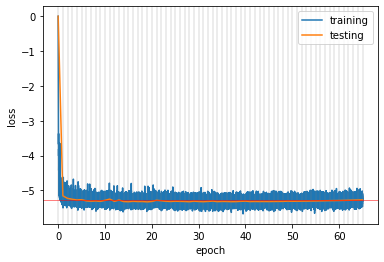

Batch:   0 Loss = -5.275452e+00,
Batch:  10 Loss = -5.378641e+00,
Batch:  20 Loss = -5.288074e+00,
Batch:  30 Loss = -5.336069e+00,
Batch:  40 Loss = -5.296308e+00,
Batch:  50 Loss = -5.249582e+00,
Batch:  60 Loss = -5.280655e+00,
Batch:  70 Loss = -5.288927e+00,
Batch:  80 Loss = -5.320765e+00,
Batch:  90 Loss = -5.224594e+00,
Batch: 100 Loss = -5.179729e+00,
Batch: 110 Loss = -5.213341e+00,
Batch: 120 Loss = -5.207148e+00,
Batch: 130 Loss = -5.242909e+00,
Batch: 140 Loss = -5.353088e+00,
Batch: 150 Loss = -5.268018e+00,
Batch: 160 Loss = -5.323628e+00,
Batch: 170 Loss = -5.200140e+00,
Batch: 180 Loss = -5.302696e+00,
Batch: 190 Loss = -5.168173e+00,
Batch: 200 Loss = -5.360487e+00,
Batch: 210 Loss = -5.276103e+00,
Batch: 220 Loss = -5.379873e+00,
Batch: 230 Loss = -5.173491e+00,
Batch: 240 Loss = -5.264259e+00,
Batch: 250 Loss = -5.209910e+00,
Batch: 260 Loss = -5.272134e+00,
Batch: 270 Loss = -5.316979e+00,
Batch: 280 Loss = -5.233869e+00,
Batch: 290 Loss = -5.198589e+00,
Batch: 300

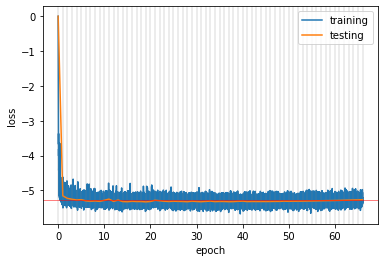

Batch:   0 Loss = -5.166480e+00,
Batch:  10 Loss = -5.344344e+00,
Batch:  20 Loss = -5.163531e+00,
Batch:  30 Loss = -5.267563e+00,
Batch:  40 Loss = -5.354936e+00,
Batch:  50 Loss = -5.259258e+00,
Batch:  60 Loss = -5.075835e+00,
Batch:  70 Loss = -5.352111e+00,
Batch:  80 Loss = -5.182636e+00,
Batch:  90 Loss = -5.335347e+00,
Batch: 100 Loss = -5.344410e+00,
Batch: 110 Loss = -5.414277e+00,
Batch: 120 Loss = -5.181476e+00,
Batch: 130 Loss = -5.326631e+00,
Batch: 140 Loss = -5.332895e+00,
Batch: 150 Loss = -5.131217e+00,
Batch: 160 Loss = -5.247791e+00,
Batch: 170 Loss = -5.353729e+00,
Batch: 180 Loss = -5.350320e+00,
Batch: 190 Loss = -5.368240e+00,
Batch: 200 Loss = -5.312011e+00,
Batch: 210 Loss = -5.109412e+00,
Batch: 220 Loss = -5.264217e+00,
Batch: 230 Loss = -5.308481e+00,
Batch: 240 Loss = -5.194311e+00,
Batch: 250 Loss = -5.351597e+00,
Batch: 260 Loss = -5.173699e+00,
Batch: 270 Loss = -5.120974e+00,
Batch: 280 Loss = -5.203338e+00,
Batch: 290 Loss = -5.256414e+00,
Batch: 300

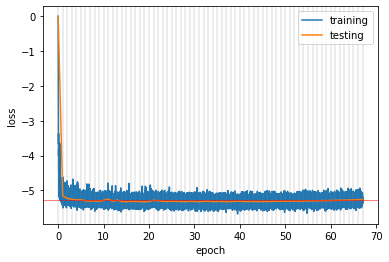

Batch:   0 Loss = -5.237892e+00,
Batch:  10 Loss = -5.172099e+00,
Batch:  20 Loss = -5.318813e+00,
Batch:  30 Loss = -5.258235e+00,
Batch:  40 Loss = -5.156729e+00,
Batch:  50 Loss = -5.329824e+00,
Batch:  60 Loss = -5.251607e+00,
Batch:  70 Loss = -5.374173e+00,
Batch:  80 Loss = -5.356448e+00,
Batch:  90 Loss = -5.198193e+00,
Batch: 100 Loss = -5.334994e+00,
Batch: 110 Loss = -5.203952e+00,
Batch: 120 Loss = -5.391696e+00,
Batch: 130 Loss = -5.107253e+00,
Batch: 140 Loss = -5.169134e+00,
Batch: 150 Loss = -5.231273e+00,
Batch: 160 Loss = -5.285869e+00,
Batch: 170 Loss = -5.315367e+00,
Batch: 180 Loss = -5.171794e+00,
Batch: 190 Loss = -5.226934e+00,
Batch: 200 Loss = -5.317944e+00,
Batch: 210 Loss = -5.172399e+00,
Batch: 220 Loss = -5.182048e+00,
Batch: 230 Loss = -5.212215e+00,
Batch: 240 Loss = -5.325879e+00,
Batch: 250 Loss = -5.465456e+00,
Batch: 260 Loss = -5.129561e+00,
Batch: 270 Loss = -5.265997e+00,
Batch: 280 Loss = -5.266457e+00,
Batch: 290 Loss = -5.210967e+00,
Batch: 300

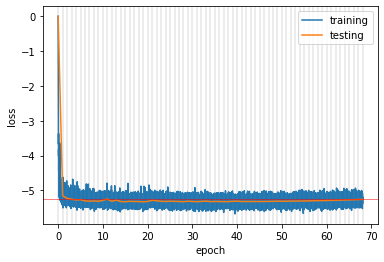

Batch:   0 Loss = -5.258562e+00,
Batch:  10 Loss = -5.227250e+00,
Batch:  20 Loss = -5.307529e+00,
Batch:  30 Loss = -5.332585e+00,
Batch:  40 Loss = -5.358109e+00,
Batch:  50 Loss = -5.347961e+00,
Batch:  60 Loss = -5.225185e+00,
Batch:  70 Loss = -5.358807e+00,
Batch:  80 Loss = -5.260514e+00,
Batch:  90 Loss = -5.358281e+00,
Batch: 100 Loss = -5.319869e+00,
Batch: 110 Loss = -5.169946e+00,
Batch: 120 Loss = -5.373011e+00,
Batch: 130 Loss = -4.987720e+00,
Batch: 140 Loss = -5.245508e+00,
Batch: 150 Loss = -5.334619e+00,
Batch: 160 Loss = -5.263270e+00,
Batch: 170 Loss = -5.131523e+00,
Batch: 180 Loss = -5.271281e+00,
Batch: 190 Loss = -5.317347e+00,
Batch: 200 Loss = -5.175598e+00,
Batch: 210 Loss = -5.417223e+00,
Batch: 220 Loss = -5.253078e+00,
Batch: 230 Loss = -5.338208e+00,
Batch: 240 Loss = -5.197485e+00,
Batch: 250 Loss = -5.129343e+00,
Batch: 260 Loss = -5.179054e+00,
Batch: 270 Loss = -5.204903e+00,
Batch: 280 Loss = -5.210472e+00,
Batch: 290 Loss = -5.252652e+00,
Batch: 300

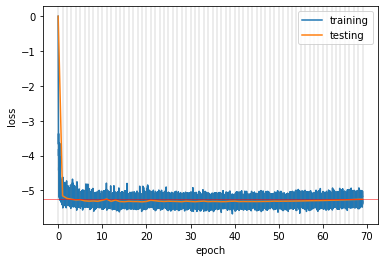

Batch:   0 Loss = -5.189113e+00,
Batch:  10 Loss = -5.122587e+00,
Batch:  20 Loss = -5.382294e+00,
Batch:  30 Loss = -5.448159e+00,
Batch:  40 Loss = -5.279043e+00,
Batch:  50 Loss = -5.276034e+00,
Batch:  60 Loss = -5.222510e+00,
Batch:  70 Loss = -5.235040e+00,
Batch:  80 Loss = -5.251993e+00,
Batch:  90 Loss = -5.104250e+00,
Batch: 100 Loss = -5.191753e+00,
Batch: 110 Loss = -5.195449e+00,
Batch: 120 Loss = -5.237099e+00,
Batch: 130 Loss = -5.330108e+00,
Batch: 140 Loss = -5.450011e+00,
Batch: 150 Loss = -5.303750e+00,
Batch: 160 Loss = -5.275704e+00,
Batch: 170 Loss = -5.222528e+00,
Batch: 180 Loss = -5.231310e+00,
Batch: 190 Loss = -5.157423e+00,
Batch: 200 Loss = -5.154088e+00,
Batch: 210 Loss = -5.397970e+00,
Batch: 220 Loss = -5.363299e+00,
Batch: 230 Loss = -5.023248e+00,
Batch: 240 Loss = -5.256067e+00,
Batch: 250 Loss = -5.165070e+00,
Batch: 260 Loss = -5.339221e+00,
Batch: 270 Loss = -5.112186e+00,
Batch: 280 Loss = -5.233770e+00,
Batch: 290 Loss = -5.380102e+00,
Batch: 300

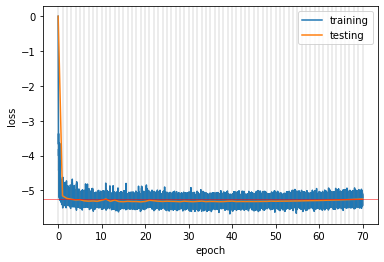

Batch:   0 Loss = -5.300849e+00,
Batch:  10 Loss = -5.271966e+00,
Batch:  20 Loss = -5.280218e+00,
Batch:  30 Loss = -5.274057e+00,
Batch:  40 Loss = -5.275500e+00,
Batch:  50 Loss = -5.361732e+00,
Batch:  60 Loss = -5.232683e+00,
Batch:  70 Loss = -5.291543e+00,
Batch:  80 Loss = -5.256728e+00,
Batch:  90 Loss = -5.334346e+00,
Batch: 100 Loss = -5.374149e+00,
Batch: 110 Loss = -5.014670e+00,
Batch: 120 Loss = -5.266556e+00,
Batch: 130 Loss = -5.397344e+00,
Batch: 140 Loss = -5.107548e+00,
Batch: 150 Loss = -5.370724e+00,
Batch: 160 Loss = -5.301169e+00,
Batch: 170 Loss = -5.166941e+00,
Batch: 180 Loss = -5.176358e+00,
Batch: 190 Loss = -5.231562e+00,
Batch: 200 Loss = -5.260722e+00,
Batch: 210 Loss = -5.261053e+00,
Batch: 220 Loss = -5.325738e+00,
Batch: 230 Loss = -5.340355e+00,
Batch: 240 Loss = -5.419566e+00,
Batch: 250 Loss = -5.223608e+00,
Batch: 260 Loss = -5.522120e+00,
Batch: 270 Loss = -5.260845e+00,
Batch: 280 Loss = -5.311439e+00,
Batch: 290 Loss = -5.043223e+00,
Batch: 300

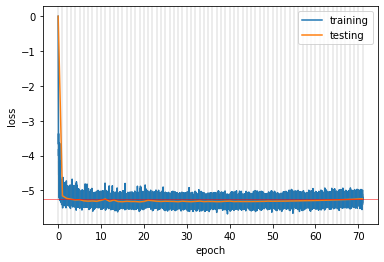

Batch:   0 Loss = -5.236296e+00,
Batch:  10 Loss = -5.314463e+00,
Batch:  20 Loss = -5.143302e+00,
Batch:  30 Loss = -5.312793e+00,
Batch:  40 Loss = -5.282812e+00,
Batch:  50 Loss = -5.236068e+00,
Batch:  60 Loss = -5.220073e+00,
Batch:  70 Loss = -5.330880e+00,
Batch:  80 Loss = -5.161860e+00,
Batch:  90 Loss = -5.276685e+00,
Batch: 100 Loss = -5.141523e+00,
Batch: 110 Loss = -5.439193e+00,
Batch: 120 Loss = -5.233122e+00,
Batch: 130 Loss = -5.197756e+00,
Batch: 140 Loss = -5.389141e+00,
Batch: 150 Loss = -5.270645e+00,
Batch: 160 Loss = -5.352141e+00,
Batch: 170 Loss = -5.240921e+00,
Batch: 180 Loss = -5.195304e+00,
Batch: 190 Loss = -4.934235e+00,
Batch: 200 Loss = -5.130123e+00,
Batch: 210 Loss = -5.266212e+00,
Batch: 220 Loss = -5.192977e+00,
Batch: 230 Loss = -5.234221e+00,
Batch: 240 Loss = -5.269572e+00,
Batch: 250 Loss = -5.342789e+00,
Batch: 260 Loss = -5.209866e+00,
Batch: 270 Loss = -5.180228e+00,
Batch: 280 Loss = -5.204784e+00,
Batch: 290 Loss = -5.456763e+00,
Batch: 300

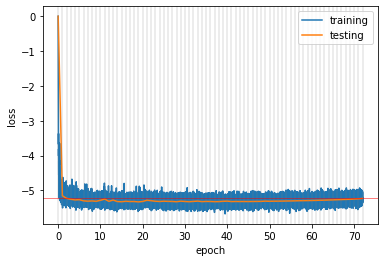

Batch:   0 Loss = -5.311789e+00,
Batch:  10 Loss = -5.142744e+00,
Batch:  20 Loss = -5.080257e+00,
Batch:  30 Loss = -5.352053e+00,
Batch:  40 Loss = -5.277409e+00,
Batch:  50 Loss = -5.274941e+00,
Batch:  60 Loss = -5.204566e+00,
Batch:  70 Loss = -5.194015e+00,
Batch:  80 Loss = -5.363471e+00,
Batch:  90 Loss = -5.337376e+00,
Batch: 100 Loss = -5.289298e+00,
Batch: 110 Loss = -5.104622e+00,
Batch: 120 Loss = -5.212447e+00,
Batch: 130 Loss = -5.299638e+00,
Batch: 140 Loss = -5.261211e+00,
Batch: 150 Loss = -5.085876e+00,
Batch: 160 Loss = -5.251631e+00,
Batch: 170 Loss = -5.141657e+00,
Batch: 180 Loss = -5.235447e+00,
Batch: 190 Loss = -5.222803e+00,
Batch: 200 Loss = -5.399539e+00,
Batch: 210 Loss = -5.090211e+00,
Batch: 220 Loss = -5.261824e+00,
Batch: 230 Loss = -5.289698e+00,
Batch: 240 Loss = -5.063038e+00,
Batch: 250 Loss = -5.194771e+00,
Batch: 260 Loss = -5.178519e+00,
Batch: 270 Loss = -5.089153e+00,
Batch: 280 Loss = -5.335458e+00,
Batch: 290 Loss = -5.328361e+00,
Batch: 300

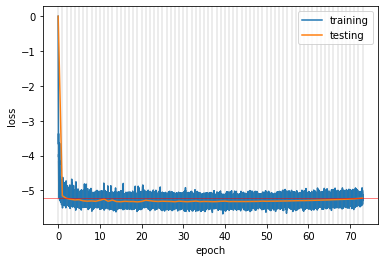

Batch:   0 Loss = -5.279813e+00,
Batch:  10 Loss = -5.208524e+00,
Batch:  20 Loss = -5.064197e+00,
Batch:  30 Loss = -5.426817e+00,
Batch:  40 Loss = -5.291296e+00,
Batch:  50 Loss = -5.149895e+00,
Batch:  60 Loss = -5.265576e+00,
Batch:  70 Loss = -5.350030e+00,
Batch:  80 Loss = -5.275061e+00,
Batch:  90 Loss = -5.130495e+00,
Batch: 100 Loss = -5.298422e+00,
Batch: 110 Loss = -5.311972e+00,
Batch: 120 Loss = -5.110171e+00,
Batch: 130 Loss = -5.121503e+00,
Batch: 140 Loss = -5.217318e+00,
Batch: 150 Loss = -5.269198e+00,
Batch: 160 Loss = -5.183029e+00,
Batch: 170 Loss = -5.238900e+00,
Batch: 180 Loss = -5.355300e+00,
Batch: 190 Loss = -5.255675e+00,
Batch: 200 Loss = -5.295441e+00,
Batch: 210 Loss = -5.249653e+00,
Batch: 220 Loss = -5.033898e+00,
Batch: 230 Loss = -5.175910e+00,
Batch: 240 Loss = -5.347923e+00,
Batch: 250 Loss = -5.019133e+00,
Batch: 260 Loss = -5.218976e+00,
Batch: 270 Loss = -5.209205e+00,
Batch: 280 Loss = -5.282563e+00,
Batch: 290 Loss = -5.236455e+00,
Batch: 300

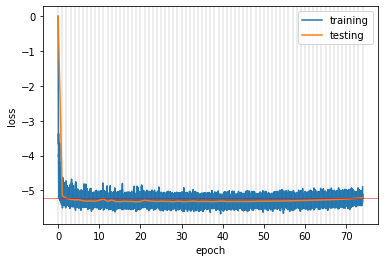

Batch:   0 Loss = -5.204911e+00,
Batch:  10 Loss = -5.247196e+00,
Batch:  20 Loss = -5.149569e+00,
Batch:  30 Loss = -5.174226e+00,
Batch:  40 Loss = -5.382106e+00,
Batch:  50 Loss = -5.092559e+00,
Batch:  60 Loss = -5.255776e+00,
Batch:  70 Loss = -5.334257e+00,
Batch:  80 Loss = -5.168476e+00,
Batch:  90 Loss = -5.314300e+00,
Batch: 100 Loss = -5.285334e+00,
Batch: 110 Loss = -5.180921e+00,
Batch: 120 Loss = -5.273413e+00,
Batch: 130 Loss = -5.201321e+00,
Batch: 140 Loss = -5.225328e+00,
Batch: 150 Loss = -5.104428e+00,
Batch: 160 Loss = -5.245251e+00,
Batch: 170 Loss = -5.248545e+00,
Batch: 180 Loss = -5.165444e+00,
Batch: 190 Loss = -5.108774e+00,
Batch: 200 Loss = -5.159607e+00,
Batch: 210 Loss = -5.070271e+00,
Batch: 220 Loss = -5.226890e+00,
Batch: 230 Loss = -5.310350e+00,
Batch: 240 Loss = -5.362458e+00,
Batch: 250 Loss = -5.157116e+00,
Batch: 260 Loss = -5.131945e+00,
Batch: 270 Loss = -5.206649e+00,
Batch: 280 Loss = -4.994943e+00,
Batch: 290 Loss = -5.401626e+00,
Batch: 300

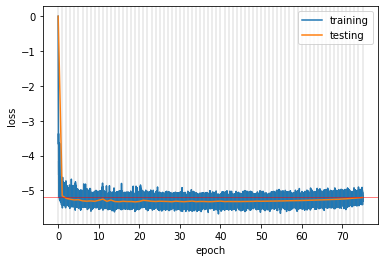

Batch:   0 Loss = -5.197901e+00,
Batch:  10 Loss = -5.349205e+00,
Batch:  20 Loss = -5.259466e+00,
Batch:  30 Loss = -5.210350e+00,
Batch:  40 Loss = -5.147021e+00,
Batch:  50 Loss = -5.028332e+00,
Batch:  60 Loss = -5.063773e+00,
Batch:  70 Loss = -5.112255e+00,
Batch:  80 Loss = -5.185972e+00,
Batch:  90 Loss = -5.210670e+00,
Batch: 100 Loss = -5.170337e+00,
Batch: 110 Loss = -5.338679e+00,
Batch: 120 Loss = -5.312927e+00,
Batch: 130 Loss = -5.144325e+00,
Batch: 140 Loss = -5.172962e+00,
Batch: 150 Loss = -5.208076e+00,
Batch: 160 Loss = -5.155981e+00,
Batch: 170 Loss = -5.165921e+00,
Batch: 180 Loss = -5.132910e+00,
Batch: 190 Loss = -5.240734e+00,
Batch: 200 Loss = -5.288186e+00,
Batch: 210 Loss = -5.239173e+00,
Batch: 220 Loss = -5.233717e+00,
Batch: 230 Loss = -5.362633e+00,
Batch: 240 Loss = -5.268036e+00,
Batch: 250 Loss = -5.282623e+00,
Batch: 260 Loss = -5.256370e+00,
Batch: 270 Loss = -5.242419e+00,
Batch: 280 Loss = -5.318343e+00,
Batch: 290 Loss = -5.124551e+00,
Batch: 300

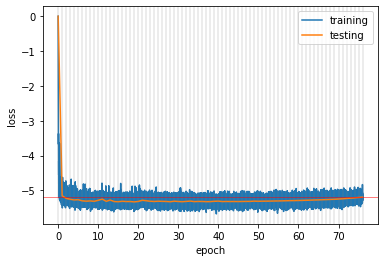

Batch:   0 Loss = -5.107463e+00,
Batch:  10 Loss = -5.149500e+00,
Batch:  20 Loss = -5.231869e+00,
Batch:  30 Loss = -5.356955e+00,
Batch:  40 Loss = -5.080005e+00,
Batch:  50 Loss = -5.195539e+00,
Batch:  60 Loss = -5.221117e+00,
Batch:  70 Loss = -5.071320e+00,
Batch:  80 Loss = -5.298628e+00,
Batch:  90 Loss = -5.148712e+00,
Batch: 100 Loss = -5.139241e+00,
Batch: 110 Loss = -5.272141e+00,
Batch: 120 Loss = -5.087510e+00,
Batch: 130 Loss = -5.253440e+00,
Batch: 140 Loss = -4.975507e+00,
Batch: 150 Loss = -5.371708e+00,
Batch: 160 Loss = -5.314721e+00,
Batch: 170 Loss = -5.148695e+00,
Batch: 180 Loss = -5.164556e+00,
Batch: 190 Loss = -5.203524e+00,
Batch: 200 Loss = -5.142710e+00,
Batch: 210 Loss = -5.334672e+00,
Batch: 220 Loss = -5.257398e+00,
Batch: 230 Loss = -5.286684e+00,
Batch: 240 Loss = -5.241081e+00,
Batch: 250 Loss = -5.312735e+00,
Batch: 260 Loss = -5.095266e+00,
Batch: 270 Loss = -5.263822e+00,
Batch: 280 Loss = -5.219099e+00,
Batch: 290 Loss = -5.116683e+00,
Batch: 300

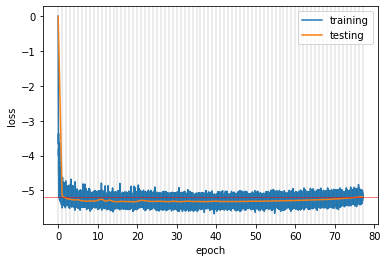

Batch:   0 Loss = -5.326180e+00,
Batch:  10 Loss = -5.233222e+00,
Batch:  20 Loss = -5.126481e+00,
Batch:  30 Loss = -5.173817e+00,
Batch:  40 Loss = -5.140874e+00,
Batch:  50 Loss = -5.216672e+00,
Batch:  60 Loss = -5.163831e+00,
Batch:  70 Loss = -5.127399e+00,
Batch:  80 Loss = -5.122694e+00,
Batch:  90 Loss = -5.160759e+00,
Batch: 100 Loss = -5.233059e+00,
Batch: 110 Loss = -5.011559e+00,
Batch: 120 Loss = -5.263755e+00,
Batch: 130 Loss = -5.151729e+00,
Batch: 140 Loss = -5.191908e+00,
Batch: 150 Loss = -5.174724e+00,
Batch: 160 Loss = -5.298467e+00,
Batch: 170 Loss = -5.265067e+00,
Batch: 180 Loss = -5.382603e+00,
Batch: 190 Loss = -5.061409e+00,
Batch: 200 Loss = -5.167112e+00,
Batch: 210 Loss = -5.158923e+00,
Batch: 220 Loss = -5.308896e+00,
Batch: 230 Loss = -5.262568e+00,
Batch: 240 Loss = -5.330772e+00,
Batch: 250 Loss = -5.209288e+00,
Batch: 260 Loss = -5.246908e+00,
Batch: 270 Loss = -5.175712e+00,
Batch: 280 Loss = -5.249495e+00,
Batch: 290 Loss = -5.146272e+00,
Batch: 300

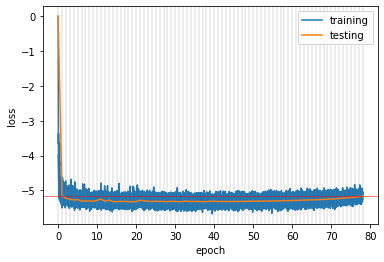

Batch:   0 Loss = -4.971720e+00,
Batch:  10 Loss = -5.248565e+00,
Batch:  20 Loss = -5.029751e+00,
Batch:  30 Loss = -5.195519e+00,
Batch:  40 Loss = -5.165357e+00,
Batch:  50 Loss = -5.093694e+00,
Batch:  60 Loss = -5.198618e+00,
Batch:  70 Loss = -5.079914e+00,
Batch:  80 Loss = -5.322900e+00,
Batch:  90 Loss = -5.012341e+00,
Batch: 100 Loss = -5.298334e+00,
Batch: 110 Loss = -5.191738e+00,
Batch: 120 Loss = -5.053956e+00,
Batch: 130 Loss = -5.122696e+00,
Batch: 140 Loss = -5.182371e+00,
Batch: 150 Loss = -5.040473e+00,
Batch: 160 Loss = -5.206588e+00,
Batch: 170 Loss = -5.155132e+00,
Batch: 180 Loss = -5.068273e+00,
Batch: 190 Loss = -5.189284e+00,
Batch: 200 Loss = -5.208861e+00,
Batch: 210 Loss = -5.202247e+00,
Batch: 220 Loss = -5.120038e+00,
Batch: 230 Loss = -5.228620e+00,
Batch: 240 Loss = -5.198361e+00,
Batch: 250 Loss = -5.137552e+00,
Batch: 260 Loss = -5.062643e+00,
Batch: 270 Loss = -5.160069e+00,
Batch: 280 Loss = -5.240237e+00,
Batch: 290 Loss = -5.315431e+00,
Batch: 300

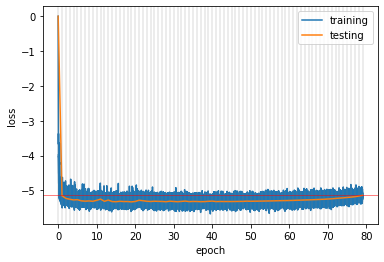

Batch:   0 Loss = -5.245331e+00,
Batch:  10 Loss = -5.131929e+00,
Batch:  20 Loss = -5.089078e+00,
Batch:  30 Loss = -5.139347e+00,
Batch:  40 Loss = -5.128393e+00,
Batch:  50 Loss = -5.221777e+00,
Batch:  60 Loss = -5.132768e+00,
Batch:  70 Loss = -5.249612e+00,
Batch:  80 Loss = -5.172088e+00,
Batch:  90 Loss = -5.042787e+00,
Batch: 100 Loss = -5.210532e+00,
Batch: 110 Loss = -5.079044e+00,
Batch: 120 Loss = -5.151857e+00,
Batch: 130 Loss = -5.180066e+00,
Batch: 140 Loss = -5.136189e+00,
Batch: 150 Loss = -5.121356e+00,
Batch: 160 Loss = -5.012316e+00,
Batch: 170 Loss = -5.213624e+00,
Batch: 180 Loss = -5.096235e+00,
Batch: 190 Loss = -5.184005e+00,
Batch: 200 Loss = -5.331658e+00,
Batch: 210 Loss = -5.106081e+00,
Batch: 220 Loss = -5.118336e+00,
Batch: 230 Loss = -5.068964e+00,
Batch: 240 Loss = -5.136149e+00,
Batch: 250 Loss = -5.084302e+00,
Batch: 260 Loss = -5.270792e+00,
Batch: 270 Loss = -5.023609e+00,
Batch: 280 Loss = -5.137223e+00,
Batch: 290 Loss = -5.115741e+00,
Batch: 300

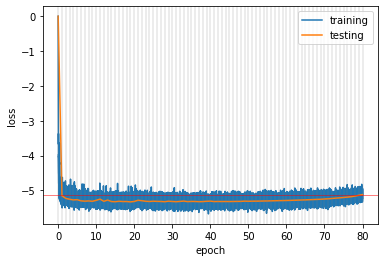

Batch:   0 Loss = -5.274426e+00,
Batch:  10 Loss = -5.266333e+00,
Batch:  20 Loss = -5.054541e+00,
Batch:  30 Loss = -5.212834e+00,
Batch:  40 Loss = -5.087555e+00,
Batch:  50 Loss = -5.025582e+00,
Batch:  60 Loss = -4.842464e+00,
Batch:  70 Loss = -5.083632e+00,
Batch:  80 Loss = -5.152585e+00,
Batch:  90 Loss = -5.060196e+00,
Batch: 100 Loss = -5.032618e+00,
Batch: 110 Loss = -5.228158e+00,
Batch: 120 Loss = -5.131412e+00,
Batch: 130 Loss = -5.040198e+00,
Batch: 140 Loss = -5.057824e+00,
Batch: 150 Loss = -4.932978e+00,
Batch: 160 Loss = -5.110087e+00,
Batch: 170 Loss = -5.213432e+00,
Batch: 180 Loss = -5.082571e+00,
Batch: 190 Loss = -5.119165e+00,
Batch: 200 Loss = -5.027164e+00,
Batch: 210 Loss = -5.025606e+00,
Batch: 220 Loss = -5.143665e+00,
Batch: 230 Loss = -4.981635e+00,
Batch: 240 Loss = -4.937605e+00,
Batch: 250 Loss = -5.123603e+00,
Batch: 260 Loss = -5.104516e+00,
Batch: 270 Loss = -5.098754e+00,
Batch: 280 Loss = -5.010333e+00,
Batch: 290 Loss = -4.989036e+00,
Batch: 300

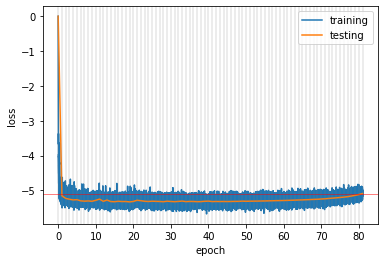

Batch:   0 Loss = -5.073168e+00,
Batch:  10 Loss = -5.170600e+00,
Batch:  20 Loss = -5.095760e+00,
Batch:  30 Loss = -5.021559e+00,
Batch:  40 Loss = -5.079023e+00,
Batch:  50 Loss = -5.107641e+00,
Batch:  60 Loss = -5.150872e+00,
Batch:  70 Loss = -4.943584e+00,
Batch:  80 Loss = -5.112495e+00,
Batch:  90 Loss = -5.026184e+00,
Batch: 100 Loss = -5.200812e+00,
Batch: 110 Loss = -5.106270e+00,
Batch: 120 Loss = -5.151366e+00,
Batch: 130 Loss = -4.992843e+00,
Batch: 140 Loss = -4.966600e+00,
Batch: 150 Loss = -5.140976e+00,
Batch: 160 Loss = -5.000717e+00,
Batch: 170 Loss = -5.025084e+00,
Batch: 180 Loss = -4.992751e+00,
Batch: 190 Loss = -4.906028e+00,
Batch: 200 Loss = -5.088998e+00,
Batch: 210 Loss = -5.100655e+00,
Batch: 220 Loss = -5.030495e+00,
Batch: 230 Loss = -4.976483e+00,
Batch: 240 Loss = -5.062040e+00,
Batch: 250 Loss = -5.033605e+00,
Batch: 260 Loss = -4.951370e+00,
Batch: 270 Loss = -5.139233e+00,
Batch: 280 Loss = -5.106522e+00,
Batch: 290 Loss = -5.091960e+00,
Batch: 300

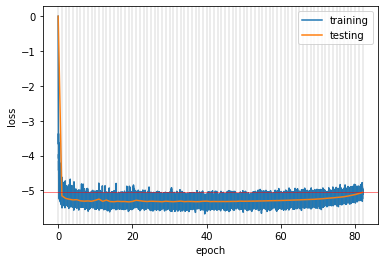

Batch:   0 Loss = -4.921099e+00,
Batch:  10 Loss = -5.015797e+00,
Batch:  20 Loss = -5.240193e+00,
Batch:  30 Loss = -5.032689e+00,
Batch:  40 Loss = -5.088736e+00,
Batch:  50 Loss = -5.108336e+00,
Batch:  60 Loss = -5.119620e+00,
Batch:  70 Loss = -5.175301e+00,
Batch:  80 Loss = -5.212283e+00,
Batch:  90 Loss = -5.044656e+00,
Batch: 100 Loss = -5.029521e+00,
Batch: 110 Loss = -5.063474e+00,
Batch: 120 Loss = -5.082012e+00,
Batch: 130 Loss = -5.053366e+00,
Batch: 140 Loss = -5.034250e+00,
Batch: 150 Loss = -4.940625e+00,
Batch: 160 Loss = -5.060673e+00,
Batch: 170 Loss = -4.953850e+00,
Batch: 180 Loss = -5.097523e+00,
Batch: 190 Loss = -5.068848e+00,
Batch: 200 Loss = -5.139461e+00,
Batch: 210 Loss = -5.083473e+00,
Batch: 220 Loss = -5.097403e+00,
Batch: 230 Loss = -4.932476e+00,
Batch: 240 Loss = -5.159781e+00,
Batch: 250 Loss = -5.028792e+00,
Batch: 260 Loss = -4.845492e+00,
Batch: 270 Loss = -5.061427e+00,
Batch: 280 Loss = -5.190469e+00,
Batch: 290 Loss = -4.962294e+00,
Batch: 300

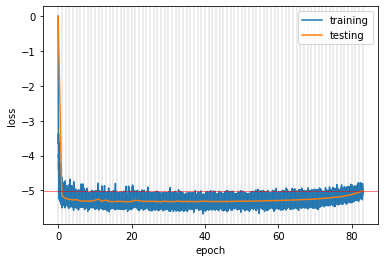

Batch:   0 Loss = -5.119200e+00,
Batch:  10 Loss = -4.975733e+00,
Batch:  20 Loss = -5.034555e+00,
Batch:  30 Loss = -4.988230e+00,
Batch:  40 Loss = -4.979535e+00,
Batch:  50 Loss = -4.940334e+00,
Batch:  60 Loss = -5.085127e+00,
Batch:  70 Loss = -5.076130e+00,
Batch:  80 Loss = -5.157882e+00,
Batch:  90 Loss = -4.971437e+00,
Batch: 100 Loss = -5.007855e+00,
Batch: 110 Loss = -5.087758e+00,
Batch: 120 Loss = -5.135612e+00,
Batch: 130 Loss = -5.099224e+00,
Batch: 140 Loss = -4.813384e+00,
Batch: 150 Loss = -5.011865e+00,
Batch: 160 Loss = -4.993110e+00,
Batch: 170 Loss = -5.015688e+00,
Batch: 180 Loss = -5.025702e+00,
Batch: 190 Loss = -4.753968e+00,
Batch: 200 Loss = -4.915566e+00,
Batch: 210 Loss = -4.992671e+00,
Batch: 220 Loss = -4.949987e+00,
Batch: 230 Loss = -5.018589e+00,
Batch: 240 Loss = -5.089921e+00,
Batch: 250 Loss = -4.953826e+00,
Batch: 260 Loss = -4.983084e+00,
Batch: 270 Loss = -5.008467e+00,
Batch: 280 Loss = -5.049373e+00,
Batch: 290 Loss = -4.771581e+00,
Batch: 300

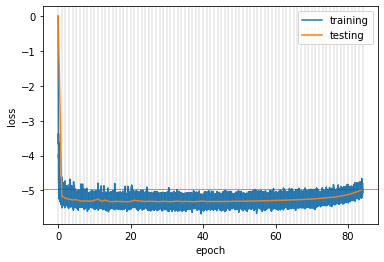

Batch:   0 Loss = -5.112350e+00,
Batch:  10 Loss = -4.939438e+00,
Batch:  20 Loss = -5.025518e+00,
Batch:  30 Loss = -4.848644e+00,
Batch:  40 Loss = -5.025755e+00,
Batch:  50 Loss = -4.958447e+00,
Batch:  60 Loss = -4.973974e+00,
Batch:  70 Loss = -5.117807e+00,
Batch:  80 Loss = -4.988736e+00,
Batch:  90 Loss = -4.972717e+00,
Batch: 100 Loss = -4.874921e+00,
Batch: 110 Loss = -4.841619e+00,
Batch: 120 Loss = -4.932735e+00,
Batch: 130 Loss = -5.051903e+00,
Batch: 140 Loss = -4.867641e+00,
Batch: 150 Loss = -5.023344e+00,
Batch: 160 Loss = -4.812387e+00,
Batch: 170 Loss = -5.001146e+00,
Batch: 180 Loss = -4.856188e+00,
Batch: 190 Loss = -4.995334e+00,
Batch: 200 Loss = -4.962106e+00,
Batch: 210 Loss = -4.953877e+00,
Batch: 220 Loss = -5.006659e+00,
Batch: 230 Loss = -4.926586e+00,
Batch: 240 Loss = -5.025395e+00,
Batch: 250 Loss = -4.973390e+00,
Batch: 260 Loss = -5.061716e+00,
Batch: 270 Loss = -5.033378e+00,
Batch: 280 Loss = -4.845805e+00,
Batch: 290 Loss = -4.910652e+00,
Batch: 300

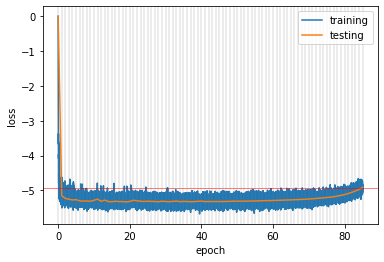

Batch:   0 Loss = -4.881507e+00,
Batch:  10 Loss = -4.812114e+00,
Batch:  20 Loss = -4.993801e+00,
Batch:  30 Loss = -4.813269e+00,
Batch:  40 Loss = -4.899673e+00,
Batch:  50 Loss = -4.950396e+00,
Batch:  60 Loss = -4.984612e+00,
Batch:  70 Loss = -4.867924e+00,
Batch:  80 Loss = -4.949517e+00,
Batch:  90 Loss = -4.892718e+00,
Batch: 100 Loss = -4.892172e+00,
Batch: 110 Loss = -4.851678e+00,
Batch: 120 Loss = -4.930641e+00,
Batch: 130 Loss = -4.940068e+00,
Batch: 140 Loss = -4.891301e+00,
Batch: 150 Loss = -5.000221e+00,
Batch: 160 Loss = -4.824863e+00,
Batch: 170 Loss = -4.921106e+00,
Batch: 180 Loss = -5.028671e+00,
Batch: 190 Loss = -4.784787e+00,
Batch: 200 Loss = -4.950349e+00,
Batch: 210 Loss = -4.914999e+00,
Batch: 220 Loss = -4.735829e+00,
Batch: 230 Loss = -4.847045e+00,
Batch: 240 Loss = -5.007187e+00,
Batch: 250 Loss = -4.918601e+00,
Batch: 260 Loss = -4.997241e+00,
Batch: 270 Loss = -4.998440e+00,
Batch: 280 Loss = -4.834499e+00,
Batch: 290 Loss = -4.914576e+00,
Batch: 300

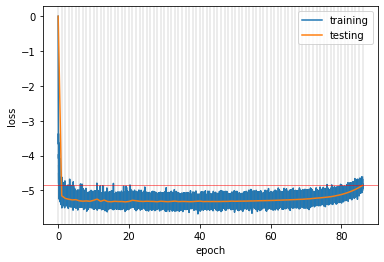

Batch:   0 Loss = -4.882570e+00,
Batch:  10 Loss = -4.875292e+00,
Batch:  20 Loss = -4.959689e+00,
Batch:  30 Loss = -4.844303e+00,
Batch:  40 Loss = -4.932128e+00,
Batch:  50 Loss = -4.941786e+00,
Batch:  60 Loss = -4.740050e+00,
Batch:  70 Loss = -4.786292e+00,
Batch:  80 Loss = -4.818863e+00,
Batch:  90 Loss = -4.877491e+00,
Batch: 100 Loss = -4.783018e+00,
Batch: 110 Loss = -4.803103e+00,
Batch: 120 Loss = -4.789134e+00,
Batch: 130 Loss = -4.825990e+00,
Batch: 140 Loss = -4.789854e+00,
Batch: 150 Loss = -4.738686e+00,
Batch: 160 Loss = -4.872331e+00,
Batch: 170 Loss = -4.868228e+00,
Batch: 180 Loss = -4.877032e+00,
Batch: 190 Loss = -4.792614e+00,
Batch: 200 Loss = -4.773703e+00,
Batch: 210 Loss = -4.802340e+00,
Batch: 220 Loss = -4.781693e+00,
Batch: 230 Loss = -4.799374e+00,
Batch: 240 Loss = -4.895593e+00,
Batch: 250 Loss = -4.787117e+00,
Batch: 260 Loss = -4.802042e+00,
Batch: 270 Loss = -4.782169e+00,
Batch: 280 Loss = -4.729447e+00,
Batch: 290 Loss = -4.447546e+00,
Batch: 300

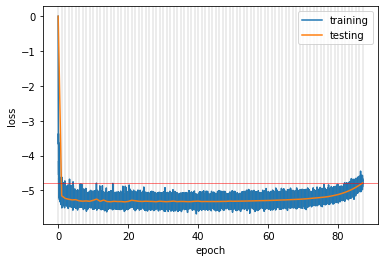

Batch:   0 Loss = -4.745154e+00,
Batch:  10 Loss = -4.795979e+00,
Batch:  20 Loss = -4.703078e+00,
Batch:  30 Loss = -4.757252e+00,
Batch:  40 Loss = -4.660869e+00,
Batch:  50 Loss = -4.854541e+00,
Batch:  60 Loss = -4.818039e+00,
Batch:  70 Loss = -4.828132e+00,
Batch:  80 Loss = -4.817383e+00,
Batch:  90 Loss = -4.649557e+00,
Batch: 100 Loss = -4.882337e+00,
Batch: 110 Loss = -4.743018e+00,
Batch: 120 Loss = -4.756625e+00,
Batch: 130 Loss = -4.689601e+00,
Batch: 140 Loss = -4.808252e+00,
Batch: 150 Loss = -4.804189e+00,
Batch: 160 Loss = -4.674608e+00,
Batch: 170 Loss = -4.919247e+00,
Batch: 180 Loss = -4.766515e+00,
Batch: 190 Loss = -4.833993e+00,
Batch: 200 Loss = -4.875746e+00,
Batch: 210 Loss = -4.559438e+00,
Batch: 220 Loss = -4.772238e+00,
Batch: 230 Loss = -4.833716e+00,
Batch: 240 Loss = -4.744887e+00,
Batch: 250 Loss = -4.779766e+00,
Batch: 260 Loss = -4.679374e+00,
Batch: 270 Loss = -4.699062e+00,
Batch: 280 Loss = -4.751473e+00,
Batch: 290 Loss = -4.799770e+00,
Batch: 300

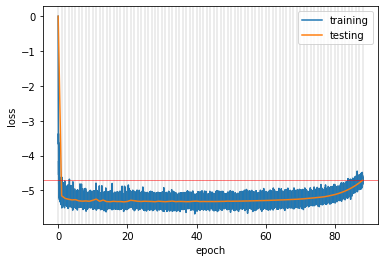

Batch:   0 Loss = -4.822081e+00,
Batch:  10 Loss = -4.659083e+00,
Batch:  20 Loss = -4.643511e+00,
Batch:  30 Loss = -4.855450e+00,
Batch:  40 Loss = -4.772555e+00,
Batch:  50 Loss = -4.604273e+00,
Batch:  60 Loss = -4.731246e+00,
Batch:  70 Loss = -4.693058e+00,
Batch:  80 Loss = -4.779648e+00,
Batch:  90 Loss = -4.671647e+00,
Batch: 100 Loss = -4.686765e+00,
Batch: 110 Loss = -4.576920e+00,
Batch: 120 Loss = -4.493382e+00,
Batch: 130 Loss = -4.809031e+00,
Batch: 140 Loss = -4.731241e+00,
Batch: 150 Loss = -4.721879e+00,
Batch: 160 Loss = -4.740548e+00,
Batch: 170 Loss = -4.839293e+00,
Batch: 180 Loss = -4.808993e+00,
Batch: 190 Loss = -4.752788e+00,
Batch: 200 Loss = -4.663973e+00,
Batch: 210 Loss = -4.646113e+00,
Batch: 220 Loss = -4.742368e+00,
Batch: 230 Loss = -4.688647e+00,
Batch: 240 Loss = -4.720073e+00,
Batch: 250 Loss = -4.626883e+00,
Batch: 260 Loss = -4.681801e+00,
Batch: 270 Loss = -4.837532e+00,
Batch: 280 Loss = -4.707704e+00,
Batch: 290 Loss = -4.618088e+00,
Batch: 300

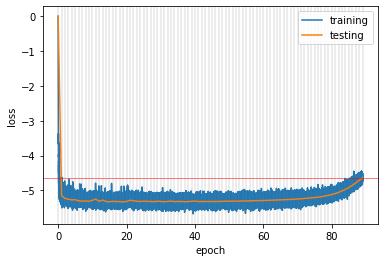

Batch:   0 Loss = -4.612130e+00,
Batch:  10 Loss = -4.591093e+00,
Batch:  20 Loss = -4.682498e+00,
Batch:  30 Loss = -4.601783e+00,
Batch:  40 Loss = -4.604614e+00,
Batch:  50 Loss = -4.595789e+00,
Batch:  60 Loss = -4.698668e+00,
Batch:  70 Loss = -4.572625e+00,
Batch:  80 Loss = -4.738589e+00,
Batch:  90 Loss = -4.672031e+00,
Batch: 100 Loss = -4.608253e+00,
Batch: 110 Loss = -4.687030e+00,
Batch: 120 Loss = -4.655166e+00,
Batch: 130 Loss = -4.639968e+00,
Batch: 140 Loss = -4.487324e+00,
Batch: 150 Loss = -4.556040e+00,
Batch: 160 Loss = -4.523716e+00,
Batch: 170 Loss = -4.581292e+00,
Batch: 180 Loss = -4.697450e+00,
Batch: 190 Loss = -4.536202e+00,
Batch: 200 Loss = -4.313838e+00,
Batch: 210 Loss = -4.605759e+00,
Batch: 220 Loss = -4.504986e+00,
Batch: 230 Loss = -4.563500e+00,
Batch: 240 Loss = -4.676623e+00,
Batch: 250 Loss = -4.645774e+00,
Batch: 260 Loss = -4.727030e+00,
Batch: 270 Loss = -4.593260e+00,
Batch: 280 Loss = -4.608015e+00,
Batch: 290 Loss = -4.601793e+00,
Batch: 300

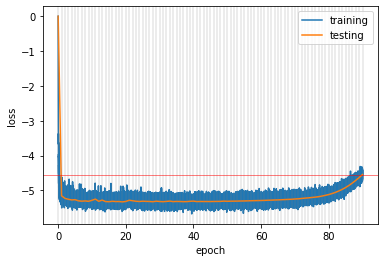

Batch:   0 Loss = -4.462880e+00,
Batch:  10 Loss = -4.568806e+00,
Batch:  20 Loss = -4.419522e+00,
Batch:  30 Loss = -4.460838e+00,
Batch:  40 Loss = -4.481397e+00,
Batch:  50 Loss = -4.561304e+00,
Batch:  60 Loss = -4.544692e+00,
Batch:  70 Loss = -4.409358e+00,
Batch:  80 Loss = -4.392614e+00,
Batch:  90 Loss = -4.581347e+00,
Batch: 100 Loss = -4.479657e+00,
Batch: 110 Loss = -4.529131e+00,
Batch: 120 Loss = -4.370751e+00,
Batch: 130 Loss = -4.524568e+00,
Batch: 140 Loss = -4.594725e+00,
Batch: 150 Loss = -4.270720e+00,
Batch: 160 Loss = -4.548613e+00,
Batch: 170 Loss = -4.464423e+00,
Batch: 180 Loss = -4.406667e+00,
Batch: 190 Loss = -4.555820e+00,
Batch: 200 Loss = -4.535355e+00,
Batch: 210 Loss = -4.451729e+00,
Batch: 220 Loss = -4.529567e+00,
Batch: 230 Loss = -4.553039e+00,
Batch: 240 Loss = -4.438264e+00,
Batch: 250 Loss = -4.477422e+00,
Batch: 260 Loss = -4.503200e+00,
Batch: 270 Loss = -4.440203e+00,
Batch: 280 Loss = -4.401567e+00,
Batch: 290 Loss = -4.577514e+00,
Batch: 300

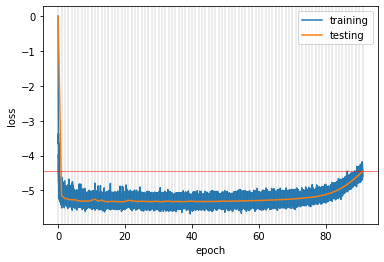

Batch:   0 Loss = -4.602769e+00,
Batch:  10 Loss = -4.393108e+00,
Batch:  20 Loss = -4.562735e+00,
Batch:  30 Loss = -4.492936e+00,
Batch:  40 Loss = -4.312733e+00,
Batch:  50 Loss = -4.414217e+00,
Batch:  60 Loss = -4.436645e+00,
Batch:  70 Loss = -4.365678e+00,
Batch:  80 Loss = -4.266680e+00,
Batch:  90 Loss = -4.514355e+00,
Batch: 100 Loss = -4.542743e+00,
Batch: 110 Loss = -4.321580e+00,
Batch: 120 Loss = -4.435083e+00,
Batch: 130 Loss = -4.458630e+00,
Batch: 140 Loss = -4.466142e+00,
Batch: 150 Loss = -4.420767e+00,
Batch: 160 Loss = -4.465239e+00,
Batch: 170 Loss = -4.428263e+00,
Batch: 180 Loss = -4.392909e+00,
Batch: 190 Loss = -4.457793e+00,
Batch: 200 Loss = -4.357791e+00,
Batch: 210 Loss = -4.515130e+00,
Batch: 220 Loss = -4.370956e+00,
Batch: 230 Loss = -4.491548e+00,
Batch: 240 Loss = -4.375317e+00,
Batch: 250 Loss = -4.275014e+00,
Batch: 260 Loss = -4.470303e+00,
Batch: 270 Loss = -4.424666e+00,
Batch: 280 Loss = -4.539770e+00,
Batch: 290 Loss = -4.432274e+00,
Batch: 300

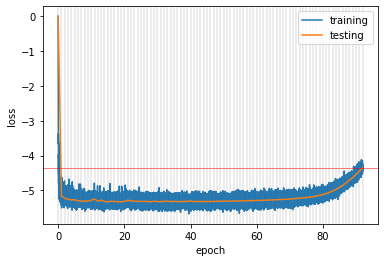

Batch:   0 Loss = -4.293412e+00,
Batch:  10 Loss = -4.437548e+00,
Batch:  20 Loss = -4.262831e+00,
Batch:  30 Loss = -4.295215e+00,
Batch:  40 Loss = -4.261659e+00,
Batch:  50 Loss = -4.341900e+00,
Batch:  60 Loss = -4.378174e+00,
Batch:  70 Loss = -4.364125e+00,
Batch:  80 Loss = -4.324651e+00,
Batch:  90 Loss = -4.263511e+00,
Batch: 100 Loss = -4.450554e+00,
Batch: 110 Loss = -4.432292e+00,
Batch: 120 Loss = -4.195445e+00,
Batch: 130 Loss = -4.356363e+00,
Batch: 140 Loss = -4.404535e+00,
Batch: 150 Loss = -4.348228e+00,
Batch: 160 Loss = -4.222051e+00,
Batch: 170 Loss = -4.256194e+00,
Batch: 180 Loss = -4.322025e+00,
Batch: 190 Loss = -4.335989e+00,
Batch: 200 Loss = -4.441670e+00,
Batch: 210 Loss = -4.369101e+00,
Batch: 220 Loss = -4.271643e+00,
Batch: 230 Loss = -4.365247e+00,
Batch: 240 Loss = -4.396757e+00,
Batch: 250 Loss = -4.215609e+00,
Batch: 260 Loss = -4.349270e+00,
Batch: 270 Loss = -4.372225e+00,
Batch: 280 Loss = -4.330549e+00,
Batch: 290 Loss = -4.424111e+00,
Batch: 300

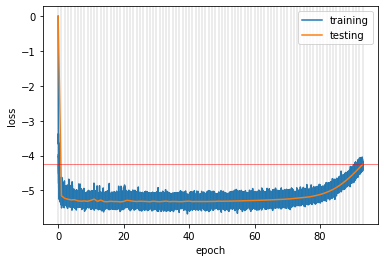

Batch:   0 Loss = -4.281998e+00,
Batch:  10 Loss = -4.209139e+00,
Batch:  20 Loss = -4.184229e+00,
Batch:  30 Loss = -4.234804e+00,
Batch:  40 Loss = -4.293297e+00,
Batch:  50 Loss = -4.171942e+00,
Batch:  60 Loss = -4.239561e+00,
Batch:  70 Loss = -4.237769e+00,
Batch:  80 Loss = -4.169740e+00,
Batch:  90 Loss = -4.240931e+00,
Batch: 100 Loss = -4.216683e+00,
Batch: 110 Loss = -4.231078e+00,
Batch: 120 Loss = -4.211923e+00,
Batch: 130 Loss = -4.211570e+00,
Batch: 140 Loss = -4.275842e+00,
Batch: 150 Loss = -4.182324e+00,
Batch: 160 Loss = -4.230206e+00,
Batch: 170 Loss = -4.146465e+00,
Batch: 180 Loss = -4.125687e+00,
Batch: 190 Loss = -4.232427e+00,
Batch: 200 Loss = -4.245030e+00,
Batch: 210 Loss = -4.174537e+00,
Batch: 220 Loss = -4.224003e+00,
Batch: 230 Loss = -4.235303e+00,
Batch: 240 Loss = -4.285578e+00,
Batch: 250 Loss = -4.292772e+00,
Batch: 260 Loss = -4.057180e+00,
Batch: 270 Loss = -4.336226e+00,
Batch: 280 Loss = -4.212162e+00,
Batch: 290 Loss = -4.274251e+00,
Batch: 300

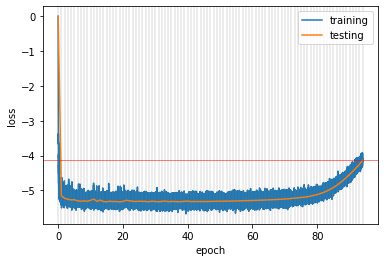

Batch:   0 Loss = -4.035209e+00,
Batch:  10 Loss = -4.149022e+00,
Batch:  20 Loss = -4.156973e+00,
Batch:  30 Loss = -4.147260e+00,
Batch:  40 Loss = -4.131823e+00,
Batch:  50 Loss = -4.169413e+00,
Batch:  60 Loss = -4.215025e+00,
Batch:  70 Loss = -4.147713e+00,
Batch:  80 Loss = -4.081912e+00,
Batch:  90 Loss = -4.018351e+00,
Batch: 100 Loss = -4.130343e+00,
Batch: 110 Loss = -4.132985e+00,
Batch: 120 Loss = -4.145935e+00,
Batch: 130 Loss = -4.058871e+00,
Batch: 140 Loss = -4.037784e+00,
Batch: 150 Loss = -4.135906e+00,
Batch: 160 Loss = -4.106644e+00,
Batch: 170 Loss = -4.125649e+00,
Batch: 180 Loss = -4.142243e+00,
Batch: 190 Loss = -4.013863e+00,
Batch: 200 Loss = -4.120591e+00,
Batch: 210 Loss = -4.069010e+00,
Batch: 220 Loss = -4.008747e+00,
Batch: 230 Loss = -3.914801e+00,
Batch: 240 Loss = -4.247110e+00,
Batch: 250 Loss = -4.078184e+00,
Batch: 260 Loss = -4.121595e+00,
Batch: 270 Loss = -4.085088e+00,
Batch: 280 Loss = -4.099370e+00,
Batch: 290 Loss = -3.985257e+00,
Batch: 300

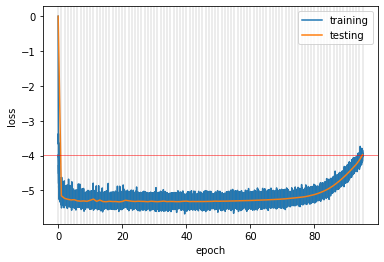

Batch:   0 Loss = -4.074348e+00,
Batch:  10 Loss = -3.823489e+00,
Batch:  20 Loss = -4.087889e+00,
Batch:  30 Loss = -3.822308e+00,
Batch:  40 Loss = -3.867049e+00,
Batch:  50 Loss = -3.999930e+00,
Batch:  60 Loss = -4.009710e+00,
Batch:  70 Loss = -3.820048e+00,
Batch:  80 Loss = -3.961792e+00,
Batch:  90 Loss = -3.937540e+00,
Batch: 100 Loss = -4.068262e+00,
Batch: 110 Loss = -3.935792e+00,
Batch: 120 Loss = -4.004884e+00,
Batch: 130 Loss = -3.876959e+00,
Batch: 140 Loss = -3.975703e+00,
Batch: 150 Loss = -3.998953e+00,
Batch: 160 Loss = -3.944627e+00,
Batch: 170 Loss = -3.941108e+00,
Batch: 180 Loss = -4.015508e+00,
Batch: 190 Loss = -3.946445e+00,
Batch: 200 Loss = -3.921186e+00,
Batch: 210 Loss = -3.875506e+00,
Batch: 220 Loss = -3.698156e+00,
Batch: 230 Loss = -3.896956e+00,
Batch: 240 Loss = -3.921460e+00,
Batch: 250 Loss = -3.935996e+00,
Batch: 260 Loss = -3.961598e+00,
Batch: 270 Loss = -3.982310e+00,
Batch: 280 Loss = -4.079397e+00,
Batch: 290 Loss = -3.894004e+00,
Batch: 300

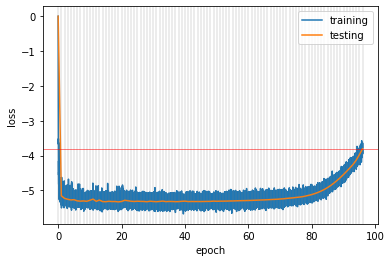

Batch:   0 Loss = -3.910132e+00,
Batch:  10 Loss = -3.834765e+00,
Batch:  20 Loss = -3.979198e+00,
Batch:  30 Loss = -3.842448e+00,
Batch:  40 Loss = -3.775288e+00,
Batch:  50 Loss = -3.840615e+00,
Batch:  60 Loss = -3.827131e+00,
Batch:  70 Loss = -3.945431e+00,
Batch:  80 Loss = -3.718225e+00,
Batch:  90 Loss = -4.086337e+00,
Batch: 100 Loss = -3.683291e+00,
Batch: 110 Loss = -3.877001e+00,
Batch: 120 Loss = -3.807292e+00,
Batch: 130 Loss = -3.811976e+00,
Batch: 140 Loss = -3.658050e+00,
Batch: 150 Loss = -3.727144e+00,
Batch: 160 Loss = -3.838529e+00,
Batch: 170 Loss = -3.942537e+00,
Batch: 180 Loss = -3.784828e+00,
Batch: 190 Loss = -3.836197e+00,
Batch: 200 Loss = -3.845291e+00,
Batch: 210 Loss = -3.767617e+00,
Batch: 220 Loss = -3.793059e+00,
Batch: 230 Loss = -3.828485e+00,
Batch: 240 Loss = -3.579486e+00,
Batch: 250 Loss = -3.729840e+00,
Batch: 260 Loss = -3.841399e+00,
Batch: 270 Loss = -3.930283e+00,
Batch: 280 Loss = -3.735200e+00,
Batch: 290 Loss = -3.824242e+00,
Batch: 300

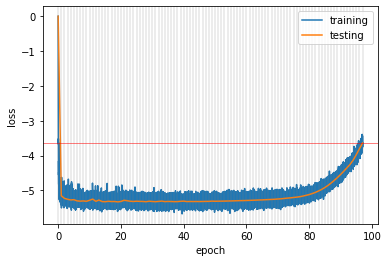

Batch:   0 Loss = -3.587752e+00,
Batch:  10 Loss = -3.559743e+00,
Batch:  20 Loss = -3.684570e+00,
Batch:  30 Loss = -3.701087e+00,
Batch:  40 Loss = -3.667286e+00,
Batch:  50 Loss = -3.587963e+00,
Batch:  60 Loss = -3.706841e+00,
Batch:  70 Loss = -3.695461e+00,
Batch:  80 Loss = -3.659447e+00,
Batch:  90 Loss = -3.703843e+00,
Batch: 100 Loss = -3.530668e+00,
Batch: 110 Loss = -3.620880e+00,
Batch: 120 Loss = -3.690110e+00,
Batch: 130 Loss = -3.667817e+00,
Batch: 140 Loss = -3.712663e+00,
Batch: 150 Loss = -3.685997e+00,
Batch: 160 Loss = -3.701068e+00,
Batch: 170 Loss = -3.627989e+00,
Batch: 180 Loss = -3.604081e+00,
Batch: 190 Loss = -3.581525e+00,
Batch: 200 Loss = -3.532934e+00,
Batch: 210 Loss = -3.673089e+00,
Batch: 220 Loss = -3.611031e+00,
Batch: 230 Loss = -3.591411e+00,
Batch: 240 Loss = -3.574141e+00,
Batch: 250 Loss = -3.662852e+00,
Batch: 260 Loss = -3.570102e+00,
Batch: 270 Loss = -3.586312e+00,
Batch: 280 Loss = -3.618259e+00,
Batch: 290 Loss = -3.688574e+00,
Batch: 300

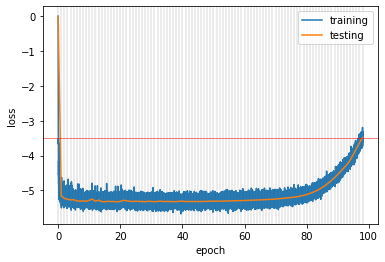

Batch:   0 Loss = -3.489183e+00,
Batch:  10 Loss = -3.398548e+00,
Batch:  20 Loss = -3.446815e+00,
Batch:  30 Loss = -3.507998e+00,
Batch:  40 Loss = -3.615735e+00,
Batch:  50 Loss = -3.491861e+00,
Batch:  60 Loss = -3.657426e+00,
Batch:  70 Loss = -3.262151e+00,
Batch:  80 Loss = -3.527074e+00,
Batch:  90 Loss = -3.650414e+00,
Batch: 100 Loss = -3.551652e+00,
Batch: 110 Loss = -3.504996e+00,
Batch: 120 Loss = -3.555289e+00,
Batch: 130 Loss = -3.521108e+00,
Batch: 140 Loss = -3.296736e+00,
Batch: 150 Loss = -3.480986e+00,
Batch: 160 Loss = -3.530215e+00,
Batch: 170 Loss = -3.377662e+00,
Batch: 180 Loss = -3.384220e+00,
Batch: 190 Loss = -3.334588e+00,
Batch: 200 Loss = -3.562618e+00,
Batch: 210 Loss = -3.436701e+00,
Batch: 220 Loss = -3.472768e+00,
Batch: 230 Loss = -3.483280e+00,
Batch: 240 Loss = -3.340220e+00,
Batch: 250 Loss = -3.591700e+00,
Batch: 260 Loss = -3.550476e+00,
Batch: 270 Loss = -3.323131e+00,
Batch: 280 Loss = -3.257970e+00,
Batch: 290 Loss = -3.475812e+00,
Batch: 300

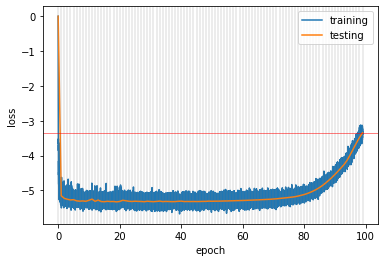

Batch:   0 Loss = -3.356478e+00,
Batch:  10 Loss = -3.383119e+00,
Batch:  20 Loss = -3.319152e+00,
Batch:  30 Loss = -3.423620e+00,
Batch:  40 Loss = -3.325173e+00,
Batch:  50 Loss = -3.455826e+00,
Batch:  60 Loss = -3.506742e+00,
Batch:  70 Loss = -3.372251e+00,
Batch:  80 Loss = -3.244052e+00,
Batch:  90 Loss = -3.290976e+00,
Batch: 100 Loss = -3.452640e+00,
Batch: 110 Loss = -3.307097e+00,
Batch: 120 Loss = -3.206842e+00,
Batch: 130 Loss = -3.378272e+00,
Batch: 140 Loss = -3.285444e+00,
Batch: 150 Loss = -3.328456e+00,
Batch: 160 Loss = -3.425837e+00,
Batch: 170 Loss = -3.310404e+00,
Batch: 180 Loss = -3.407344e+00,
Batch: 190 Loss = -3.261045e+00,
Batch: 200 Loss = -3.347117e+00,
Batch: 210 Loss = -3.397327e+00,
Batch: 220 Loss = -3.307645e+00,
Batch: 230 Loss = -3.244830e+00,
Batch: 240 Loss = -3.230577e+00,
Batch: 250 Loss = -3.364596e+00,
Batch: 260 Loss = -3.371325e+00,
Batch: 270 Loss = -3.426256e+00,
Batch: 280 Loss = -3.397690e+00,
Batch: 290 Loss = -3.375108e+00,
Batch: 300

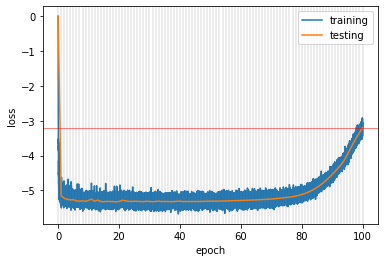

In [20]:
bkg_epochs = 100
bkgdist, losses, test_losses = train_iflow(combined.drop(columns='signal') ,M=3500, deltaM=200,
                              issig=False, batchsize=256, lr=1e-3, epochs=bkg_epochs,
                              weight_decay=1e-5) #do not use learning rate schedule

Model loaded successfully
Model loaded successfully
Model loaded successfully
Model loaded successfully
Model loaded successfully
Model loaded successfully
Model loaded successfully
Model loaded successfully
Model loaded successfully
Model loaded successfully


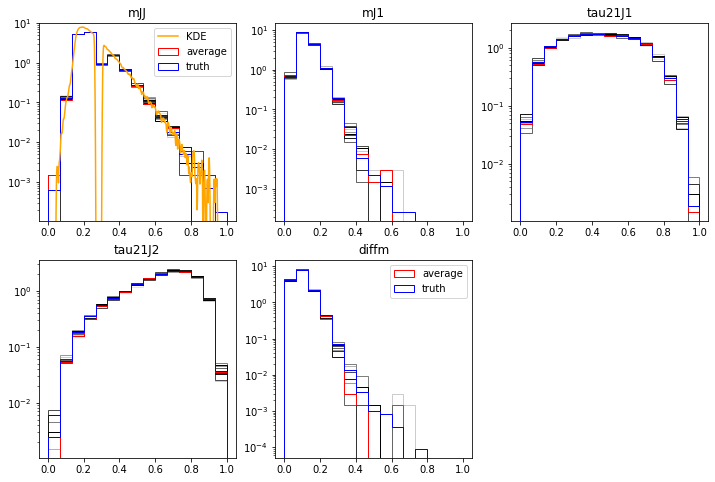

In [39]:
last_epochs = np.arange(bkg_epochs-10, bkg_epochs)
last_epochs = last_epochs[last_epochs >= 0]
plot_learned_distributions(bkgdist, np.arange(15, 25), 'bkg_', 10000,
                           truth=data_bkg_train.drop(columns='signal'), special_dim=0)

### Evaluate results of learning

In [22]:
combined.signal = combined.signal.astype(float)
data_SB, data_SR, invM = prepare_data_train(3500,200, 
                                             combined.query('dataset=="training"').drop(columns='dataset'),
                                             ignore=['signal'])
data_SR = tf.convert_to_tensor(data_SR.values)
data_SB = tf.convert_to_tensor(data_SB.values)

efficiency in SR when cutting edges of hypercube: 0.45


In [23]:
#mixed = tfd.Mixture(cat=tfd.Categorical(probs=[tf.cast(1./len(sigdist), dtype=tf.float64)]*len(sigdist)),
#                    components=list(sigdist))
#print(mixed.sample(1))
#mixed.prob(mixed.sample(1))

In [23]:
#mixed = tfd.Mixture(cat=tfd.Categorical(probs=[1./len(sigdist)]*len(sigdist)),
#                    components=list(sigdist))
#print(mixed.sample(1))
#mixed.prob(mixed.sample(1))

# since the commented part raises an exception, this is a temporary workaround.
def get_prob(dists, sample):
    # turn sample into DataFrame
    sample = pd.DataFrame(sample.numpy())
    
    # assign a random distribution to each data point
    sample['dist_no'] = np.random.randint(len(dists), size=len(sample))
    
    # get the probabilities
    sample['prob'] = 0.
    for i in range(len(dists)):
        sample.loc[sample.dist_no == i, 'prob'] = dists[i].prob(sample[sample.dist_no == i].drop(columns=['dist_no', 'prob']).values).numpy()
    return tf.convert_to_tensor(sample.prob.values)
    
# bkgprob = get_prob(bkgdist, data_sig[:, :5])
# bkgprob=bkgdist.prob(data_SR[:, :5])
# sigprob = get_prob(sigdist, data_sig[:, :5])
# sigprob=sigdist.prob(data_SR[:, :5])
# bkglogprob=np.log(bkgprob)

cast back into pandas DataFrames

In [24]:
data_sig = pd.DataFrame(data_SR.numpy(), columns=['mJJ', 'mJ1', 'tau21J1', 'tau21J2', 'diffm', 'signal'])
data_sig['mJJ_unscaled'] = invM
data_sig.signal = (data_sig.signal - np.min(data_sig.signal)).astype('bool')
issignal = data_sig['signal']
mlt = pd.MultiIndex.from_product([['observables'], data_sig.columns])
data_sig.columns = mlt

In [25]:
for epoch in np.arange(sig_epochs):
    print('calculating sig_prob for epoch', epoch)
    load_weights(sigdist, epoch=epoch, prefix='sig_')
    data_sig['signal', 'prob_E{}'.format(epoch)] = sigdist.prob(data_SR[:, :5]).numpy()

calculating sig_prob for epoch 0
Model loaded successfully
calculating sig_prob for epoch 1
Model loaded successfully
calculating sig_prob for epoch 2
Model loaded successfully
calculating sig_prob for epoch 3
Model loaded successfully
calculating sig_prob for epoch 4
Model loaded successfully
calculating sig_prob for epoch 5
Model loaded successfully
calculating sig_prob for epoch 6
Model loaded successfully
calculating sig_prob for epoch 7
Model loaded successfully
calculating sig_prob for epoch 8
Model loaded successfully
calculating sig_prob for epoch 9
Model loaded successfully
calculating sig_prob for epoch 10
Model loaded successfully
calculating sig_prob for epoch 11
Model loaded successfully
calculating sig_prob for epoch 12
Model loaded successfully
calculating sig_prob for epoch 13
Model loaded successfully
calculating sig_prob for epoch 14
Model loaded successfully
calculating sig_prob for epoch 15
Model loaded successfully
calculating sig_prob for epoch 16
Model loaded suc

In [88]:
plot_epochs = np.arange(0, bkg_epochs, 20)
if not bkg_epochs-1 in plot_epochs:
    plot_epochs = np.concatenate((plot_epochs, [bkg_epochs-1]))
print(plot_epochs)
Rc_values = np.linspace(0, 5, 50)

[ 0 20 40 60 80 99]


In [91]:
for nn, epoch in enumerate(plot_epochs):
    print('calculating for background epoch', epoch)
    load_weights(bkgdist, epoch=epoch, prefix='bkg_')
    epoch_ID = 'E{}'.format(epoch)
    data_sig[epoch_ID, 'prob'] = bkgdist.prob(data_SR[:, :5]).numpy()
    data_sig[epoch_ID, 'logprob'] = np.log(data_sig[epoch_ID, 'prob'])
    data_sig[epoch_ID, 'R'] = data_sig['signal', 'prob_E{}'.format(sig_epochs-1)]/data_sig[epoch_ID, 'prob']

signals = data_sig[issignal].copy()
backgrounds = data_sig[~issignal].copy()
for nn, epoch in enumerate(plot_epochs):
    epoch_ID = 'E{}'.format(epoch)
    signals.sort_values(by=(epoch_ID, 'R'), ascending=False, inplace=True)
    signals[epoch_ID, 'count'] = np.arange(len(signals))
    backgrounds.sort_values(by=(epoch_ID, 'R'), ascending=False, inplace=True)
    backgrounds[epoch_ID, 'count'] = np.arange(len(backgrounds))

effs = pd.DataFrame(np.tile(Rc_values, len(plot_epochs)),
    columns = ['Rmin'],
    index=pd.MultiIndex.from_product([plot_epochs, np.arange(len(Rc_values))],
                                                     names=['epoch', 'idx']))
effs['sig_eff'] = effs.groupby('epoch').transform(
    lambda x: x.transform(lambda y: len(signals.loc[:, 'E{}'.format(x.index.values[0][0])].query('R > {}'.format(y)))/Nsig_SR)
                   )
effs['bkg_rej'] = effs.Rmin.groupby('epoch').transform(
    lambda x: x.transform(lambda y: Nbkg_SR/len(backgrounds.loc[:, 'E{}'.format(x.index.values[0][0])].query('R > {}'.format(y))))
                         )
effs['s_over_sqrtb'] = effs.sig_eff * np.sqrt(effs.bkg_rej)

calculating for background epoch 0
Model loaded successfully
calculating for background epoch 20
Model loaded successfully
calculating for background epoch 40
Model loaded successfully
calculating for background epoch 60
Model loaded successfully
calculating for background epoch 80
Model loaded successfully
calculating for background epoch 99
Model loaded successfully


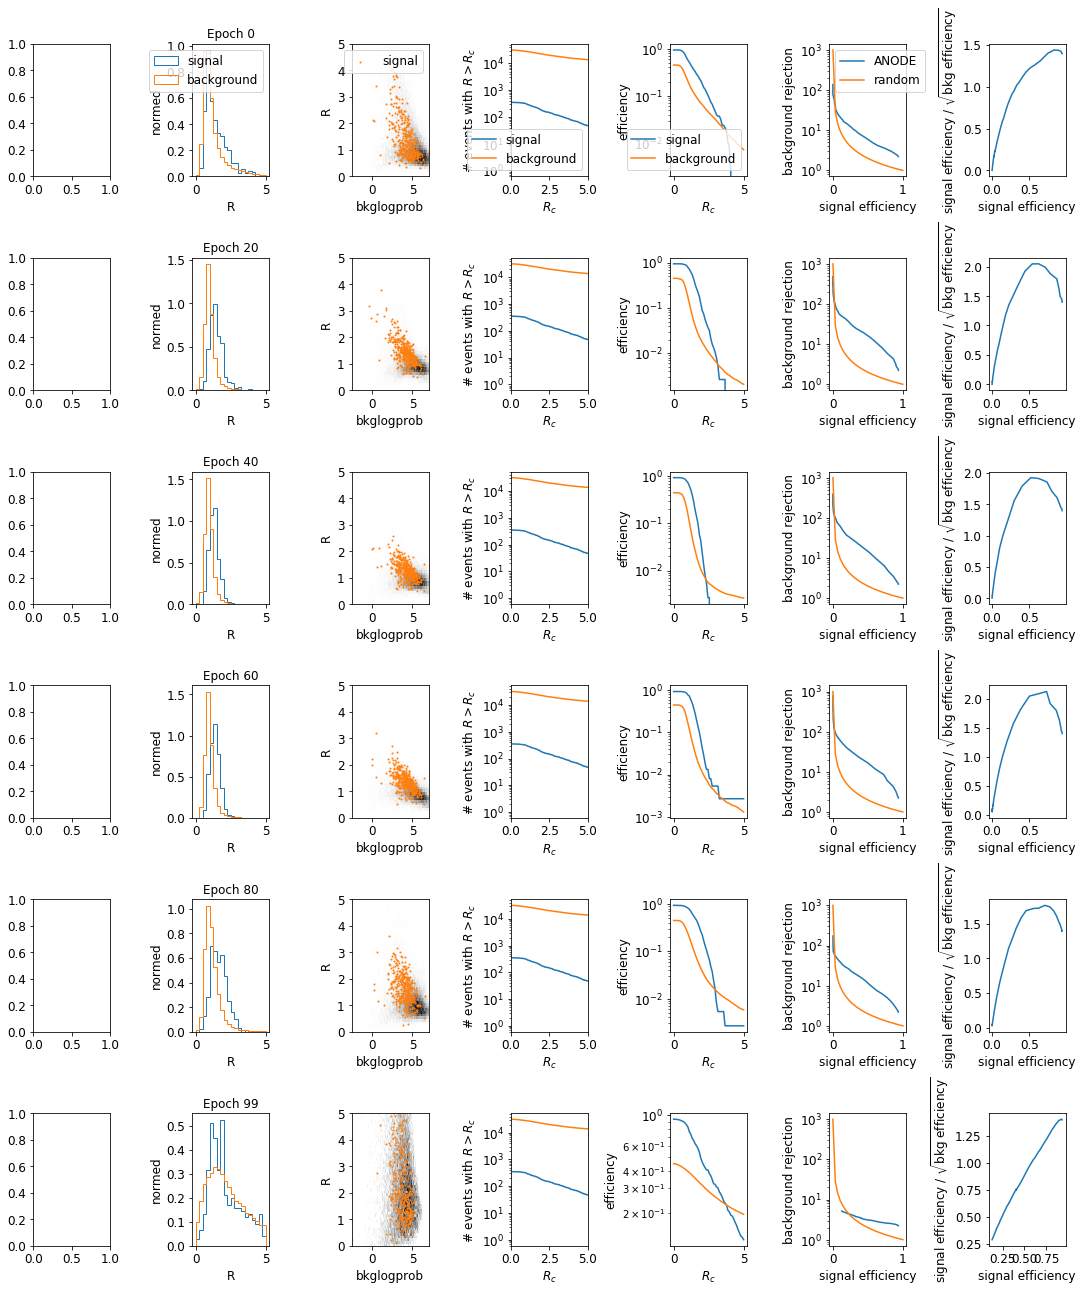

In [90]:
fs = 12
fig, axs = plt.subplots(len(plot_epochs), 7, figsize=(15, 3*len(plot_epochs)),
                        gridspec_kw={'width_ratios': [0.1, 1, 1, 1, 1, 1, 1]})
for nn, epoch in enumerate(plot_epochs):
    axs[nn, 1].hist(data_sig[issignal].loc[:, ('E{}'.format(epoch), 'R')],
                             bins=20, range=(0,5), histtype='step', density=True, label='signal')
    axs[nn, 1].hist(data_sig[~issignal].loc[:, ('E{}'.format(epoch), 'R')],
                             bins=20, range=(0,5), histtype='step', density=True, label='background')
    axs[nn, 1].set_xlabel('R')
    axs[nn, 1].set_ylabel('normed')
    axs[nn, 1].set_title('Epoch {}'.format(epoch))
    
    axs[nn, 2].hist2d(data_sig[~issignal].loc[:, ('E{}'.format(epoch), 'logprob')],
                         data_sig[~issignal].loc[:, ('E{}'.format(epoch), 'R')],
                         density=True, cmap='binary', bins=[95, 50], range=[(-2.5, 7), (0, 5)])
    axs[nn, 2].scatter(data_sig[issignal].loc[:, ('E{}'.format(epoch), 'logprob')],
                          data_sig[issignal].loc[:, ('E{}'.format(epoch), 'R')],
                          s=1, label='signal', color='C1')
    axs[nn, 2].set_ylim(0,5)
    axs[nn, 2].set_xlim(-2.5,7)
    axs[nn, 2].set_xlabel('bkglogprob')
    axs[nn, 2].set_ylabel('R')
    
    axs[nn, 3].plot(signals.loc[:, (epoch_ID, 'R')],
                       signals.loc[:, (epoch_ID, 'count')], label='signal')
    axs[nn, 3].plot(backgrounds.loc[:, (epoch_ID, 'R')],
                       backgrounds.loc[:, (epoch_ID, 'count')], label='background')
    axs[nn, 3].set_yscale('log')
    axs[nn, 3].set_ylabel('# events with $R > R_c$')
    axs[nn, 3].set_xlabel('$R_c$')
    axs[nn, 3].set_xlim(0,5)
    
    axs[nn, 4].plot(effs.loc[epoch].Rmin, effs.loc[epoch].sig_eff, label='signal')
    axs[nn, 4].plot(effs.loc[epoch].Rmin, 1/effs.loc[epoch].bkg_rej, label='background')
    axs[nn, 4].set_xlabel('$R_c$')
    axs[nn, 4].set_ylabel('efficiency')
    axs[nn, 4].set_yscale('log')

    axs[nn, 5].plot(effs.loc[epoch].sig_eff, effs.loc[epoch].bkg_rej, label='ANODE')
    axs[nn, 5].plot(np.linspace(0.001, 1, 30), 1/np.linspace(0.001, 1, 30), label='random')
    axs[nn, 5].set_yscale('log')
    axs[nn, 5].set_xlabel('signal efficiency')
    axs[nn, 5].set_ylabel('background rejection')
    
    axs[nn, 6].plot(effs.loc[epoch].sig_eff, effs.loc[epoch].s_over_sqrtb)
    axs[nn, 6].set_xlabel('signal efficiency')
    axs[nn, 6].set_ylabel('signal efficiency / $\sqrt{\mathrm{bkg~efficiency}}$')

    if nn == 0:
        axs[nn, 1].legend(fontsize=fs)
        axs[nn, 2].legend(fontsize=fs)
        axs[nn, 3].legend(fontsize=fs)
        axs[nn, 4].legend(fontsize=fs)
        axs[nn, 5].legend(fontsize=fs)

for ax in axs.flatten():
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
         ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fs)

plt.tight_layout()
plt.show()

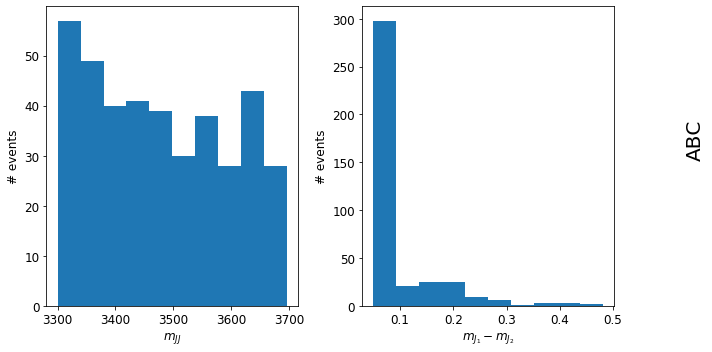

In [87]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5), gridspec_kw={'width_ratios': [3, 3, .2]})
Rc = 2.5
fs = 12

axs[0].hist(data_sig[data_sig.loc[:, 'E25'].R > Rc].loc[:, ('observables', 'mJJ_unscaled')])
axs[0].set_xlabel('$m_{JJ}$')
axs[0].set_ylabel('# events')

axs[1].hist(data_sig[data_sig.loc[:, 'E25'].R > Rc].loc[:, ('observables', 'diffm')])
axs[1].set_xlabel('$m_{J_1} - m_{J_2}$')
axs[1].set_ylabel('# events')


axs[2].text(0.5, 0.5, 'ABC', rotation=90, fontsize=20)
axs[2].axis('off')

for ax in axs.flatten():
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
         ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fs)


plt.tight_layout()
plt.show()

## Train NN for signal-background discrimination

In [36]:
# Get 10k events from learned distributions, requiring mJJ to be in the SR
events_per_category = 10000
mJJmin, mJJmax = min(data_sig.mJJ), max(data_sig.mJJ)
train_data = np.vstack((get_sample(bkgdist[-1], events_per_category, mJJmin, mJJmax),
                        get_sample(sigdist[-1], events_per_category, mJJmin, mJJmax)))
labels = np.concatenate((np.array([True]*events_per_category),
                    np.array([False]*events_per_category)))

In [37]:
model = build_SB_NN(5)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense_48 (Dense)             (None, 128)               768       
_________________________________________________________________
batch_normalization_32 (Batc (None, 128)               512       
_________________________________________________________________
dense_49 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_33 (Batc (None, 128)               512       
_________________________________________________________________
dense_50 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_34 (Batc (None, 128)               512 

In [38]:
model.fit(train_data, labels, epochs=5)

Train on 20000 samples
Epoch 1/5
20000/20000 [==============================] - 4s 207us/sample - loss: 0.7192 - accuracy: 0.4990
Epoch 2/5
20000/20000 [==============================] - 4s 182us/sample - loss: 0.7004 - accuracy: 0.5103
Epoch 3/5
20000/20000 [==============================] - 3s 162us/sample - loss: 0.6979 - accuracy: 0.5070
Epoch 4/5
20000/20000 [==============================] - 3s 161us/sample - loss: 0.6971 - accuracy: 0.5063
Epoch 5/5
20000/20000 [==============================] - 4s 187us/sample - loss: 0.6958 - accuracy: 0.5138


In [39]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

### analyze results

In [40]:
opt = {'range': (0.3, 0.7), 'histtype': 'step', 'density': True}
plt.hist(data_sig.sig_prob[data_sig.signal], label='signal', **opt)
plt.hist(data_sig.sig_prob[~data_sig.signal], label='background', **opt)
plt.xlabel('$p_\mathrm{sig}$')
plt.ylabel('normed')
plt.legend()
plt.show()

AttributeError: 'DataFrame' object has no attribute 'sig_prob'

In [ ]:
plt.hist(data_sig.query('(sig_prob > .6)').diffm)
plt.show()

In [ ]:
signals = data_sig[issignal].copy()
signals.sort_values(by='sig_prob', ascending=False, inplace=True)
signals['count'] = np.arange(len(signals))

backgrounds = data_sig[~issignal].copy()
backgrounds.sort_values(by='sig_prob', ascending=False, inplace=True)
backgrounds['count'] = np.arange(len(backgrounds))

In [ ]:
plt.plot(signals.sig_prob, signals['count'], label='signal')
plt.plot(backgrounds.sig_prob, backgrounds['count'], label='background')
plt.yscale('log')
plt.ylabel('# events with $p_\mathrm{sig} > p_c$')
plt.xlabel('$p_c$')
plt.legend()
plt.savefig('Events_vs_pc.png')
plt.show()

In [ ]:
effs2 = pd.DataFrame(np.linspace(0, 1, 50), columns=['pc'])
effs2['sig_eff'] = effs2.pc.transform(lambda x: len(signals.query('sig_prob > {}'.format(x)))/Nsig_SR)
effs2['bkg_rej'] = effs2.pc.transform(lambda x: Nbkg_SR/max(1e-20, len(backgrounds.query('sig_prob > {}'.format(x)))))
effs2['s_over_sqrtb'] = effs2.sig_eff * np.sqrt(effs2.bkg_rej)

In [ ]:
plt.plot(effs2.pc, effs2.sig_eff, label='signal')
plt.plot(effs2.pc, 1/effs2.bkg_rej, label='background')
plt.xlabel('$p_c$')
plt.ylabel('efficiency')
plt.yscale('log')
plt.ylim(1e-3, 1)
plt.legend()
plt.show()

In [ ]:
plt.plot(effs2.sig_eff, effs2.bkg_rej, label='ANODE+')
plt.plot(effs.sig_eff, effs.bkg_rej, label='ANODE')
plt.plot(np.linspace(0.001, 1, 30), 1/np.linspace(0.001, 1, 30), label='random')
plt.yscale('log')
plt.xlabel('signal efficiency')
plt.ylabel('background rejection')
plt.ylim(1, 1e3)
plt.legend()
plt.savefig('ROC.png')
plt.show()

In [ ]:
plt.plot(effs2.sig_eff, effs2.s_over_sqrtb, label='ANODE+')
plt.plot(effs.sig_eff, effs.s_over_sqrtb, label='ANODE')
plt.legend()
plt.xlabel('signal efficiency')
plt.ylabel('signal efficiency / $\sqrt{\mathrm{bkg~efficiency}}$')
plt.show()

## Old and obsolete

In [ ]:
nsamples=1000
#training_data_sampled=data_train_sig[:nsamples,:]
dist_sampled_data_bkg=bkgdist.sample(nsamples)
dist_sampled_data_sig=sigdist.sample(nsamples)

In [ ]:
plt.scatter(dist_sampled_data_sig[:,0],dist_sampled_data_sig[:,2])
plt.scatter(dist_sampled_data_bkg[:,0],dist_sampled_data_bkg[:,2])

In [ ]:
import corner
corner.corner(training_data_sampled)
plt.show()
corner.corner(dist_sampled_data_sig)
plt.show()

In [ ]:
# f = lambda x: tfd.Independent(tfd.Normal(
#     loc=x, scale=tf.cast(0.002, dtype=tf.float64)))
# n = data_sig_train.mJJ.values.shape[0]
# kde_TF = tfd.MixtureSameFamily(
#         mixture_distribution=tfd.Categorical(probs=tf.cast([1 / n] * n, dtype=tf.float64)),
#         components_distribution=f(tf.cast(data_sig_train.mJJ.values[:n], dtype=tf.float64)))

In [ ]:
# values = tf.cast(np.array([value for value in np.linspace(0, 1, 500)]), dtype=tf.float64)
# probabilities = kde_TF.prob(values)
# plt.plot(values, probabilities)

# plt.hist(kde_TF.sample(1000), density=True)
# plt.show()